In [1]:
!pip install shap

In [2]:
# Basic utilities
import warnings
import itertools
import joblib

# Math & Data handling
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu, randint, uniform, loguniform
from scipy.linalg import LinAlgError

# Visualisation
import seaborn as sns
import shap
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Scikit-learn core
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.utils import resample
from sklearn.exceptions import ConvergenceWarning

# Models
from sklearn.linear_model import (
    ElasticNet, ElasticNetCV, LinearRegression, LassoLars, LassoCV
)
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor

# Metrics
from sklearn.metrics import mean_squared_error, r2_score

# Statsmodels
import statsmodels.formula.api as smf

# Clustering
from sklearn.cluster import OPTICS

In [3]:
# Load data frames
df_bas = pd.read_excel("BAS_clean_v5.xlsx", engine="openpyxl")
df_predictor = pd.read_csv("environmental_features.csv")

In [4]:
# Create a new data frame with selected columns
selected_cols = [
    'Location', 'Season', 'Crop', 'Residue', 'Treatment',
    'N_bal', 'P_bal', 'K_bal', 'S_bal'
]

df_target = df_bas[selected_cols].copy()

In [5]:
# Get columns excluding keys
target_cols = set(df_target.columns) - {'Location', 'Season'}
predictor_cols = set(df_predictor.columns) - {'location', 'season'}

# Check for overlapping columns
overlap = target_cols & predictor_cols
print(f"Overlapping columns: {overlap if overlap else 'None'}")

Overlapping columns: None


In [6]:
# Perform left join
df_full = pd.merge(
    df_target,
    df_predictor,
    left_on=['Location', 'Season'],
    right_on=['location', 'season'],
    how='left'
)

# Drop redundant columns from the right table
df_full = df_full.drop(columns=['location', 'season'])

In [7]:
# View the merged data frame
pd.set_option('display.max_columns', None)
df_full.head()

,Location,Season,Crop,Residue,Treatment,N_bal,P_bal,K_bal,S_bal,PAR_total,PAR_mean,PAR_std,UVA_total,UVA_mean,UVA_std,UVB_total,UVB_mean,UVB_std,UV_idx_mean,UV_idx_median,UV_idx_std,gwet_top_mean,gwet_top_median,gwet_top_std,gwet_top_95p,gwet_top_5p,gwet_root_mean,gwet_root_median,gwet_root_std,gwet_root_95p,gwet_root_5p,gwet_prof_mean,gwet_prof_median,gwet_prof_std,gwet_prof_95p,gwet_prof_5p,PAR_x_gwet_root_mean,PAR_x_gwet_root_std,UVB_div_gwet_top_mean,UVB_div_gwet_top_std,max_consecutive_dry_days,gwet_gradient_mean,gwet_gradient_std,UVA_UVB_ratio_mean,UVA_UVB_ratio_median,UVA_UVB_ratio_std,PAR_fraction_mean,PAR_fraction_median,PAR_fraction_std,dry_days_pct,high_UV_days_pct,C3_PAR_active_days_pct,C4_PAR_active_days_pct,temp_max_mean,temp_max_median,temp_max_std,temp_max_95p,temp_max_above_30_pct,temp_max_above_35_pct,temp_min_mean,temp_min_median,temp_min_std,temp_min_5p,temp_min_below_10_pct,temp_min_below_5_pct,temp_range_mean,temp_range_median,temp_range_std,temp_range_above_10_pct,temp_range_above_15_pct,temp_range_above_20_pct,gdd_total,gdd_mean_daily,rh_max_mean,rh_max_std,rh_min_mean,rh_min_std,rh_range_mean,rh_range_std,high_humidity_pct,low_humidity_pct,vpd_upper_mean,vpd_lower_mean,vpd_middle_mean,vpd_stressed_pct,vpd_recovery_risk_pct,total_rainfall,rainfall_mean,rainy_days_pct,heavy_rain_days_pct,max_consecutive_no_rain_days,rain_intensity_index,thi_mean,thi_std,thi_95p,thi_5p,thi_mild_pct,thi_moderate_pct,wind_speed_mean,wind_speed_std,calm_days_pct,S_SE_pct,N_NW_pct,W_NW_pct,S_SW_pct,N_NE_pct
0,Bogura,2021S1,Potato,NR,CL,-41.750071,-8.608886,-29.312332,-3.306790,508.03,5.291979,1.735873,58.64,0.610833,0.227738,1.26,0.013125,0.005678,0.756562,0.745,0.316041,0.769479,0.77,0.088191,0.91,0.6275,0.767917,0.755,0.114652,0.96,0.61,0.743438,0.73,0.108646,0.93,0.59,4.165724,1.786171,0.016798,0.006299,0,0.001563,0.029605,47.071429,44.5,11.987162,0.896114,0.895662,0.008837,0.0,0.0,0.822917,0.677083,27.183567,26.8,4.028707,33.0,0.229167,0.010417,16.145773,15.7,4.20762,10.65,0.010417,0.0,11.037795,12.15,3.103016,0.6875,0.020833,0.0,1119.808315,11.66467,92.912552,4.650572,50.666345,15.777593,42.246207,13.881632,0.96875,0.020833,1.870738,0.137968,1.004353,0.697917,0.0,48.0,0.5,0.020833,0.010417,93,24.0,68.889424,5.8421,79.901313,59.6635,0.239583,0.052083,1.843731,1.13255,0.677,0.135417,0.864583,0.0,0.0,0.0
1,Bogura,2021S1,Potato,NR,CL,-49.458922,-8.941190,-34.921392,-3.372315,508.03,5.291979,1.735873,58.64,0.610833,0.227738,1.26,0.013125,0.005678,0.756562,0.745,0.316041,0.769479,0.77,0.088191,0.91,0.6275,0.767917,0.755,0.114652,0.96,0.61,0.743438,0.73,0.108646,0.93,0.59,4.165724,1.786171,0.016798,0.006299,0,0.001563,0.029605,47.071429,44.5,11.987162,0.896114,0.895662,0.008837,0.0,0.0,0.822917,0.677083,27.183567,26.8,4.028707,33.0,0.229167,0.010417,16.145773,15.7,4.20762,10.65,0.010417,0.0,11.037795,12.15,3.103016,0.6875,0.020833,0.0,1119.808315,11.66467,92.912552,4.650572,50.666345,15.777593,42.246207,13.881632,0.96875,0.020833,1.870738,0.137968,1.004353,0.697917,0.0,48.0,0.5,0.020833,0.010417,93,24.0,68.889424,5.8421,79.901313,59.6635,0.239583,0.052083,1.843731,1.13255,0.677,0.135417,0.864583,0.0,0.0,0.0
2,Bogura,2021S1,Potato,NR,CL,-49.423652,-8.974233,-33.364217,-3.655071,508.03,5.291979,1.735873,58.64,0.610833,0.227738,1.26,0.013125,0.005678,0.756562,0.745,0.316041,0.769479,0.77,0.088191,0.91,0.6275,0.767917,0.755,0.114652,0.96,0.61,0.743438,0.73,0.108646,0.93,0.59,4.165724,1.786171,0.016798,0.006299,0,0.001563,0.029605,47.071429,44.5,11.987162,0.896114,0.895662,0.008837,0.0,0.0,0.822917,0.677083,27.183567,26.8,4.028707,33.0,0.229167,0.010417,16.145773,15.7,4.20762,10.65,0.010417,0.0,11.037795,12.15,3.103016,0.6875,0.020833,0.0,1119.808315,11.66467,92.912552,4.650572,50.666345,15.777593,42.246207,13.881632,0.96875,0.020833,1.870738,0.137968,1.004353,0.697917,0.0,48.0,0.5,0.020833,0.010417,93,24.0,68.889424,5.8421,79.901313,59.6635,0.239583,0.052083,1.843731,1.13255,0.677,0.135417,0.864583,0.0,0.0,0.0
3,Bogura,2021S1,Potat

In [8]:
pd.reset_option('display.max_columns')

In [9]:
df_full.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 432 entries, 0 to 431
Data columns (total 106 columns):
 #    Column                        Non-Null Count  Dtype  
---   ------                        --------------  -----  
 0    Location                      432 non-null    object 
 1    Season                        432 non-null    object 
 2    Crop                          432 non-null    object 
 3    Residue                       432 non-null    object 
 4    Treatment                     432 non-null    object 
 5    N_bal                         432 non-null    float64
 6    P_bal                         432 non-null    float64
 7    K_bal                         432 non-null    float64
 8    S_bal                         432 non-null    float64
 9    PAR_total                     432 non-null    float64
 10   PAR_mean                      432 non-null    float64
 11   PAR_std                       432 non-null    float64
 12   UVA_total                     432 non-null    fl

# 1. Parallel Filtering by Group

In [11]:
# Define control, target columns, and bases for categorical variables
control_cols = ["Location", "Crop", "Residue", "Treatment"]
target_cols   = ["N_bal", "P_bal", "K_bal", "S_bal"]

baseline_choice = {
    "Location":  "Bogura",
    "Crop":      "Potato",
    "Residue":   "NR",
    "Treatment": "CL",
}

# Order categories with base levels coming first
categories_ordered = {}
for col in control_cols:
    uniq = sorted(df_full[col].unique())
    categories_ordered[col] = [baseline_choice[col]] + [u for u in uniq if u != baseline_choice[col]]

In [12]:
# Split the data into train, validate, and test sets 
# using stratified sampling based on location and crop
df_full["Location_Crop"] = df_full["Location"] + "_" + df_full["Crop"]

train_val_df, test_df = train_test_split(
    df_full, test_size=0.1,
    stratify=df_full["Location_Crop"], random_state=114
)

train_df, val_df = train_test_split(
    train_val_df, test_size=1/9,
    stratify=train_val_df["Location_Crop"], random_state=114
)

In [13]:
# Common functions
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# One-Hot Encoder（fixed category sequence，drop baseline）
ohe = OneHotEncoder(
    categories=[categories_ordered[c] for c in control_cols],
    handle_unknown="ignore",
    drop="first"
)

In [14]:
# Baseline model MO
M0_models, M0_metrics = {}, {}

for y in target_cols:
    preproc = ColumnTransformer(
        [("cat", ohe, control_cols)],
        remainder="drop"
    )
    pipe = Pipeline([("prep", preproc), ("linreg", LinearRegression())])
    pipe.fit(train_df, train_df[y])

    M0_models[y] = pipe
    M0_metrics[y] = {
        "train_R2":   r2_score(train_df[y], pipe.predict(train_df)),
        "train_RMSE": rmse(train_df[y], pipe.predict(train_df)),
        "val_R2":     r2_score(val_df[y],   pipe.predict(val_df)),
        "val_RMSE":   rmse(val_df[y],   pipe.predict(val_df)),
    }

## 1-1 Radiation group `selected_rad`

In [16]:
# Suppress convergence warnings during stability selection
warnings.filterwarnings("ignore", category=ConvergenceWarning)

radiation_cols = [
    "PAR_total", "PAR_mean", "PAR_std", 
    "UVA_total", "UVA_mean", "UVA_std", 
    "UVB_total", "UVB_mean", "UVB_std", 
    "UV_idx_mean", "UV_idx_median", "UV_idx_std", 
    "UVA_UVB_ratio_mean", "UVA_UVB_ratio_median", "UVA_UVB_ratio_std", 
    "PAR_fraction_mean", "PAR_fraction_median", "PAR_fraction_std", 
    "high_UV_days_pct", "C3_PAR_active_days_pct", "C4_PAR_active_days_pct"
]

m = np.round(len(radiation_cols)/2).astype(int)
m

10

In [17]:
# Set scaler
rad_scaler = ColumnTransformer(
    [("rad", StandardScaler(), radiation_cols)],
    remainder="drop"
)

In [18]:
# Stability selection parameters
N_BOOTSTRAPS = 50
MIN_ALPHA_RATIO = 0.5
MAX_ALPHA_RATIO = 3.0
SUBSAMPLE_RATIO = 0.7   # Fraction of data to use in each bootstrap
SCORE_THRESHOLD = 0.01  # Minimum combined score for variable selection

M0_w_rad_models, M0_w_rad_metrics, selected_rad = {}, {}, {}
selection_notes = {}  # Track selection decisions

In [19]:
# Radiation variable selection with stability selection
for y in target_cols:
    # Compute training residuals from baseline model
    resid = train_df[y] - M0_models[y].predict(train_df)
    
    # Prepare radiation features
    X_rad_train = rad_scaler.fit_transform(train_df)
    
    # === Initial alpha estimation with ElasticNetCV ===
    # Use high max_iter and tolerance for initial CV
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", ConvergenceWarning)
        lasso_cv = ElasticNetCV(
            cv=5, 
            l1_ratio=1.0,      # Lasso
            n_alphas=100,
            max_iter=20000,    # Increased for convergence
            tol=1e-3,
            random_state=114
        ).fit(X_rad_train, resid)
    
    base_alpha = lasso_cv.alpha_ * 1.5      # Increase regularization by 50%
    
    # === Enhanced Stability Selection with Hybrid Optimization ===
    n_samples = int(len(resid) * SUBSAMPLE_RATIO)
    selection_counts = np.zeros(len(radiation_cols))
    coef_magnitudes = np.zeros(len(radiation_cols))
    optimizer_used = []     # Track which optimizer was used for diagnostics
    
    for bs_idx in range(N_BOOTSTRAPS):
        # Create bootstrap sample with subsampling
        idx = resample(
            np.arange(len(resid)), 
            n_samples=n_samples,
            replace=False,
            random_state=bs_idx
        )
        X_bs = X_rad_train[idx]
        y_bs = resid.iloc[idx]
        
        # Random alpha in wider range around base alpha
        alpha = base_alpha * np.random.uniform(MIN_ALPHA_RATIO, MAX_ALPHA_RATIO)
        model = None
        
        # Attempt 1: Try standard Lasso with relaxed parameters
        try:
            lasso = ElasticNet(
                alpha=alpha,
                l1_ratio=1.0,
                max_iter=10000,
                tol=1e-3,        # Relaxed tolerance
                random_state=bs_idx
            )
            lasso.fit(X_bs, y_bs)
            model = lasso
            optimizer_used.append("ElasticNet")
            
        except (ConvergenceWarning, LinAlgError):
            # Attempt 2: Switch to LARS algorithm for better convergence
            try:
                lars = LassoLars(
                    alpha=alpha,
                    max_iter=100,      # LARS needs fewer iterations
                    normalize=False,   # Data already standardized
                    random_state=bs_idx
                )
                lars.fit(X_bs, y_bs)
                model = lars
                optimizer_used.append("LassoLars")
                
            except LinAlgError:
                # Final fallback: Weakly regularized Lasso
                lasso_fallback = ElasticNet(
                    alpha=alpha * 0.5,  # Reduce regularization
                    l1_ratio=1.0,
                    max_iter=20000,
                    tol=1e-2,          # Very relaxed tolerance
                    random_state=bs_idx
                )
                lasso_fallback.fit(X_bs, y_bs)
                model = lasso_fallback
                optimizer_used.append("Fallback")
        
        # Identify selected features
        selected_mask = np.abs(model.coef_) > 1e-4
        
        # Update selection counts and coefficient magnitudes
        selection_counts += selected_mask.astype(int)
        coef_magnitudes += np.abs(model.coef_) * selected_mask
    
    # === Selection Probability and Scoring ===
    selection_probs = selection_counts / N_BOOTSTRAPS
    avg_coefs = np.zeros(len(radiation_cols))
    for i in range(len(radiation_cols)):
        if selection_counts[i] > 0:
            avg_coefs[i] = coef_magnitudes[i] / selection_counts[i]
    
    # Create combined stability-impact score
    max_avg_coef = np.max(avg_coefs) if np.max(avg_coefs) > 0 else 1.0
    norm_coefs = avg_coefs / max_avg_coef
    combined_scores = selection_probs * norm_coefs
    
    # === Apply Score Threshold Selection ===
    max_score = np.max(combined_scores)
    note = ""  # Initialize selection note
    
    # Identify variables meeting score threshold
    threshold_idx = [i for i, score in enumerate(combined_scores) if score >= SCORE_THRESHOLD]
    
    if max_score < SCORE_THRESHOLD:
        # Case 1: All scores below threshold - select nothing
        selected_idx = []
        note = f"⚠️ Weak signal (max score={max_score:.4f}<{SCORE_THRESHOLD}) - no radiation variables selected"
    elif len(threshold_idx) > 0:
        # Case 2: Some variables meet threshold - select top m among them
        # Sort threshold-passing indices by score (descending)
        sorted_idx = sorted(threshold_idx, key=lambda i: combined_scores[i], reverse=True)
        selected_idx = sorted_idx[:m]
        
        # Add note if selection was reduced by threshold
        if len(selected_idx) < m:
            note = f"⚠️ Weak signal - only {len(selected_idx)}/{m} variables meet score threshold"
    else:
        # Safety net (shouldn't happen due to max_score check)
        selected_idx = []
        note = "⚠️ Unexpected selection condition - no variables selected"
    
    # Convert to variable names
    selected_vars = [radiation_cols[i] for i in selected_idx]
    selected_rad[y] = selected_vars
    selection_notes[y] = note  # Store note for final output
    
    # === Final model with selected radiation variables ===
    preproc_rad_final = ColumnTransformer(
        [
            ("cat", ohe, control_cols),
            ("rad", StandardScaler(), selected_rad[y])
        ],
        remainder="drop"
    )
    
    pipe_rad_final = Pipeline([
        ("prep", preproc_rad_final),
        ("linreg", LinearRegression())
    ])
    
    pipe_rad_final.fit(train_df, train_df[y])
    M0_w_rad_models[y] = pipe_rad_final

    # Store evaluation metrics and diagnostics
    M0_w_rad_metrics[y] = {
        "train_R2": r2_score(train_df[y], pipe_rad_final.predict(train_df)),
        "train_RMSE": rmse(train_df[y], pipe_rad_final.predict(train_df)),
        "val_R2": r2_score(val_df[y], pipe_rad_final.predict(val_df)),
        "val_RMSE": rmse(val_df[y], pipe_rad_final.predict(val_df)),
        "stability_probs": selection_probs.tolist(),
        "avg_coefs": avg_coefs.tolist(),
        "combined_scores": combined_scores.tolist(),
        "optimizers": optimizer_used,  # Track which optimizers were used
        "max_score": max_score,        # Store max score for reference
        "selection_note": note          # Store selection decision note
    }

In [20]:
# Performance comparison output with notes
pd.set_option("display.max_colwidth", None)

rows_rad = []
for y in target_cols:
    row = {
        "Target": y,
        "M0_val_R2": M0_metrics[y]["val_R2"],
        "M0wRad_val_R2": M0_w_rad_metrics[y]["val_R2"],
        "Num_selected": len(selected_rad[y]),
        "Selected_rad_vars": ", ".join(selected_rad[y]) or "-",
        "Max_score": f"{M0_w_rad_metrics[y]['max_score']:.4f}",
        "Note": selection_notes[y]
    }
    rows_rad.append(row)

print("\n>>> Performance after Radiation-group selection with Score Threshold (validation set R²)")
print(pd.DataFrame(rows_rad).to_string(index=False))


>>> Performance after Radiation-group selection with Score Threshold (validation set R²)
Target  M0_val_R2  M0wRad_val_R2  Num_selected                                                                                                                                                     Selected_rad_vars Max_score                                                      Note
 N_bal   0.517518       0.655200            10 PAR_fraction_median, UVA_UVB_ratio_mean, UVB_total, UVB_std, UVA_UVB_ratio_std, UVA_UVB_ratio_median, PAR_fraction_mean, C4_PAR_active_days_pct, UV_idx_mean, PAR_std    1.0000                                                          
 P_bal   0.681027       0.686473             4                                                                                             C3_PAR_active_days_pct, UVA_std, C4_PAR_active_days_pct, PAR_fraction_std    0.0776 ⚠️ Weak signal - only 4/10 variables meet score threshold
 K_bal   0.398124       0.637639            10          UV_idx_mean

In [21]:
# Diagnostic output: show selection details for each target
print("\n>>> Stability Selection Diagnostics:")
for y in target_cols:
    print(f"\n--- {y} ---")
    print(f"Optimizers used: {', '.join(set(M0_w_rad_metrics[y]['optimizers']))}")
    print(f"Selection note: {M0_w_rad_metrics[y]['selection_note']}")
    
    details = []
    for i, var in enumerate(radiation_cols):
        selected = "✓" if var in selected_rad[y] else ""
        
        details.append({
            "Variable": var,
            "Prob": f"{M0_w_rad_metrics[y]['stability_probs'][i]:.3f}",
            "Avg_coef": f"{M0_w_rad_metrics[y]['avg_coefs'][i]:.4f}",
            "Score": f"{M0_w_rad_metrics[y]['combined_scores'][i]:.5f}",
            "Selected": selected
        })
    details_df = pd.DataFrame(details)
    print(details_df.sort_values("Score", ascending=False).to_string(index=False))


>>> Stability Selection Diagnostics:

--- N_bal ---
Optimizers used: ElasticNet
Selection note: 
              Variable  Prob Avg_coef   Score Selected
   PAR_fraction_median 1.000 115.1295 1.00000        ✓
    UVA_UVB_ratio_mean 1.000  72.3620 0.62853        ✓
             UVB_total 1.000  67.0556 0.58244        ✓
               UVB_std 1.000  59.5135 0.51693        ✓
     UVA_UVB_ratio_std 1.000  58.7398 0.51021        ✓
  UVA_UVB_ratio_median 0.940  57.1181 0.46635        ✓
     PAR_fraction_mean 1.000  52.9092 0.45956        ✓
C4_PAR_active_days_pct 1.000  51.9607 0.45132        ✓
           UV_idx_mean 0.980  52.1586 0.44398        ✓
               PAR_std 1.000  46.9469 0.40777        ✓
      high_UV_days_pct 1.000  40.0165 0.34758         
C3_PAR_active_days_pct 1.000  37.5779 0.32640         
      PAR_fraction_std 1.000  29.3415 0.25486         
            UV_idx_std 0.980  28.3475 0.24130         
              UVA_mean 0.920  22.4158 0.17912         
         UV_idx_median

In [22]:
# Statsmodels OLS (train set only)
train_for_ols = train_df.copy()
for col in control_cols:
    train_for_ols[col] = pd.Categorical(
        train_for_ols[col],
        categories=categories_ordered[col],
        ordered=True
    )

pd.set_option("display.max_rows", None, "display.max_colwidth", None)
for y in target_cols:
    formula_rhs = " + ".join(
        ["C(Location)", "C(Crop)", "C(Residue)", "C(Treatment)"] + selected_rad[y]
    )
    res = smf.ols(f"{y} ~ {formula_rhs}", data=train_for_ols).fit()

    print(f"\n================  {y} — OLS full results  ================")
    for cat in control_cols:
        print(f"[Baseline] {cat}: {baseline_choice[cat]}")
    print()
    print(res.summary())


================  N_bal — OLS full results  ================
[Baseline] Location: Bogura
[Baseline] Crop: Potato
[Baseline] Residue: NR
[Baseline] Treatment: CL

                            OLS Regression Results                            
Dep. Variable:                  N_bal   R-squared:                       0.745
Model:                            OLS   Adj. R-squared:                  0.729
Method:                 Least Squares   F-statistic:                     47.13
Date:                Tue, 05 Aug 2025   Prob (F-statistic):           3.23e-83
Time:                        23:24:50   Log-Likelihood:                -1432.9
No. Observations:                 344   AIC:                             2908.
Df Residuals:                     323   BIC:                             2988.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                coef    std err

## 1-2 Gwet (soil moisture) group `selected_gwet`

In [24]:
# Define gwet columns
gwet_cols = [
    "gwet_top_mean", "gwet_top_median", "gwet_top_std", "gwet_top_95p", "gwet_top_5p", 
    "gwet_root_mean", "gwet_root_median", "gwet_root_std", "gwet_root_95p", "gwet_root_5p", 
    "gwet_prof_mean", "gwet_prof_median", "gwet_prof_std", "gwet_prof_95p", "gwet_prof_5p", 
    "gwet_gradient_mean", "gwet_gradient_std", 
    "max_consecutive_dry_days", "dry_days_pct"
]

m_gwet = np.round(len(gwet_cols)/2).astype(int)
m_gwet

10

In [25]:
# Set scaler
gwet_scaler = ColumnTransformer(
    [("gwet", StandardScaler(), gwet_cols)],
    remainder="drop"
)

In [26]:
# Use the same hyper-parameters as for the radiation block
M0_w_gwet_models, M0_w_gwet_metrics, selected_gwet = {}, {}, {}
selection_notes_gwet = {}

# Soil moisture (gwet) variable selection with stability selection
for y in target_cols:
    # 1. Baseline residuals
    resid = train_df[y] - M0_models[y].predict(train_df)

    # 2. Prepare gwet feature matrix
    X_gwet_train = gwet_scaler.fit_transform(train_df)

    # 3. Initial alpha via ElasticNetCV (pure Lasso)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", ConvergenceWarning)
        lasso_cv = ElasticNetCV(
            cv=5,
            l1_ratio=1.0,
            n_alphas=100,
            max_iter=20000,
            tol=1e-3,
            random_state=114
        ).fit(X_gwet_train, resid)

    base_alpha = lasso_cv.alpha_ * 1.5

    # 4. Enhanced stability selection (same bootstrap loop)
    n_samples = int(len(resid) * SUBSAMPLE_RATIO)
    sel_counts = np.zeros(len(gwet_cols))
    coef_mags = np.zeros(len(gwet_cols))
    opt_used = []

    for bs_idx in range(N_BOOTSTRAPS):
        idx = resample(
            np.arange(len(resid)),
            n_samples=n_samples,
            replace=False,
            random_state=bs_idx
        )
        X_bs = X_gwet_train[idx]
        y_bs = resid.iloc[idx]

        alpha = base_alpha * np.random.uniform(MIN_ALPHA_RATIO, MAX_ALPHA_RATIO)
        model = None

        try:
            lasso = ElasticNet(
                alpha=alpha,
                l1_ratio=1.0,
                max_iter=10000,
                tol=1e-3,
                random_state=bs_idx
            )
            lasso.fit(X_bs, y_bs)
            model = lasso
            opt_used.append("ElasticNet")

        except (ConvergenceWarning, LinAlgError):
            try:
                lars = LassoLars(
                    alpha=alpha,
                    max_iter=100,
                    normalize=False,
                    random_state=bs_idx
                )
                lars.fit(X_bs, y_bs)
                model = lars
                opt_used.append("LassoLars")

            except LinAlgError:
                lasso_fb = ElasticNet(
                    alpha=alpha * 0.5,
                    l1_ratio=1.0,
                    max_iter=20000,
                    tol=1e-2,
                    random_state=bs_idx
                )
                lasso_fb.fit(X_bs, y_bs)
                model = lasso_fb
                opt_used.append("Fallback")

        mask = np.abs(model.coef_) > 1e-4
        sel_counts += mask.astype(int)
        coef_mags += np.abs(model.coef_) * mask

    # 5. Combine stability & effect size into scores
    sel_probs = sel_counts / N_BOOTSTRAPS
    avg_coefs = np.divide(coef_mags, sel_counts, out=np.zeros_like(coef_mags), where=sel_counts > 0)
    max_avg_coef = np.max(avg_coefs) if np.max(avg_coefs) > 0 else 1.0
    norm_coefs = avg_coefs / max_avg_coef
    comb_scores = sel_probs * norm_coefs

    # 6. Apply score threshold & choose top-m_gwet
    max_score = np.max(comb_scores)
    note = ""

    thresh_idx = [i for i, s in enumerate(comb_scores) if s >= SCORE_THRESHOLD]

    if max_score < SCORE_THRESHOLD:
        chosen_idx = []
        note = f"⚠️ Weak signal (max score={max_score:.4f}<{SCORE_THRESHOLD}) - no variables selected"
    elif len(thresh_idx) > 0:
        sorted_idx = sorted(thresh_idx, key=lambda i: comb_scores[i], reverse=True)
        chosen_idx = sorted_idx[:m_gwet]
        if len(chosen_idx) < m_gwet:
            note = f"⚠️ Weak signal - only {len(chosen_idx)}/{m_gwet} variables meet score threshold"
    else:
        chosen_idx = []
        note = "⚠️ Unexpected selection condition - no variables selected"

    sel_vars = [gwet_cols[i] for i in chosen_idx]
    selected_gwet[y] = sel_vars
    selection_notes_gwet[y] = note

    # 7. Final model with selected gwet variables
    preproc_gwet_final = ColumnTransformer(
        [
            ("cat", ohe, control_cols),
            ("gwet", StandardScaler(), sel_vars)
        ],
        remainder="drop"
    )

    pipe_gwet_final = Pipeline([
        ("prep", preproc_gwet_final),
        ("linreg", LinearRegression())
    ])
    pipe_gwet_final.fit(train_df, train_df[y])
    M0_w_gwet_models[y] = pipe_gwet_final

    # 8. Store metrics
    M0_w_gwet_metrics[y] = {
        "train_R2": r2_score(train_df[y], pipe_gwet_final.predict(train_df)),
        "train_RMSE": rmse(train_df[y], pipe_gwet_final.predict(train_df)),
        "val_R2": r2_score(val_df[y], pipe_gwet_final.predict(val_df)),
        "val_RMSE": rmse(val_df[y], pipe_gwet_final.predict(val_df)),
        "stability_probs": sel_probs.tolist(),
        "avg_coefs": avg_coefs.tolist(),
        "combined_scores": comb_scores.tolist(),
        "optimizers": opt_used,
        "max_score": max_score,
        "selection_note": note
    }


In [27]:
# Performance comparison output for gwet group
pd.set_option("display.max_colwidth", None)

rows_gwet = []
for y in target_cols:
    rows_gwet.append({
        "Target": y,
        "M0_val_R2": M0_metrics[y]["val_R2"],
        "M0wGwet_val_R2": M0_w_gwet_metrics[y]["val_R2"],
        "Num_selected": len(selected_gwet[y]),
        "Selected_gwet_vars": ", ".join(selected_gwet[y]) or "-",
        "Max_score": f"{M0_w_gwet_metrics[y]['max_score']:.4f}",
        "Note": selection_notes_gwet[y]
    })

print("\n>>> Performance after Gwet-group selection with Score Threshold (validation set R²)")
print(pd.DataFrame(rows_gwet).to_string(index=False))


>>> Performance after Gwet-group selection with Score Threshold (validation set R²)
Target  M0_val_R2  M0wGwet_val_R2  Num_selected                                                                                                                                        Selected_gwet_vars Max_score                                                      Note
 N_bal   0.517518        0.655669            10 gwet_prof_std, gwet_root_std, gwet_prof_mean, gwet_top_median, gwet_prof_5p, gwet_prof_median, gwet_root_median, gwet_top_std, gwet_top_5p, gwet_root_95p    1.0000                                                          
 P_bal   0.681027        0.683010             7                                gwet_gradient_std, gwet_prof_std, max_consecutive_dry_days, gwet_root_std, gwet_root_median, gwet_top_std, gwet_top_median    0.0597 ⚠️ Weak signal - only 7/10 variables meet score threshold
 K_bal   0.398124        0.677869            10    gwet_root_std, gwet_prof_std, gwet_prof_mean, gwet_roo

In [28]:
# Diagnostics for gwet group
print("\n>>> Stability Selection Diagnostics (gwet):")
for y in target_cols:
    print(f"\n--- {y} ---")
    print(f"Optimizers used: {', '.join(set(M0_w_gwet_metrics[y]['optimizers']))}")
    print(f"Selection note: {M0_w_gwet_metrics[y]['selection_note']}")

    details = []
    for i, var in enumerate(gwet_cols):
        sel = "✓" if var in selected_gwet[y] else ""
        details.append({
            "Variable": var,
            "Prob": f"{M0_w_gwet_metrics[y]['stability_probs'][i]:.3f}",
            "Avg_coef": f"{M0_w_gwet_metrics[y]['avg_coefs'][i]:.4f}",
            "Score": f"{M0_w_gwet_metrics[y]['combined_scores'][i]:.5f}",
            "Selected": sel
        })
    print(pd.DataFrame(details).sort_values("Score", ascending=False).to_string(index=False))


>>> Stability Selection Diagnostics (gwet):

--- N_bal ---
Optimizers used: ElasticNet
Selection note: 
                Variable  Prob Avg_coef   Score Selected
           gwet_prof_std 1.000 268.0876 1.00000        ✓
           gwet_root_std 1.000 203.9753 0.76085        ✓
          gwet_prof_mean 1.000 113.1162 0.42194        ✓
         gwet_top_median 1.000 103.9235 0.38765        ✓
            gwet_prof_5p 1.000 103.2638 0.38519        ✓
        gwet_prof_median 1.000  81.6771 0.30467        ✓
        gwet_root_median 0.980  67.1883 0.24561        ✓
            gwet_top_std 1.000  58.4446 0.21801        ✓
             gwet_top_5p 0.980  54.1324 0.19788        ✓
           gwet_root_95p 0.980  45.2321 0.16535        ✓
           gwet_top_mean 0.900  36.2437 0.12167         
            gwet_root_5p 0.860  34.4687 0.11057         
            gwet_top_95p 0.800  31.7989 0.09489         
       gwet_gradient_std 1.000  24.7363 0.09227         
           gwet_prof_95p 0.820  19.8174 

In [29]:
# Statsmodels OLS with gwet variables (train set only)
train_for_ols_gwet = train_df.copy()
for col in control_cols:
    train_for_ols_gwet[col] = pd.Categorical(
        train_for_ols_gwet[col],
        categories=categories_ordered[col],
        ordered=True
    )

pd.set_option("display.max_rows", None, "display.max_colwidth", None)
for y in target_cols:
    rhs = " + ".join(
        ["C(Location)", "C(Crop)", "C(Residue)", "C(Treatment)"] + selected_gwet[y]
    )
    res = smf.ols(f"{y} ~ {rhs}", data=train_for_ols_gwet).fit()

    print(f"\n================  {y} — OLS full results (gwet)  ================")
    for cat in control_cols:
        print(f"[Baseline] {cat}: {baseline_choice[cat]}")
    print()
    print(res.summary())


================  N_bal — OLS full results (gwet)  ================
[Baseline] Location: Bogura
[Baseline] Crop: Potato
[Baseline] Residue: NR
[Baseline] Treatment: CL

                            OLS Regression Results                            
Dep. Variable:                  N_bal   R-squared:                       0.750
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     48.40
Date:                Tue, 05 Aug 2025   Prob (F-statistic):           1.38e-84
Time:                        23:25:02   Log-Likelihood:                -1429.5
No. Observations:                 344   AIC:                             2901.
Df Residuals:                     323   BIC:                             2982.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                coef    

## 1-3 Radwet (radiation x gwet) group `selected_radwet`

In [31]:
# Define radwet columns and target group size
radwet_cols = [
    "PAR_x_gwet_root_mean",
    "PAR_x_gwet_root_std",
    "UVB_div_gwet_top_mean",
    "UVB_div_gwet_top_std"
]

m_radwet = np.round(len(radwet_cols)/2).astype(int)
m_radwet

2

In [32]:
# Set scaler
radwet_scaler = ColumnTransformer(
    [("radwet", StandardScaler(), radwet_cols)],
    remainder="drop"
)

In [33]:
# Radiation × Ground-moisture (radwet) variable selection
M0_w_radwet_models, M0_w_radwet_metrics, selected_radwet = {}, {}, {}
selection_notes_radwet = {}

for y in target_cols:
    # 1. Residuals from baseline
    resid = train_df[y] - M0_models[y].predict(train_df)

    # 2. Feature matrix
    X_radwet_train = radwet_scaler.fit_transform(train_df)

    # 3. Initial alpha search
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", ConvergenceWarning)
        lasso_cv = ElasticNetCV(
            cv=5,
            l1_ratio=1.0,
            n_alphas=100,
            max_iter=20000,
            tol=1e-3,
            random_state=114
        ).fit(X_radwet_train, resid)

    base_alpha = lasso_cv.alpha_ * 1.5

    # 4. Stability selection loop
    n_samples = int(len(resid) * SUBSAMPLE_RATIO)
    sel_counts = np.zeros(len(radwet_cols))
    coef_mags = np.zeros(len(radwet_cols))
    opt_used = []

    for bs_idx in range(N_BOOTSTRAPS):
        idx = resample(
            np.arange(len(resid)),
            n_samples=n_samples,
            replace=False,
            random_state=bs_idx
        )
        X_bs = X_radwet_train[idx]
        y_bs = resid.iloc[idx]

        alpha = base_alpha * np.random.uniform(MIN_ALPHA_RATIO, MAX_ALPHA_RATIO)

        try:
            lasso = ElasticNet(
                alpha=alpha,
                l1_ratio=1.0,
                max_iter=10000,
                tol=1e-3,
                random_state=bs_idx
            )
            lasso.fit(X_bs, y_bs)
            model = lasso
            opt_used.append("ElasticNet")
        except (ConvergenceWarning, LinAlgError):
            try:
                lars = LassoLars(
                    alpha=alpha,
                    max_iter=100,
                    normalize=False,
                    random_state=bs_idx
                )
                lars.fit(X_bs, y_bs)
                model = lars
                opt_used.append("LassoLars")
            except LinAlgError:
                fb = ElasticNet(
                    alpha=alpha * 0.5,
                    l1_ratio=1.0,
                    max_iter=20000,
                    tol=1e-2,
                    random_state=bs_idx
                )
                fb.fit(X_bs, y_bs)
                model = fb
                opt_used.append("Fallback")

        mask = np.abs(model.coef_) > 1e-4
        sel_counts += mask.astype(int)
        coef_mags += np.abs(model.coef_) * mask

    # 5. Scoring
    sel_probs = sel_counts / N_BOOTSTRAPS
    avg_coefs = np.divide(coef_mags, sel_counts, out=np.zeros_like(coef_mags), where=sel_counts > 0)
    max_avg_coef = np.max(avg_coefs) if np.max(avg_coefs) > 0 else 1.0
    comb_scores = sel_probs * (avg_coefs / max_avg_coef)

    # 6. Threshold + top-m_radwet
    max_score = np.max(comb_scores)
    note = ""
    thresh_idx = [i for i, s in enumerate(comb_scores) if s >= SCORE_THRESHOLD]

    if max_score < SCORE_THRESHOLD:
        chosen_idx = []
        note = f"⚠️ Weak signal (max score={max_score:.4f}<{SCORE_THRESHOLD}) - no variables selected"
    elif thresh_idx:
        chosen_idx = sorted(thresh_idx, key=lambda i: comb_scores[i], reverse=True)[:m_radwet]
        if len(chosen_idx) < m_radwet:
            note = f"⚠️ Weak signal - only {len(chosen_idx)}/{m_radwet} variables meet score threshold"
    else:
        chosen_idx = []
        note = "⚠️ Unexpected selection condition - no variables selected"

    sel_vars = [radwet_cols[i] for i in chosen_idx]
    selected_radwet[y] = sel_vars
    selection_notes_radwet[y] = note

    # 7. Final model
    preproc_radwet_final = ColumnTransformer(
        [
            ("cat", ohe, control_cols),
            ("radwet", StandardScaler(), sel_vars)
        ],
        remainder="drop"
    )

    pipe_radwet_final = Pipeline([
        ("prep", preproc_radwet_final),
        ("linreg", LinearRegression())
    ])
    pipe_radwet_final.fit(train_df, train_df[y])
    M0_w_radwet_models[y] = pipe_radwet_final

    # 8. Metrics
    M0_w_radwet_metrics[y] = {
        "train_R2": r2_score(train_df[y], pipe_radwet_final.predict(train_df)),
        "train_RMSE": rmse(train_df[y], pipe_radwet_final.predict(train_df)),
        "val_R2": r2_score(val_df[y], pipe_radwet_final.predict(val_df)),
        "val_RMSE": rmse(val_df[y], pipe_radwet_final.predict(val_df)),
        "stability_probs": sel_probs.tolist(),
        "avg_coefs": avg_coefs.tolist(),
        "combined_scores": comb_scores.tolist(),
        "optimizers": opt_used,
        "max_score": max_score,
        "selection_note": note
    }

In [34]:
# Summary table
pd.set_option("display.max_colwidth", None)

rows_radwet = []
for y in target_cols:
    rows_radwet.append({
        "Target": y,
        "M0_val_R2": M0_metrics[y]["val_R2"],
        "M0wRadwet_val_R2": M0_w_radwet_metrics[y]["val_R2"],
        "Num_selected": len(selected_radwet[y]),
        "Selected_radwet_vars": ", ".join(selected_radwet[y]) or "-",
        "Max_score": f"{M0_w_radwet_metrics[y]['max_score']:.4f}",
        "Note": selection_notes_radwet[y]
    })

print("\n>>> Performance after Radwet-group selection with Score Threshold (validation set R²)")
print(pd.DataFrame(rows_radwet).to_string(index=False))


>>> Performance after Radwet-group selection with Score Threshold (validation set R²)
Target  M0_val_R2  M0wRadwet_val_R2  Num_selected                        Selected_radwet_vars Max_score Note
 N_bal   0.517518          0.519696             2 UVB_div_gwet_top_std, UVB_div_gwet_top_mean    1.0000     
 P_bal   0.681027          0.695082             2   PAR_x_gwet_root_std, UVB_div_gwet_top_std    0.0800     
 K_bal   0.398124          0.475144             2 UVB_div_gwet_top_std, UVB_div_gwet_top_mean    1.0000     
 S_bal   0.471370          0.480358             2 UVB_div_gwet_top_std, UVB_div_gwet_top_mean    1.0000     


In [35]:
# Diagnostics
print("\n>>> Stability Selection Diagnostics (radwet):")
for y in target_cols:
    print(f"\n--- {y} ---")
    print(f"Optimizers used: {', '.join(set(M0_w_radwet_metrics[y]['optimizers']))}")
    print(f"Selection note: {M0_w_radwet_metrics[y]['selection_note']}")

    details = []
    for i, var in enumerate(radwet_cols):
        sel = "✓" if var in selected_radwet[y] else ""
        details.append({
            "Variable": var,
            "Prob": f"{M0_w_radwet_metrics[y]['stability_probs'][i]:.3f}",
            "Avg_coef": f"{M0_w_radwet_metrics[y]['avg_coefs'][i]:.4f}",
            "Score": f"{M0_w_radwet_metrics[y]['combined_scores'][i]:.5f}",
            "Selected": sel
        })
    print(pd.DataFrame(details).sort_values("Score", ascending=False).to_string(index=False))


>>> Stability Selection Diagnostics (radwet):

--- N_bal ---
Optimizers used: ElasticNet
Selection note: 
             Variable  Prob Avg_coef   Score Selected
 UVB_div_gwet_top_std 1.000  15.1953 1.00000        ✓
UVB_div_gwet_top_mean 1.000  14.0622 0.92543        ✓
 PAR_x_gwet_root_mean 1.000   8.1419 0.53581         
  PAR_x_gwet_root_std 1.000   7.5451 0.49654         

--- P_bal ---
Optimizers used: ElasticNet
Selection note: 
             Variable  Prob Avg_coef   Score Selected
  PAR_x_gwet_root_std 0.080   0.2632 0.08000        ✓
 UVB_div_gwet_top_std 0.060   0.1769 0.04034        ✓
UVB_div_gwet_top_mean 0.040   0.0475 0.00722         
 PAR_x_gwet_root_mean 0.000   0.0000 0.00000         

--- K_bal ---
Optimizers used: ElasticNet
Selection note: 
             Variable  Prob Avg_coef   Score Selected
 UVB_div_gwet_top_std 1.000  16.4843 1.00000        ✓
UVB_div_gwet_top_mean 1.000  15.3353 0.93030        ✓
 PAR_x_gwet_root_mean 1.000   8.1818 0.49634         
  PAR_x_gwet_root

In [36]:
# Statsmodels OLS with radwet variables
train_for_ols_radwet = train_df.copy()
for col in control_cols:
    train_for_ols_radwet[col] = pd.Categorical(
        train_for_ols_radwet[col],
        categories=categories_ordered[col],
        ordered=True
    )

pd.set_option("display.max_rows", None, "display.max_colwidth", None)
for y in target_cols:
    rhs = " + ".join(
        ["C(Location)", "C(Crop)", "C(Residue)", "C(Treatment)"] + selected_radwet[y]
    )
    res = smf.ols(f"{y} ~ {rhs}", data=train_for_ols_radwet).fit()

    print(f"\n================  {y} — OLS full results (radwet)  ================")
    for cat in control_cols:
        print(f"[Baseline] {cat}: {baseline_choice[cat]}")
    print()
    print(res.summary())


================  N_bal — OLS full results (radwet)  ================
[Baseline] Location: Bogura
[Baseline] Crop: Potato
[Baseline] Residue: NR
[Baseline] Treatment: CL

                            OLS Regression Results                            
Dep. Variable:                  N_bal   R-squared:                       0.633
Model:                            OLS   Adj. R-squared:                  0.619
Method:                 Least Squares   F-statistic:                     47.51
Date:                Tue, 05 Aug 2025   Prob (F-statistic):           1.20e-64
Time:                        23:25:03   Log-Likelihood:                -1495.5
No. Observations:                 344   AIC:                             3017.
Df Residuals:                     331   BIC:                             3067.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                coef  

## 1-4 GDD (growing degree days) group `selected_gdd`

In [38]:
# Define gdd columns and target group size
gdd_cols = ["gdd_total", "gdd_mean_daily"]

m_gdd = np.round(len(gdd_cols)/2).astype(int)
m_gdd

1

In [39]:
# Set scaler
gdd_scaler = ColumnTransformer(
    [("gdd", StandardScaler(), gdd_cols)],
    remainder="drop"
)

In [40]:
# Growing-Degree-Days (GDD) variable selection with stability selection
M0_w_gdd_models, M0_w_gdd_metrics, selected_gdd = {}, {}, {}
selection_notes_gdd = {}

for y in target_cols:
    # 1. Baseline residuals
    resid = train_df[y] - M0_models[y].predict(train_df)

    # 2. GDD feature matrix
    X_gdd_train = gdd_scaler.fit_transform(train_df)

    # 3. Initial alpha via ElasticNetCV (pure Lasso)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", ConvergenceWarning)
        lasso_cv = ElasticNetCV(
            cv=5,
            l1_ratio=1.0,
            n_alphas=100,
            max_iter=20000,
            tol=1e-3,
            random_state=114
        ).fit(X_gdd_train, resid)

    base_alpha = lasso_cv.alpha_ * 1.5

    # 4. Stability selection loop
    n_samples = int(len(resid) * SUBSAMPLE_RATIO)
    sel_counts = np.zeros(len(gdd_cols))
    coef_mags = np.zeros(len(gdd_cols))
    opt_used = []

    for bs_idx in range(N_BOOTSTRAPS):
        idx = resample(
            np.arange(len(resid)),
            n_samples=n_samples,
            replace=False,
            random_state=bs_idx
        )
        X_bs = X_gdd_train[idx]
        y_bs = resid.iloc[idx]

        alpha = base_alpha * np.random.uniform(MIN_ALPHA_RATIO, MAX_ALPHA_RATIO)

        try:
            lasso = ElasticNet(
                alpha=alpha,
                l1_ratio=1.0,
                max_iter=10000,
                tol=1e-3,
                random_state=bs_idx
            )
            lasso.fit(X_bs, y_bs)
            model = lasso
            opt_used.append("ElasticNet")
        except (ConvergenceWarning, LinAlgError):
            try:
                lars = LassoLars(
                    alpha=alpha,
                    max_iter=100,
                    normalize=False,
                    random_state=bs_idx
                )
                lars.fit(X_bs, y_bs)
                model = lars
                opt_used.append("LassoLars")
            except LinAlgError:
                fb = ElasticNet(
                    alpha=alpha * 0.5,
                    l1_ratio=1.0,
                    max_iter=20000,
                    tol=1e-2,
                    random_state=bs_idx
                )
                fb.fit(X_bs, y_bs)
                model = fb
                opt_used.append("Fallback")

        mask = np.abs(model.coef_) > 1e-4
        sel_counts += mask.astype(int)
        coef_mags  += np.abs(model.coef_) * mask

    # 5. Scoring
    sel_probs   = sel_counts / N_BOOTSTRAPS
    avg_coefs   = np.divide(coef_mags, sel_counts, out=np.zeros_like(coef_mags), where=sel_counts > 0)
    max_avg_c   = np.max(avg_coefs) if np.max(avg_coefs) > 0 else 1.0
    comb_scores = sel_probs * (avg_coefs / max_avg_c)

    # 6. Threshold + top-m_gdd selection
    max_score  = np.max(comb_scores)
    note       = ""
    thresh_idx = [i for i, s in enumerate(comb_scores) if s >= SCORE_THRESHOLD]

    if max_score < SCORE_THRESHOLD:
        chosen_idx = []
        note = f"⚠️ Weak signal (max score={max_score:.4f}<{SCORE_THRESHOLD}) - no variables selected"
    elif thresh_idx:
        chosen_idx = sorted(thresh_idx, key=lambda i: comb_scores[i], reverse=True)[:m_gdd]
        if len(chosen_idx) < m_gdd:
            note = f"⚠️ Weak signal - only {len(chosen_idx)}/{m_gdd} variables meet score threshold"
    else:
        chosen_idx = []
        note = "⚠️ Unexpected selection condition - no variables selected"

    sel_vars = [gdd_cols[i] for i in chosen_idx]
    selected_gdd[y] = sel_vars
    selection_notes_gdd[y] = note

    # 7. Final model with selected GDD variables
    preproc_gdd_final = ColumnTransformer(
        [
            ("cat", ohe, control_cols),
            ("gdd", StandardScaler(), sel_vars)
        ],
        remainder="drop"
    )

    pipe_gdd_final = Pipeline([
        ("prep",  preproc_gdd_final),
        ("linreg", LinearRegression())
    ])
    pipe_gdd_final.fit(train_df, train_df[y])
    M0_w_gdd_models[y] = pipe_gdd_final

    # 8. Metrics
    M0_w_gdd_metrics[y] = {
        "train_R2":  r2_score(train_df[y], pipe_gdd_final.predict(train_df)),
        "train_RMSE": rmse(train_df[y], pipe_gdd_final.predict(train_df)),
        "val_R2":    r2_score(val_df[y], pipe_gdd_final.predict(val_df)),
        "val_RMSE":  rmse(val_df[y], pipe_gdd_final.predict(val_df)),
        "stability_probs": sel_probs.tolist(),
        "avg_coefs":       avg_coefs.tolist(),
        "combined_scores": comb_scores.tolist(),
        "optimizers":      opt_used,
        "max_score":       max_score,
        "selection_note":  note
    }

In [41]:
# Performance comparison output for GDD group
pd.set_option("display.max_colwidth", None)

rows_gdd = []
for y in target_cols:
    rows_gdd.append({
        "Target": y,
        "M0_val_R2":      M0_metrics[y]["val_R2"],
        "M0wGDD_val_R2":  M0_w_gdd_metrics[y]["val_R2"],
        "Num_selected":   len(selected_gdd[y]),
        "Selected_gdd_vars": ", ".join(selected_gdd[y]) or "-",
        "Max_score":      f"{M0_w_gdd_metrics[y]['max_score']:.4f}",
        "Note":           selection_notes_gdd[y]
    })

print("\n>>> Performance after GDD-group selection with Score Threshold (validation set R²)")
print(pd.DataFrame(rows_gdd).to_string(index=False))


>>> Performance after GDD-group selection with Score Threshold (validation set R²)
Target  M0_val_R2  M0wGDD_val_R2  Num_selected Selected_gdd_vars Max_score Note
 N_bal   0.517518       0.517187             1         gdd_total    0.8600     
 P_bal   0.681027       0.682819             1         gdd_total    0.8400     
 K_bal   0.398124       0.408070             1    gdd_mean_daily    0.8000     
 S_bal   0.471370       0.467973             1         gdd_total    0.2200     


In [42]:
# Diagnostics
print("\n>>> Stability Selection Diagnostics (GDD):")
for y in target_cols:
    print(f"\n--- {y} ---")
    print(f"Optimizers used: {', '.join(set(M0_w_gdd_metrics[y]['optimizers']))}")
    print(f"Selection note:  {M0_w_gdd_metrics[y]['selection_note']}")

    details = []
    for i, var in enumerate(gdd_cols):
        sel = "✓" if var in selected_gdd[y] else ""
        details.append({
            "Variable": var,
            "Prob":     f"{M0_w_gdd_metrics[y]['stability_probs'][i]:.3f}",
            "Avg_coef": f"{M0_w_gdd_metrics[y]['avg_coefs'][i]:.4f}",
            "Score":    f"{M0_w_gdd_metrics[y]['combined_scores'][i]:.5f}",
            "Selected": sel
        })
    print(pd.DataFrame(details).sort_values("Score", ascending=False).to_string(index=False))


>>> Stability Selection Diagnostics (GDD):

--- N_bal ---
Optimizers used: ElasticNet
Selection note:  
      Variable  Prob Avg_coef   Score Selected
     gdd_total 0.860   1.0534 0.86000        ✓
gdd_mean_daily 0.940   0.8094 0.72230         

--- P_bal ---
Optimizers used: ElasticNet
Selection note:  
      Variable  Prob Avg_coef   Score Selected
     gdd_total 0.840   0.4634 0.84000        ✓
gdd_mean_daily 0.880   0.4033 0.76576         

--- K_bal ---
Optimizers used: ElasticNet
Selection note:  
      Variable  Prob Avg_coef   Score Selected
gdd_mean_daily 0.800   0.6327 0.80000        ✓
     gdd_total 0.420   0.6138 0.40746         

--- S_bal ---
Optimizers used: ElasticNet
Selection note:  
      Variable  Prob Avg_coef   Score Selected
     gdd_total 0.220   0.0490 0.22000        ✓
gdd_mean_daily 0.160   0.0432 0.14086         


In [43]:
# Statsmodels OLS with GDD variables
train_for_ols_gdd = train_df.copy()
for col in control_cols:
    train_for_ols_gdd[col] = pd.Categorical(
        train_for_ols_gdd[col],
        categories=categories_ordered[col],
        ordered=True
    )

pd.set_option("display.max_rows", None, "display.max_colwidth", None)
for y in target_cols:
    rhs = " + ".join(
        ["C(Location)", "C(Crop)", "C(Residue)", "C(Treatment)"] + selected_gdd[y]
    )
    res = smf.ols(f"{y} ~ {rhs}", data=train_for_ols_gdd).fit()

    print(f"\n================  {y} — OLS full results (GDD)  ================")
    for cat in control_cols:
        print(f"[Baseline] {cat}: {baseline_choice[cat]}")
    print()
    print(res.summary())



================  N_bal — OLS full results (GDD)  ================
[Baseline] Location: Bogura
[Baseline] Crop: Potato
[Baseline] Residue: NR
[Baseline] Treatment: CL

                            OLS Regression Results                            
Dep. Variable:                  N_bal   R-squared:                       0.625
Model:                            OLS   Adj. R-squared:                  0.613
Method:                 Least Squares   F-statistic:                     50.36
Date:                Tue, 05 Aug 2025   Prob (F-statistic):           4.32e-64
Time:                        23:25:03   Log-Likelihood:                -1499.0
No. Observations:                 344   AIC:                             3022.
Df Residuals:                     332   BIC:                             3068.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                coef    s

## 1-5 Humidity (air moisture) group `selected_hum`

In [45]:
# Define humidity columns and target group size
hum_cols = [
    "rh_max_mean",  "rh_max_std",
    "rh_min_mean",  "rh_min_std",
    "rh_range_mean","rh_range_std",
    "high_humidity_pct", "low_humidity_pct"
]

m_hum = np.round(len(hum_cols)/2).astype(int)
m_hum

4

In [46]:
# Set scaler
hum_scaler = ColumnTransformer(
    [("hum", StandardScaler(), hum_cols)],
    remainder="drop"
)

In [47]:
# Relative-humidity (hum) variable selection with stability selection
M0_w_hum_models, M0_w_hum_metrics, selected_hum = {}, {}, {}
selection_notes_hum = {}

for y in target_cols:
    # 1. Baseline residuals
    resid = train_df[y] - M0_models[y].predict(train_df)

    # 2. Humidity feature matrix
    X_hum_train = hum_scaler.fit_transform(train_df)

    # 3. Initial alpha via ElasticNetCV
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", ConvergenceWarning)
        lasso_cv = ElasticNetCV(
            cv=5,
            l1_ratio=1.0,
            n_alphas=100,
            max_iter=20000,
            tol=1e-3,
            random_state=114
        ).fit(X_hum_train, resid)

    base_alpha = lasso_cv.alpha_ * 1.5

    # 4. Stability selection loop
    n_samples = int(len(resid) * SUBSAMPLE_RATIO)
    sel_counts = np.zeros(len(hum_cols))
    coef_mags = np.zeros(len(hum_cols))
    opt_used = []

    for bs_idx in range(N_BOOTSTRAPS):
        idx = resample(
            np.arange(len(resid)),
            n_samples=n_samples,
            replace=False,
            random_state=bs_idx
        )
        X_bs = X_hum_train[idx]
        y_bs = resid.iloc[idx]

        alpha = base_alpha * np.random.uniform(MIN_ALPHA_RATIO, MAX_ALPHA_RATIO)

        try:
            lasso = ElasticNet(
                alpha=alpha,
                l1_ratio=1.0,
                max_iter=10000,
                tol=1e-3,
                random_state=bs_idx
            )
            lasso.fit(X_bs, y_bs)
            model = lasso
            opt_used.append("ElasticNet")
        except (ConvergenceWarning, LinAlgError):
            try:
                lars = LassoLars(
                    alpha=alpha,
                    max_iter=100,
                    normalize=False,
                    random_state=bs_idx
                )
                lars.fit(X_bs, y_bs)
                model = lars
                opt_used.append("LassoLars")
            except LinAlgError:
                fb = ElasticNet(
                    alpha=alpha * 0.5,
                    l1_ratio=1.0,
                    max_iter=20000,
                    tol=1e-2,
                    random_state=bs_idx
                )
                fb.fit(X_bs, y_bs)
                model = fb
                opt_used.append("Fallback")

        mask = np.abs(model.coef_) > 1e-4
        sel_counts   += mask.astype(int)
        coef_mags    += np.abs(model.coef_) * mask

    # 5. Scoring
    sel_probs  = sel_counts / N_BOOTSTRAPS
    avg_coefs  = np.divide(coef_mags, sel_counts, out=np.zeros_like(coef_mags), where=sel_counts > 0)
    max_avg_c  = np.max(avg_coefs) if np.max(avg_coefs) > 0 else 1.0
    comb_scores = sel_probs * (avg_coefs / max_avg_c)

    # 6. Threshold + top-m_hum
    max_score = np.max(comb_scores)
    note = ""
    thresh_idx = [i for i, s in enumerate(comb_scores) if s >= SCORE_THRESHOLD]

    if max_score < SCORE_THRESHOLD:
        chosen_idx = []
        note = f"⚠️ Weak signal (max score={max_score:.4f}<{SCORE_THRESHOLD}) - no variables selected"
    elif thresh_idx:
        chosen_idx = sorted(thresh_idx, key=lambda i: comb_scores[i], reverse=True)[:m_hum]
        if len(chosen_idx) < m_hum:
            note = f"⚠️ Weak signal - only {len(chosen_idx)}/{m_hum} variables meet score threshold"
    else:
        chosen_idx = []
        note = "⚠️ Unexpected selection condition - no variables selected"

    sel_vars = [hum_cols[i] for i in chosen_idx]
    selected_hum[y] = sel_vars
    selection_notes_hum[y] = note

    # 7. Final model with selected humidity variables
    preproc_hum_final = ColumnTransformer(
        [
            ("cat",  ohe, control_cols),
            ("hum",  StandardScaler(), sel_vars)
        ],
        remainder="drop"
    )
    pipe_hum_final = Pipeline([
        ("prep",  preproc_hum_final),
        ("linreg", LinearRegression())
    ])
    pipe_hum_final.fit(train_df, train_df[y])
    M0_w_hum_models[y] = pipe_hum_final

    # 8. Metrics
    M0_w_hum_metrics[y] = {
        "train_R2":  r2_score(train_df[y], pipe_hum_final.predict(train_df)),
        "train_RMSE": rmse(train_df[y], pipe_hum_final.predict(train_df)),
        "val_R2":    r2_score(val_df[y], pipe_hum_final.predict(val_df)),
        "val_RMSE":  rmse(val_df[y], pipe_hum_final.predict(val_df)),
        "stability_probs": sel_probs.tolist(),
        "avg_coefs":       avg_coefs.tolist(),
        "combined_scores": comb_scores.tolist(),
        "optimizers":      opt_used,
        "max_score":       max_score,
        "selection_note":  note
    }

In [48]:
# Performance comparison output for humidity group
pd.set_option("display.max_colwidth", None)

rows_hum = []
for y in target_cols:
    rows_hum.append({
        "Target": y,
        "M0_val_R2":      M0_metrics[y]["val_R2"],
        "M0wHum_val_R2":  M0_w_hum_metrics[y]["val_R2"],
        "Num_selected":   len(selected_hum[y]),
        "Selected_hum_vars": ", ".join(selected_hum[y]) or "-",
        "Max_score":      f"{M0_w_hum_metrics[y]['max_score']:.4f}",
        "Note":           selection_notes_hum[y]
    })

print("\n>>> Performance after Humidity-group selection with Score Threshold (validation set R²)")
print(pd.DataFrame(rows_hum).to_string(index=False))



>>> Performance after Humidity-group selection with Score Threshold (validation set R²)
Target  M0_val_R2  M0wHum_val_R2  Num_selected                                        Selected_hum_vars Max_score                                                     Note
 N_bal   0.517518       0.552636             4 rh_max_std, high_humidity_pct, rh_min_std, rh_range_mean    0.7800                                                         
 P_bal   0.681027       0.677112             1                                               rh_max_std    0.0800 ⚠️ Weak signal - only 1/4 variables meet score threshold
 K_bal   0.398124       0.445348             4 high_humidity_pct, rh_min_std, rh_max_std, rh_range_mean    0.9600                                                         
 S_bal   0.471370       0.496430             1                                               rh_max_std    0.0400 ⚠️ Weak signal - only 1/4 variables meet score threshold


In [49]:
# Diagnostics
print("\n>>> Stability Selection Diagnostics (humidity):")
for y in target_cols:
    print(f"\n--- {y} ---")
    print(f"Optimizers used: {', '.join(set(M0_w_hum_metrics[y]['optimizers']))}")
    print(f"Selection note:  {M0_w_hum_metrics[y]['selection_note']}")

    details = []
    for i, var in enumerate(hum_cols):
        sel = "✓" if var in selected_hum[y] else ""
        details.append({
            "Variable": var,
            "Prob":     f"{M0_w_hum_metrics[y]['stability_probs'][i]:.3f}",
            "Avg_coef": f"{M0_w_hum_metrics[y]['avg_coefs'][i]:.4f}",
            "Score":    f"{M0_w_hum_metrics[y]['combined_scores'][i]:.5f}",
            "Selected": sel
        })
    print(pd.DataFrame(details).sort_values("Score", ascending=False).to_string(index=False))


>>> Stability Selection Diagnostics (humidity):

--- N_bal ---
Optimizers used: ElasticNet
Selection note:  
         Variable  Prob Avg_coef   Score Selected
       rh_max_std 0.780   1.4120 0.78000        ✓
high_humidity_pct 0.600   1.0611 0.45092        ✓
       rh_min_std 0.180   0.9503 0.12114        ✓
    rh_range_mean 0.200   0.7259 0.10282        ✓
     rh_range_std 0.140   0.6087 0.06035         
      rh_min_mean 0.020   0.4922 0.00697         
      rh_max_mean 0.020   0.1794 0.00254         
 low_humidity_pct 0.000   0.0000 0.00000         

--- P_bal ---
Optimizers used: ElasticNet
Selection note:  ⚠️ Weak signal - only 1/4 variables meet score threshold
         Variable  Prob Avg_coef   Score Selected
       rh_max_std 0.080   0.1543 0.08000        ✓
      rh_max_mean 0.000   0.0000 0.00000         
      rh_min_mean 0.000   0.0000 0.00000         
       rh_min_std 0.000   0.0000 0.00000         
    rh_range_mean 0.000   0.0000 0.00000         
     rh_range_std 0.000

In [50]:
# Statsmodels OLS with humidity variables
train_for_ols_hum = train_df.copy()
for col in control_cols:
    train_for_ols_hum[col] = pd.Categorical(
        train_for_ols_hum[col],
        categories=categories_ordered[col],
        ordered=True
    )

pd.set_option("display.max_rows", None, "display.max_colwidth", None)
for y in target_cols:
    rhs = " + ".join(
        ["C(Location)", "C(Crop)", "C(Residue)", "C(Treatment)"] + selected_hum[y]
    )
    res = smf.ols(f"{y} ~ {rhs}", data=train_for_ols_hum).fit()

    print(f"\n================  {y} — OLS full results (humidity)  ================")
    for cat in control_cols:
        print(f"[Baseline] {cat}: {baseline_choice[cat]}")
    print()
    print(res.summary())



================  N_bal — OLS full results (humidity)  ================
[Baseline] Location: Bogura
[Baseline] Crop: Potato
[Baseline] Residue: NR
[Baseline] Treatment: CL

                            OLS Regression Results                            
Dep. Variable:                  N_bal   R-squared:                       0.671
Model:                            OLS   Adj. R-squared:                  0.657
Method:                 Least Squares   F-statistic:                     48.00
Date:                Tue, 05 Aug 2025   Prob (F-statistic):           9.37e-71
Time:                        23:25:03   Log-Likelihood:                -1476.4
No. Observations:                 344   AIC:                             2983.
Df Residuals:                     329   BIC:                             3040.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                coef

## 1-6 Temperature group `selected_temp`

In [52]:
# Define columns and target group size
temp_cols = [
    "temp_max_mean", "temp_max_median", "temp_max_std", 
    "temp_max_95p", "temp_max_above_30_pct", "temp_max_above_35_pct", 
    "temp_min_mean", "temp_min_median", "temp_min_std", 
    "temp_min_5p", "temp_min_below_10_pct", "temp_min_below_5_pct", 
    "temp_range_mean", "temp_range_median", "temp_range_std", 
    "temp_range_above_10_pct", "temp_range_above_15_pct", "temp_range_above_20_pct"
]

m_temp = np.round(len(temp_cols)/2).astype(int)
m_temp

9

In [53]:
# Set scaler
temp_scaler = ColumnTransformer(
    [("temp", StandardScaler(), temp_cols)],
    remainder="drop"
)

In [54]:
# Temperature variable selection with stability selection
M0_w_temp_models, M0_w_temp_metrics, selected_temp = {}, {}, {}
selection_notes_temp = {}

for y in target_cols:
    # 1. Baseline residuals
    resid = train_df[y] - M0_models[y].predict(train_df)

    # 2. Temperature feature matrix
    X_temp_train = temp_scaler.fit_transform(train_df)

    # 3. Initial alpha via ElasticNetCV
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", ConvergenceWarning)
        lasso_cv = ElasticNetCV(
            cv=5,
            l1_ratio=1.0,
            n_alphas=100,
            max_iter=20000,
            tol=1e-3,
            random_state=114
        ).fit(X_temp_train, resid)

    base_alpha = lasso_cv.alpha_ * 1.5

    # 4. Stability selection loop
    n_samples = int(len(resid) * SUBSAMPLE_RATIO)
    sel_counts = np.zeros(len(temp_cols))
    coef_mags = np.zeros(len(temp_cols))
    opt_used = []

    for bs_idx in range(N_BOOTSTRAPS):
        idx = resample(
            np.arange(len(resid)),
            n_samples=n_samples,
            replace=False,
            random_state=bs_idx
        )
        X_bs = X_temp_train[idx]
        y_bs = resid.iloc[idx]

        alpha = base_alpha * np.random.uniform(MIN_ALPHA_RATIO, MAX_ALPHA_RATIO)

        try:
            lasso = ElasticNet(
                alpha=alpha,
                l1_ratio=1.0,
                max_iter=10000,
                tol=1e-3,
                random_state=bs_idx
            )
            lasso.fit(X_bs, y_bs)
            model = lasso
            opt_used.append("ElasticNet")
        except (ConvergenceWarning, LinAlgError):
            try:
                lars = LassoLars(
                    alpha=alpha,
                    max_iter=100,
                    normalize=False,
                    random_state=bs_idx
                )
                lars.fit(X_bs, y_bs)
                model = lars
                opt_used.append("LassoLars")
            except LinAlgError:
                fb = ElasticNet(
                    alpha=alpha * 0.5,
                    l1_ratio=1.0,
                    max_iter=20000,
                    tol=1e-2,
                    random_state=bs_idx
                )
                fb.fit(X_bs, y_bs)
                model = fb
                opt_used.append("Fallback")

        mask = np.abs(model.coef_) > 1e-4
        sel_counts += mask.astype(int)
        coef_mags  += np.abs(model.coef_) * mask

    # 5. Scoring
    sel_probs  = sel_counts / N_BOOTSTRAPS
    avg_coefs  = np.divide(coef_mags, sel_counts, out=np.zeros_like(coef_mags), where=sel_counts > 0)
    max_avg_c  = np.max(avg_coefs) if np.max(avg_coefs) > 0 else 1.0
    comb_scores = sel_probs * (avg_coefs / max_avg_c)

    # 6. Threshold + top-m_temp
    max_score = np.max(comb_scores)
    note = ""
    thresh_idx = [i for i, s in enumerate(comb_scores) if s >= SCORE_THRESHOLD]

    if max_score < SCORE_THRESHOLD:
        chosen_idx = []
        note = f"⚠️ Weak signal (max score={max_score:.4f}<{SCORE_THRESHOLD}) - no variables selected"
    elif thresh_idx:
        chosen_idx = sorted(thresh_idx, key=lambda i: comb_scores[i], reverse=True)[:m_temp]
        if len(chosen_idx) < m_temp:
            note = f"⚠️ Weak signal - only {len(chosen_idx)}/{m_temp} variables meet score threshold"
    else:
        chosen_idx = []
        note = "⚠️ Unexpected selection condition - no variables selected"

    sel_vars = [temp_cols[i] for i in chosen_idx]
    selected_temp[y] = sel_vars
    selection_notes_temp[y] = note

    # 7. Final model with selected temperature variables
    preproc_temp_final = ColumnTransformer(
        [
            ("cat",  ohe, control_cols),
            ("temp", StandardScaler(), sel_vars)
        ],
        remainder="drop"
    )
    pipe_temp_final = Pipeline([
        ("prep",  preproc_temp_final),
        ("linreg", LinearRegression())
    ])
    pipe_temp_final.fit(train_df, train_df[y])
    M0_w_temp_models[y] = pipe_temp_final

    # 8. Metrics
    M0_w_temp_metrics[y] = {
        "train_R2":  r2_score(train_df[y], pipe_temp_final.predict(train_df)),
        "train_RMSE": rmse(train_df[y], pipe_temp_final.predict(train_df)),
        "val_R2":    r2_score(val_df[y], pipe_temp_final.predict(val_df)),
        "val_RMSE":  rmse(val_df[y], pipe_temp_final.predict(val_df)),
        "stability_probs": sel_probs.tolist(),
        "avg_coefs":       avg_coefs.tolist(),
        "combined_scores": comb_scores.tolist(),
        "optimizers":      opt_used,
        "max_score":       max_score,
        "selection_note":  note
    }

In [55]:
# Performance comparison output for temperature group
pd.set_option("display.max_colwidth", None)

rows_temp = []
for y in target_cols:
    rows_temp.append({
        "Target": y,
        "M0_val_R2":      M0_metrics[y]["val_R2"],
        "M0wTemp_val_R2": M0_w_temp_metrics[y]["val_R2"],
        "Num_selected":   len(selected_temp[y]),
        "Selected_temp_vars": ", ".join(selected_temp[y]) or "-",
        "Max_score":      f"{M0_w_temp_metrics[y]['max_score']:.4f}",
        "Note":           selection_notes_temp[y]
    })

print("\n>>> Performance after Temperature-group selection with Score Threshold (validation set R²)")
print(pd.DataFrame(rows_temp).to_string(index=False))


>>> Performance after Temperature-group selection with Score Threshold (validation set R²)
Target  M0_val_R2  M0wTemp_val_R2  Num_selected                                                                                                                                                         Selected_temp_vars Max_score Note
 N_bal   0.517518        0.656757             9 temp_max_std, temp_max_95p, temp_min_std, temp_range_median, temp_range_above_10_pct, temp_min_below_5_pct, temp_range_above_15_pct, temp_min_below_10_pct, temp_range_std    1.0000     
 P_bal   0.681027        0.667914             9  temp_max_95p, temp_max_std, temp_range_above_10_pct, temp_min_std, temp_range_median, temp_min_below_5_pct, temp_min_below_10_pct, temp_max_median, temp_max_above_35_pct    0.8997     
 K_bal   0.398124        0.688607             9                temp_min_5p, temp_range_mean, temp_max_std, temp_range_median, temp_max_above_30_pct, temp_min_median, temp_max_mean, temp_range_above_10_pct, 

In [56]:
# Diagnostics
print("\n>>> Stability Selection Diagnostics (temperature):")
for y in target_cols:
    print(f"\n--- {y} ---")
    print(f"Optimizers used: {', '.join(set(M0_w_temp_metrics[y]['optimizers']))}")
    print(f"Selection note:  {M0_w_temp_metrics[y]['selection_note']}")

    details = []
    for i, var in enumerate(temp_cols):
        sel = "✓" if var in selected_temp[y] else ""
        details.append({
            "Variable": var,
            "Prob":     f"{M0_w_temp_metrics[y]['stability_probs'][i]:.3f}",
            "Avg_coef": f"{M0_w_temp_metrics[y]['avg_coefs'][i]:.4f}",
            "Score":    f"{M0_w_temp_metrics[y]['combined_scores'][i]:.5f}",
            "Selected": sel
        })
    print(pd.DataFrame(details).sort_values("Score", ascending=False).to_string(index=False))


>>> Stability Selection Diagnostics (temperature):

--- N_bal ---
Optimizers used: ElasticNet
Selection note:  
               Variable  Prob Avg_coef   Score Selected
           temp_max_std 1.000  17.3333 1.00000        ✓
           temp_max_95p 1.000  11.3723 0.65609        ✓
           temp_min_std 1.000  11.0857 0.63956        ✓
      temp_range_median 0.960  11.0571 0.61239        ✓
temp_range_above_10_pct 0.960   9.3927 0.52021        ✓
   temp_min_below_5_pct 1.000   7.4571 0.43022        ✓
temp_range_above_15_pct 0.980   5.0368 0.28477        ✓
  temp_min_below_10_pct 0.920   4.2577 0.22599        ✓
         temp_range_std 0.860   3.8689 0.19196        ✓
        temp_range_mean 0.260  10.0889 0.15133         
temp_range_above_20_pct 0.960   2.6737 0.14808         
        temp_min_median 0.580   4.3514 0.14561         
        temp_max_median 0.320   3.2909 0.06075         
  temp_max_above_35_pct 0.800   1.1788 0.05440         
  temp_max_above_30_pct 0.220   2.6010 0.03301 

In [57]:
# Statsmodels OLS with temperature variables
train_for_ols_temp = train_df.copy()
for col in control_cols:
    train_for_ols_temp[col] = pd.Categorical(
        train_for_ols_temp[col],
        categories=categories_ordered[col],
        ordered=True
    )

pd.set_option("display.max_rows", None, "display.max_colwidth", None)
for y in target_cols:
    rhs = " + ".join(
        ["C(Location)", "C(Crop)", "C(Residue)", "C(Treatment)"] + selected_temp[y]
    )
    res = smf.ols(f"{y} ~ {rhs}", data=train_for_ols_temp).fit()

    print(f"\n================  {y} — OLS full results (temperature)  ================")
    for cat in control_cols:
        print(f"[Baseline] {cat}: {baseline_choice[cat]}")
    print()
    print(res.summary())



================  N_bal — OLS full results (temperature)  ================
[Baseline] Location: Bogura
[Baseline] Crop: Potato
[Baseline] Residue: NR
[Baseline] Treatment: CL

                            OLS Regression Results                            
Dep. Variable:                  N_bal   R-squared:                       0.744
Model:                            OLS   Adj. R-squared:                  0.729
Method:                 Least Squares   F-statistic:                     49.57
Date:                Tue, 05 Aug 2025   Prob (F-statistic):           7.01e-84
Time:                        23:25:10   Log-Likelihood:                -1433.4
No. Observations:                 344   AIC:                             2907.
Df Residuals:                     324   BIC:                             2984.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                c

## 1-7 Rainfall group `selected_rain`

In [59]:
# Define columns and target group size
rain_cols = [
    "total_rainfall", "rainfall_mean", 
    "rainy_days_pct", "heavy_rain_days_pct", 
    "max_consecutive_no_rain_days", "rain_intensity_index"
]

m_rain = np.round(len(rain_cols)/2).astype(int)
m_rain

3

In [60]:
# Set scaler
rain_scaler = ColumnTransformer(
    [("rain", StandardScaler(), rain_cols)],
    remainder="drop"
)

In [61]:
# Rainfall variable selection with stability selection
M0_w_rain_models, M0_w_rain_metrics, selected_rain = {}, {}, {}
selection_notes_rain = {}

for y in target_cols:
    # 1. Baseline residuals
    resid = train_df[y] - M0_models[y].predict(train_df)

    # 2. Rainfall feature matrix
    X_rain_train = rain_scaler.fit_transform(train_df)

    # 3. Initial alpha via ElasticNetCV (pure Lasso)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", ConvergenceWarning)
        lasso_cv = ElasticNetCV(
            cv=5,
            l1_ratio=1.0,
            n_alphas=100,
            max_iter=20000,
            tol=1e-3,
            random_state=114
        ).fit(X_rain_train, resid)

    base_alpha = lasso_cv.alpha_ * 1.5

    # 4. Enhanced stability selection loop
    n_samples = int(len(resid) * SUBSAMPLE_RATIO)
    sel_counts = np.zeros(len(rain_cols))
    coef_mags = np.zeros(len(rain_cols))
    opt_used = []

    for bs_idx in range(N_BOOTSTRAPS):
        idx = resample(
            np.arange(len(resid)),
            n_samples=n_samples,
            replace=False,
            random_state=bs_idx
        )
        X_bs = X_rain_train[idx]
        y_bs = resid.iloc[idx]

        alpha = base_alpha * np.random.uniform(MIN_ALPHA_RATIO, MAX_ALPHA_RATIO)

        try:
            lasso = ElasticNet(
                alpha=alpha,
                l1_ratio=1.0,
                max_iter=10000,
                tol=1e-3,
                random_state=bs_idx
            )
            lasso.fit(X_bs, y_bs)
            model = lasso
            opt_used.append("ElasticNet")
        except (ConvergenceWarning, LinAlgError):
            try:
                lars = LassoLars(
                    alpha=alpha,
                    max_iter=100,
                    normalize=False,
                    random_state=bs_idx
                )
                lars.fit(X_bs, y_bs)
                model = lars
                opt_used.append("LassoLars")
            except LinAlgError:
                fb = ElasticNet(
                    alpha=alpha * 0.5,
                    l1_ratio=1.0,
                    max_iter=20000,
                    tol=1e-2,
                    random_state=bs_idx
                )
                fb.fit(X_bs, y_bs)
                model = fb
                opt_used.append("Fallback")

        mask = np.abs(model.coef_) > 1e-4
        sel_counts += mask.astype(int)
        coef_mags  += np.abs(model.coef_) * mask

    # 5. Scoring
    sel_probs  = sel_counts / N_BOOTSTRAPS
    avg_coefs  = np.divide(coef_mags, sel_counts, out=np.zeros_like(coef_mags), where=sel_counts > 0)
    max_avg_c  = np.max(avg_coefs) if np.max(avg_coefs) > 0 else 1.0
    comb_scores = sel_probs * (avg_coefs / max_avg_c)

    # 6. Threshold + top-m_rain
    max_score = np.max(comb_scores)
    note = ""
    thresh_idx = [i for i, s in enumerate(comb_scores) if s >= SCORE_THRESHOLD]

    if max_score < SCORE_THRESHOLD:
        chosen_idx = []
        note = f"⚠️ Weak signal (max score={max_score:.4f}<{SCORE_THRESHOLD}) - no variables selected"
    elif thresh_idx:
        chosen_idx = sorted(thresh_idx, key=lambda i: comb_scores[i], reverse=True)[:m_rain]
        if len(chosen_idx) < m_rain:
            note = f"⚠️ Weak signal - only {len(chosen_idx)}/{m_rain} variables meet score threshold"
    else:
        chosen_idx = []
        note = "⚠️ Unexpected selection condition - no variables selected"

    sel_vars = [rain_cols[i] for i in chosen_idx]
    selected_rain[y] = sel_vars
    selection_notes_rain[y] = note

    # 7. Final model with selected rainfall variables
    preproc_rain_final = ColumnTransformer(
        [
            ("cat",  ohe, control_cols),
            ("rain", StandardScaler(), sel_vars)
        ],
        remainder="drop"
    )
    pipe_rain_final = Pipeline([
        ("prep",  preproc_rain_final),
        ("linreg", LinearRegression())
    ])
    pipe_rain_final.fit(train_df, train_df[y])
    M0_w_rain_models[y] = pipe_rain_final

    # 8. Metrics
    M0_w_rain_metrics[y] = {
        "train_R2":  r2_score(train_df[y], pipe_rain_final.predict(train_df)),
        "train_RMSE": rmse(train_df[y], pipe_rain_final.predict(train_df)),
        "val_R2":    r2_score(val_df[y], pipe_rain_final.predict(val_df)),
        "val_RMSE":  rmse(val_df[y], pipe_rain_final.predict(val_df)),
        "stability_probs": sel_probs.tolist(),
        "avg_coefs":       avg_coefs.tolist(),
        "combined_scores": comb_scores.tolist(),
        "optimizers":      opt_used,
        "max_score":       max_score,
        "selection_note":  note
    }

In [62]:
# Performance comparison output for rainfall group
pd.set_option("display.max_colwidth", None)

rows_rain = []
for y in target_cols:
    rows_rain.append({
        "Target": y,
        "M0_val_R2":      M0_metrics[y]["val_R2"],
        "M0wRain_val_R2": M0_w_rain_metrics[y]["val_R2"],
        "Num_selected":   len(selected_rain[y]),
        "Selected_rain_vars": ", ".join(selected_rain[y]) or "-",
        "Max_score":      f"{M0_w_rain_metrics[y]['max_score']:.4f}",
        "Note":           selection_notes_rain[y]
    })

print("\n>>> Performance after Rainfall-group selection with Score Threshold (validation set R²)")
print(pd.DataFrame(rows_rain).to_string(index=False))


>>> Performance after Rainfall-group selection with Score Threshold (validation set R²)
Target  M0_val_R2  M0wRain_val_R2  Num_selected                                       Selected_rain_vars Max_score Note
 N_bal   0.517518        0.619620             3      rainfall_mean, rainy_days_pct, rain_intensity_index    0.8400     
 P_bal   0.681027        0.685996             3 heavy_rain_days_pct, rain_intensity_index, rainfall_mean    0.1000     
 K_bal   0.398124        0.484485             3      rainfall_mean, rainy_days_pct, rain_intensity_index    1.0000     
 S_bal   0.471370        0.658505             3            rainfall_mean, rainy_days_pct, total_rainfall    1.0000     


In [63]:
# Diagnostics
print("\n>>> Stability Selection Diagnostics (rainfall):")
for y in target_cols:
    print(f"\n--- {y} ---")
    print(f"Optimizers used: {', '.join(set(M0_w_rain_metrics[y]['optimizers']))}")
    print(f"Selection note:  {M0_w_rain_metrics[y]['selection_note']}")

    details = []
    for i, var in enumerate(rain_cols):
        sel = "✓" if var in selected_rain[y] else ""
        details.append({
            "Variable": var,
            "Prob":     f"{M0_w_rain_metrics[y]['stability_probs'][i]:.3f}",
            "Avg_coef": f"{M0_w_rain_metrics[y]['avg_coefs'][i]:.4f}",
            "Score":    f"{M0_w_rain_metrics[y]['combined_scores'][i]:.5f}",
            "Selected": sel
        })
    print(pd.DataFrame(details).sort_values("Score", ascending=False).to_string(index=False))



>>> Stability Selection Diagnostics (rainfall):

--- N_bal ---
Optimizers used: ElasticNet
Selection note:  
                    Variable  Prob Avg_coef   Score Selected
               rainfall_mean 0.840   7.0618 0.84000        ✓
              rainy_days_pct 0.580   5.3407 0.43865        ✓
        rain_intensity_index 0.980   2.9677 0.41185        ✓
max_consecutive_no_rain_days 0.920   2.1346 0.27809         
         heavy_rain_days_pct 0.660   2.8519 0.26655         
              total_rainfall 0.100   2.8370 0.04017         

--- P_bal ---
Optimizers used: ElasticNet
Selection note:  
                    Variable  Prob Avg_coef   Score Selected
         heavy_rain_days_pct 0.100   0.6188 0.10000        ✓
        rain_intensity_index 0.120   0.3129 0.06069        ✓
               rainfall_mean 0.020   0.4090 0.01322        ✓
              total_rainfall 0.040   0.0853 0.00552         
max_consecutive_no_rain_days 0.020   0.1415 0.00457         
              rainy_days_pct 0.000  

In [64]:
# Statsmodels OLS with rainfall variables
train_for_ols_rain = train_df.copy()
for col in control_cols:
    train_for_ols_rain[col] = pd.Categorical(
        train_for_ols_rain[col],
        categories=categories_ordered[col],
        ordered=True
    )

pd.set_option("display.max_rows", None, "display.max_colwidth", None)
for y in target_cols:
    rhs = " + ".join(
        ["C(Location)", "C(Crop)", "C(Residue)", "C(Treatment)"] + selected_rain[y]
    )
    res = smf.ols(f"{y} ~ {rhs}", data=train_for_ols_rain).fit()

    print(f"\n================  {y} — OLS full results (rainfall)  ================")
    for cat in control_cols:
        print(f"[Baseline] {cat}: {baseline_choice[cat]}")
    print()
    print(res.summary())



================  N_bal — OLS full results (rainfall)  ================
[Baseline] Location: Bogura
[Baseline] Crop: Potato
[Baseline] Residue: NR
[Baseline] Treatment: CL

                            OLS Regression Results                            
Dep. Variable:                  N_bal   R-squared:                       0.700
Model:                            OLS   Adj. R-squared:                  0.688
Method:                 Least Squares   F-statistic:                     59.23
Date:                Tue, 05 Aug 2025   Prob (F-statistic):           4.59e-78
Time:                        23:25:10   Log-Likelihood:                -1460.7
No. Observations:                 344   AIC:                             2949.
Df Residuals:                     330   BIC:                             3003.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                coef

## 1-8 VPD (vapor-pressure deficit) group `selected_vpd`

In [66]:
# Define columns and target group size
vpd_cols = [
    "vpd_upper_mean",
    "vpd_lower_mean",
    "vpd_middle_mean", 
    "vpd_stressed_pct",
    "vpd_recovery_risk_pct"
]

m_vpd = np.round(len(vpd_cols)/2).astype(int)
m_vpd

2

In [67]:
# Set scaler
vpd_scaler = ColumnTransformer(
    [("vpd", StandardScaler(), vpd_cols)],
    remainder="drop"
)

In [68]:
# Vapour-pressure-deficit (vpd) variable selection
M0_w_vpd_models, M0_w_vpd_metrics, selected_vpd = {}, {}, {}
selection_notes_vpd = {}

for y in target_cols:
    # 1. Baseline residuals
    resid = train_df[y] - M0_models[y].predict(train_df)

    # 2. Feature matrix
    X_vpd_train = vpd_scaler.fit_transform(train_df)

    # 3. Initial alpha via ElasticNetCV
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", ConvergenceWarning)
        lasso_cv = ElasticNetCV(
            cv=5,
            l1_ratio=1.0,
            n_alphas=100,
            max_iter=20000,
            tol=1e-3,
            random_state=114
        ).fit(X_vpd_train, resid)

    base_alpha = lasso_cv.alpha_ * 1.5

    # 4. Stability selection loop
    n_samples = int(len(resid) * SUBSAMPLE_RATIO)
    sel_counts = np.zeros(len(vpd_cols))
    coef_mags = np.zeros(len(vpd_cols))
    opt_used = []

    for bs_idx in range(N_BOOTSTRAPS):
        idx = resample(
            np.arange(len(resid)),
            n_samples=n_samples,
            replace=False,
            random_state=bs_idx
        )
        X_bs = X_vpd_train[idx]
        y_bs = resid.iloc[idx]

        alpha = base_alpha * np.random.uniform(MIN_ALPHA_RATIO, MAX_ALPHA_RATIO)

        try:
            lasso = ElasticNet(
                alpha=alpha,
                l1_ratio=1.0,
                max_iter=10000,
                tol=1e-3,
                random_state=bs_idx
            )
            lasso.fit(X_bs, y_bs)
            model = lasso
            opt_used.append("ElasticNet")
        except (ConvergenceWarning, LinAlgError):
            try:
                lars = LassoLars(
                    alpha=alpha,
                    max_iter=100,
                    normalize=False,
                    random_state=bs_idx
                )
                lars.fit(X_bs, y_bs)
                model = lars
                opt_used.append("LassoLars")
            except LinAlgError:
                fb = ElasticNet(
                    alpha=alpha * 0.5,
                    l1_ratio=1.0,
                    max_iter=20000,
                    tol=1e-2,
                    random_state=bs_idx
                )
                fb.fit(X_bs, y_bs)
                model = fb
                opt_used.append("Fallback")

        mask = np.abs(model.coef_) > 1e-4
        sel_counts += mask.astype(int)
        coef_mags  += np.abs(model.coef_) * mask

    # 5. Scoring
    sel_probs  = sel_counts / N_BOOTSTRAPS
    avg_coefs  = np.divide(coef_mags, sel_counts, out=np.zeros_like(coef_mags), where=sel_counts > 0)
    max_avg_c  = np.max(avg_coefs) if np.max(avg_coefs) > 0 else 1.0
    comb_scores = sel_probs * (avg_coefs / max_avg_c)

    # 6. Threshold + top-m_vpd
    max_score = np.max(comb_scores)
    note = ""
    thresh_idx = [i for i, s in enumerate(comb_scores) if s >= SCORE_THRESHOLD]

    if max_score < SCORE_THRESHOLD:
        chosen_idx = []
        note = f"⚠️ Weak signal (max score={max_score:.4f}<{SCORE_THRESHOLD}) - no variables selected"
    elif thresh_idx:
        chosen_idx = sorted(thresh_idx, key=lambda i: comb_scores[i], reverse=True)[:m_vpd]
        if len(chosen_idx) < m_vpd:
            note = f"⚠️ Weak signal - only {len(chosen_idx)}/{m_vpd} variables meet score threshold"
    else:
        chosen_idx = []
        note = "⚠️ Unexpected selection condition - no variables selected"

    sel_vars = [vpd_cols[i] for i in chosen_idx]
    selected_vpd[y] = sel_vars
    selection_notes_vpd[y] = note

    # 7. Final model with selected VPD variables
    preproc_vpd_final = ColumnTransformer(
        [
            ("cat",  ohe, control_cols),
            ("vpd",  StandardScaler(), sel_vars)
        ],
        remainder="drop"
    )
    pipe_vpd_final = Pipeline([
        ("prep",  preproc_vpd_final),
        ("linreg", LinearRegression())
    ])
    pipe_vpd_final.fit(train_df, train_df[y])
    M0_w_vpd_models[y] = pipe_vpd_final

    # 8. Metrics
    M0_w_vpd_metrics[y] = {
        "train_R2":  r2_score(train_df[y], pipe_vpd_final.predict(train_df)),
        "train_RMSE": rmse(train_df[y], pipe_vpd_final.predict(train_df)),
        "val_R2":    r2_score(val_df[y], pipe_vpd_final.predict(val_df)),
        "val_RMSE":  rmse(val_df[y], pipe_vpd_final.predict(val_df)),
        "stability_probs": sel_probs.tolist(),
        "avg_coefs":       avg_coefs.tolist(),
        "combined_scores": comb_scores.tolist(),
        "optimizers":      opt_used,
        "max_score":       max_score,
        "selection_note":  note
    }


In [69]:
# Performance comparison output for VPD group
pd.set_option("display.max_colwidth", None)

rows_vpd = []
for y in target_cols:
    rows_vpd.append({
        "Target": y,
        "M0_val_R2":      M0_metrics[y]["val_R2"],
        "M0wVPD_val_R2":  M0_w_vpd_metrics[y]["val_R2"],
        "Num_selected":   len(selected_vpd[y]),
        "Selected_vpd_vars": ", ".join(selected_vpd[y]) or "-",
        "Max_score":      f"{M0_w_vpd_metrics[y]['max_score']:.4f}",
        "Note":           selection_notes_vpd[y]
    })

print("\n>>> Performance after VPD-group selection with Score Threshold (validation set R²)")
print(pd.DataFrame(rows_vpd).to_string(index=False))



>>> Performance after VPD-group selection with Score Threshold (validation set R²)
Target  M0_val_R2  M0wVPD_val_R2  Num_selected                 Selected_vpd_vars Max_score Note
 N_bal   0.517518       0.529362             2 vpd_stressed_pct, vpd_middle_mean    0.9224     
 P_bal   0.681027       0.685931             2   vpd_middle_mean, vpd_lower_mean    0.1059     
 K_bal   0.398124       0.430593             2  vpd_upper_mean, vpd_stressed_pct    1.0000     
 S_bal   0.471370       0.515465             2  vpd_stressed_pct, vpd_lower_mean    0.5627     


In [70]:
# Diagnostics
print("\n>>> Stability Selection Diagnostics (VPD):")
for y in target_cols:
    print(f"\n--- {y} ---")
    print(f"Optimizers used: {', '.join(set(M0_w_vpd_metrics[y]['optimizers']))}")
    print(f"Selection note:  {M0_w_vpd_metrics[y]['selection_note']}")

    details = []
    for i, var in enumerate(vpd_cols):
        sel = "✓" if var in selected_vpd[y] else ""
        details.append({
            "Variable": var,
            "Prob":     f"{M0_w_vpd_metrics[y]['stability_probs'][i]:.3f}",
            "Avg_coef": f"{M0_w_vpd_metrics[y]['avg_coefs'][i]:.4f}",
            "Score":    f"{M0_w_vpd_metrics[y]['combined_scores'][i]:.5f}",
            "Selected": sel
        })
    print(pd.DataFrame(details).sort_values("Score", ascending=False).to_string(index=False))



>>> Stability Selection Diagnostics (VPD):

--- N_bal ---
Optimizers used: ElasticNet
Selection note:  
             Variable  Prob Avg_coef   Score Selected
     vpd_stressed_pct 0.980   3.8446 0.92235        ✓
      vpd_middle_mean 0.860   4.0849 0.86000        ✓
       vpd_lower_mean 0.880   0.9402 0.20255         
vpd_recovery_risk_pct 0.700   0.8578 0.14699         
       vpd_upper_mean 0.080   2.3290 0.04561         

--- P_bal ---
Optimizers used: ElasticNet
Selection note:  
             Variable  Prob Avg_coef   Score Selected
      vpd_middle_mean 0.200   0.1463 0.10591        ✓
       vpd_lower_mean 0.100   0.1792 0.06486        ✓
       vpd_upper_mean 0.040   0.1743 0.02523         
vpd_recovery_risk_pct 0.020   0.2762 0.02000         
     vpd_stressed_pct 0.040   0.0728 0.01055         

--- K_bal ---
Optimizers used: ElasticNet
Selection note:  
             Variable  Prob Avg_coef   Score Selected
       vpd_upper_mean 1.000   9.8663 1.00000        ✓
     vpd_stressed

In [71]:
# Statsmodels OLS with VPD variables
train_for_ols_vpd = train_df.copy()
for col in control_cols:
    train_for_ols_vpd[col] = pd.Categorical(
        train_for_ols_vpd[col],
        categories=categories_ordered[col],
        ordered=True
    )

pd.set_option("display.max_rows", None, "display.max_colwidth", None)
for y in target_cols:
    rhs = " + ".join(
        ["C(Location)", "C(Crop)", "C(Residue)", "C(Treatment)"] + selected_vpd[y]
    )
    res = smf.ols(f"{y} ~ {rhs}", data=train_for_ols_vpd).fit()

    print(f"\n================  {y} — OLS full results (VPD)  ================")
    for cat in control_cols:
        print(f"[Baseline] {cat}: {baseline_choice[cat]}")
    print()
    print(res.summary())



================  N_bal — OLS full results (VPD)  ================
[Baseline] Location: Bogura
[Baseline] Crop: Potato
[Baseline] Residue: NR
[Baseline] Treatment: CL

                            OLS Regression Results                            
Dep. Variable:                  N_bal   R-squared:                       0.642
Model:                            OLS   Adj. R-squared:                  0.629
Method:                 Least Squares   F-statistic:                     49.46
Date:                Tue, 05 Aug 2025   Prob (F-statistic):           1.87e-66
Time:                        23:25:11   Log-Likelihood:                -1491.1
No. Observations:                 344   AIC:                             3008.
Df Residuals:                     331   BIC:                             3058.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                coef    s

## 1-9 THI (temperatur-humidity index) group `selected_thi`

In [73]:
# Define columns and target group size
thi_cols = [
    "thi_mean", "thi_std", "thi_95p", "thi_5p", "thi_mild_pct", "thi_moderate_pct"
]

m_thi = np.round(len(thi_cols)/2).astype(int)
m_thi

3

In [74]:
# Set scaler
thi_scaler = ColumnTransformer(
    [("thi", StandardScaler(), thi_cols)],
    remainder="drop"
)

In [75]:
# Temperature–Humidity Index (THI) variable selection
M0_w_thi_models, M0_w_thi_metrics, selected_thi = {}, {}, {}
selection_notes_thi = {}

for y in target_cols:
    # 1. Baseline residuals
    resid = train_df[y] - M0_models[y].predict(train_df)

    # 2. THI feature matrix
    X_thi_train = thi_scaler.fit_transform(train_df)

    # 3. Initial alpha via ElasticNetCV (pure Lasso)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", ConvergenceWarning)
        lasso_cv = ElasticNetCV(
            cv=5,
            l1_ratio=1.0,
            n_alphas=100,
            max_iter=20000,
            tol=1e-3,
            random_state=114
        ).fit(X_thi_train, resid)

    base_alpha = lasso_cv.alpha_ * 1.5

    # 4. Stability selection loop
    n_samples  = int(len(resid) * SUBSAMPLE_RATIO)
    sel_counts = np.zeros(len(thi_cols))
    coef_mags  = np.zeros(len(thi_cols))
    opt_used   = []

    for bs_idx in range(N_BOOTSTRAPS):
        idx = resample(
            np.arange(len(resid)),
            n_samples=n_samples,
            replace=False,
            random_state=bs_idx
        )
        X_bs = X_thi_train[idx]
        y_bs = resid.iloc[idx]

        alpha = base_alpha * np.random.uniform(MIN_ALPHA_RATIO, MAX_ALPHA_RATIO)

        try:
            lasso = ElasticNet(
                alpha=alpha,
                l1_ratio=1.0,
                max_iter=10000,
                tol=1e-3,
                random_state=bs_idx
            )
            lasso.fit(X_bs, y_bs)
            model = lasso
            opt_used.append("ElasticNet")
        except (ConvergenceWarning, LinAlgError):
            try:
                lars = LassoLars(
                    alpha=alpha,
                    max_iter=100,
                    normalize=False,
                    random_state=bs_idx
                )
                lars.fit(X_bs, y_bs)
                model = lars
                opt_used.append("LassoLars")
            except LinAlgError:
                fb = ElasticNet(
                    alpha=alpha * 0.5,
                    l1_ratio=1.0,
                    max_iter=20000,
                    tol=1e-2,
                    random_state=bs_idx
                )
                fb.fit(X_bs, y_bs)
                model = fb
                opt_used.append("Fallback")

        mask = np.abs(model.coef_) > 1e-4
        sel_counts += mask.astype(int)
        coef_mags  += np.abs(model.coef_) * mask

    # 5. Scoring
    sel_probs   = sel_counts / N_BOOTSTRAPS
    avg_coefs   = np.divide(coef_mags, sel_counts, out=np.zeros_like(coef_mags), where=sel_counts > 0)
    max_avg_c   = np.max(avg_coefs) if np.max(avg_coefs) > 0 else 1.0
    comb_scores = sel_probs * (avg_coefs / max_avg_c)

    # 6. Threshold + top-m_thi selection
    max_score  = np.max(comb_scores)
    note       = ""
    thresh_idx = [i for i, s in enumerate(comb_scores) if s >= SCORE_THRESHOLD]

    if max_score < SCORE_THRESHOLD:
        chosen_idx = []
        note = f"⚠️ Weak signal (max score={max_score:.4f}<{SCORE_THRESHOLD}) - no variables selected"
    elif thresh_idx:
        chosen_idx = sorted(thresh_idx, key=lambda i: comb_scores[i], reverse=True)[:m_thi]
        if len(chosen_idx) < m_thi:
            note = f"⚠️ Weak signal - only {len(chosen_idx)}/{m_thi} variables meet score threshold"
    else:
        chosen_idx = []
        note = "⚠️ Unexpected selection condition - no variables selected"

    sel_vars = [thi_cols[i] for i in chosen_idx]
    selected_thi[y] = sel_vars
    selection_notes_thi[y] = note

    # 7. Final model with selected THI variables
    preproc_thi_final = ColumnTransformer(
        [
            ("cat", ohe, control_cols),
            ("thi", StandardScaler(), sel_vars)
        ],
        remainder="drop"
    )

    pipe_thi_final = Pipeline([
        ("prep",  preproc_thi_final),
        ("linreg", LinearRegression())
    ])
    pipe_thi_final.fit(train_df, train_df[y])
    M0_w_thi_models[y] = pipe_thi_final

    # 8. Metrics
    M0_w_thi_metrics[y] = {
        "train_R2":  r2_score(train_df[y], pipe_thi_final.predict(train_df)),
        "train_RMSE": rmse(train_df[y], pipe_thi_final.predict(train_df)),
        "val_R2":    r2_score(val_df[y], pipe_thi_final.predict(val_df)),
        "val_RMSE":  rmse(val_df[y], pipe_thi_final.predict(val_df)),
        "stability_probs": sel_probs.tolist(),
        "avg_coefs":       avg_coefs.tolist(),
        "combined_scores": comb_scores.tolist(),
        "optimizers":      opt_used,
        "max_score":       max_score,
        "selection_note":  note
    }


In [76]:
# Performance comparison output for THI group
pd.set_option("display.max_colwidth", None)

rows_thi = []
for y in target_cols:
    rows_thi.append({
        "Target": y,
        "M0_val_R2":      M0_metrics[y]["val_R2"],
        "M0wTHI_val_R2":  M0_w_thi_metrics[y]["val_R2"],
        "Num_selected":   len(selected_thi[y]),
        "Selected_thi_vars": ", ".join(selected_thi[y]) or "-",
        "Max_score":      f"{M0_w_thi_metrics[y]['max_score']:.4f}",
        "Note":           selection_notes_thi[y]
    })

print("\n>>> Performance after THI-group selection with Score Threshold (validation set R²)")
print(pd.DataFrame(rows_thi).to_string(index=False))



>>> Performance after THI-group selection with Score Threshold (validation set R²)
Target  M0_val_R2  M0wTHI_val_R2  Num_selected                  Selected_thi_vars Max_score Note
 N_bal   0.517518       0.536892             3 thi_moderate_pct, thi_mean, thi_5p    1.0000     
 P_bal   0.681027       0.668311             3      thi_mild_pct, thi_95p, thi_5p    0.0400     
 K_bal   0.398124       0.502888             3 thi_moderate_pct, thi_mean, thi_5p    1.0000     
 S_bal   0.471370       0.625554             3  thi_5p, thi_std, thi_moderate_pct    1.0000     


In [77]:
# Diagnostics
print("\n>>> Stability Selection Diagnostics (THI):")
for y in target_cols:
    print(f"\n--- {y} ---")
    print(f"Optimizers used: {', '.join(set(M0_w_thi_metrics[y]['optimizers']))}")
    print(f"Selection note:  {M0_w_thi_metrics[y]['selection_note']}")

    details = []
    for i, var in enumerate(thi_cols):
        sel = "✓" if var in selected_thi[y] else ""
        details.append({
            "Variable": var,
            "Prob":     f"{M0_w_thi_metrics[y]['stability_probs'][i]:.3f}",
            "Avg_coef": f"{M0_w_thi_metrics[y]['avg_coefs'][i]:.4f}",
            "Score":    f"{M0_w_thi_metrics[y]['combined_scores'][i]:.5f}",
            "Selected": sel
        })
    print(pd.DataFrame(details).sort_values("Score", ascending=False).to_string(index=False))



>>> Stability Selection Diagnostics (THI):

--- N_bal ---
Optimizers used: ElasticNet
Selection note:  
        Variable  Prob Avg_coef   Score Selected
thi_moderate_pct 1.000 104.9140 1.00000        ✓
        thi_mean 1.000  79.7624 0.76026        ✓
          thi_5p 1.000  48.1902 0.45933        ✓
         thi_std 1.000  31.4557 0.29982         
    thi_mild_pct 0.980  24.9286 0.23286         
         thi_95p 1.000  14.6427 0.13957         

--- P_bal ---
Optimizers used: ElasticNet
Selection note:  
        Variable  Prob Avg_coef   Score Selected
    thi_mild_pct 0.040   0.3786 0.04000        ✓
         thi_95p 0.040   0.2324 0.02455        ✓
          thi_5p 0.020   0.3073 0.01623        ✓
        thi_mean 0.020   0.0733 0.00387         
         thi_std 0.000   0.0000 0.00000         
thi_moderate_pct 0.000   0.0000 0.00000         

--- K_bal ---
Optimizers used: ElasticNet
Selection note:  
        Variable  Prob Avg_coef   Score Selected
thi_moderate_pct 1.000 104.6715 1.0000

In [78]:
# Statsmodels OLS with THI variables
train_for_ols_thi = train_df.copy()
for col in control_cols:
    train_for_ols_thi[col] = pd.Categorical(
        train_for_ols_thi[col],
        categories=categories_ordered[col],
        ordered=True
    )

pd.set_option("display.max_rows", None, "display.max_colwidth", None)
for y in target_cols:
    rhs = " + ".join(
        ["C(Location)", "C(Crop)", "C(Residue)", "C(Treatment)"] + selected_thi[y]
    )
    res = smf.ols(f"{y} ~ {rhs}", data=train_for_ols_thi).fit()

    print(f"\n================  {y} — OLS full results (THI)  ================")
    for cat in control_cols:
        print(f"[Baseline] {cat}: {baseline_choice[cat]}")
    print()
    print(res.summary())



================  N_bal — OLS full results (THI)  ================
[Baseline] Location: Bogura
[Baseline] Crop: Potato
[Baseline] Residue: NR
[Baseline] Treatment: CL

                            OLS Regression Results                            
Dep. Variable:                  N_bal   R-squared:                       0.667
Model:                            OLS   Adj. R-squared:                  0.654
Method:                 Least Squares   F-statistic:                     50.76
Date:                Tue, 05 Aug 2025   Prob (F-statistic):           1.26e-70
Time:                        23:25:13   Log-Likelihood:                -1478.8
No. Observations:                 344   AIC:                             2986.
Df Residuals:                     330   BIC:                             3039.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                coef    s

## 1-10 Wind group `selected_wind`

In [80]:
# Define columns and target group size
wind_cols = [
    "wind_speed_mean", "wind_speed_std", "calm_days_pct",
    "S_SE_pct", "N_NW_pct", "W_NW_pct", "S_SW_pct", "N_NE_pct"
]

m_wind = np.round(len(wind_cols)/2).astype(int)
m_wind

4

In [81]:
# Set scaler
wind_scaler = ColumnTransformer(
    [("wind", StandardScaler(), wind_cols)],
    remainder="drop"
)

In [82]:
# Wind variable selection with stability selection
M0_w_wind_models, M0_w_wind_metrics, selected_wind = {}, {}, {}
selection_notes_wind = {}

for y in target_cols:
    # 1. Baseline residuals
    resid = train_df[y] - M0_models[y].predict(train_df)

    # 2. Wind feature matrix
    X_wind_train = wind_scaler.fit_transform(train_df)

    # 3. Initial alpha via ElasticNetCV (pure Lasso)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", ConvergenceWarning)
        lasso_cv = ElasticNetCV(
            cv=5,
            l1_ratio=1.0,
            n_alphas=100,
            max_iter=20000,
            tol=1e-3,
            random_state=114
        ).fit(X_wind_train, resid)

    base_alpha = lasso_cv.alpha_ * 1.5

    # 4. Stability selection loop
    n_samples = int(len(resid) * SUBSAMPLE_RATIO)
    sel_counts = np.zeros(len(wind_cols))
    coef_mags = np.zeros(len(wind_cols))
    opt_used = []

    for bs_idx in range(N_BOOTSTRAPS):
        idx = resample(
            np.arange(len(resid)),
            n_samples=n_samples,
            replace=False,
            random_state=bs_idx
        )
        X_bs = X_wind_train[idx]
        y_bs = resid.iloc[idx]

        alpha = base_alpha * np.random.uniform(MIN_ALPHA_RATIO, MAX_ALPHA_RATIO)

        try:
            lasso = ElasticNet(
                alpha=alpha,
                l1_ratio=1.0,
                max_iter=10000,
                tol=1e-3,
                random_state=bs_idx
            )
            lasso.fit(X_bs, y_bs)
            model = lasso
            opt_used.append("ElasticNet")
        except (ConvergenceWarning, LinAlgError):
            try:
                lars = LassoLars(
                    alpha=alpha,
                    max_iter=100,
                    normalize=False,
                    random_state=bs_idx
                )
                lars.fit(X_bs, y_bs)
                model = lars
                opt_used.append("LassoLars")
            except LinAlgError:
                fb = ElasticNet(
                    alpha=alpha * 0.5,
                    l1_ratio=1.0,
                    max_iter=20000,
                    tol=1e-2,
                    random_state=bs_idx
                )
                fb.fit(X_bs, y_bs)
                model = fb
                opt_used.append("Fallback")

        mask = np.abs(model.coef_) > 1e-4
        sel_counts += mask.astype(int)
        coef_mags  += np.abs(model.coef_) * mask

    # 5. Scoring
    sel_probs   = sel_counts / N_BOOTSTRAPS
    avg_coefs   = np.divide(coef_mags, sel_counts, out=np.zeros_like(coef_mags), where=sel_counts > 0)
    max_avg_c   = np.max(avg_coefs) if np.max(avg_coefs) > 0 else 1.0
    comb_scores = sel_probs * (avg_coefs / max_avg_c)

    # 6. Threshold + top-m_wind
    max_score  = np.max(comb_scores)
    note       = ""
    thresh_idx = [i for i, s in enumerate(comb_scores) if s >= SCORE_THRESHOLD]

    if max_score < SCORE_THRESHOLD:
        chosen_idx = []
        note = f"⚠️ Weak signal (max score={max_score:.4f}<{SCORE_THRESHOLD}) - no variables selected"
    elif thresh_idx:
        chosen_idx = sorted(thresh_idx, key=lambda i: comb_scores[i], reverse=True)[:m_wind]
        if len(chosen_idx) < m_wind:
            note = f"⚠️ Weak signal - only {len(chosen_idx)}/{m_wind} variables meet score threshold"
    else:
        chosen_idx = []
        note = "⚠️ Unexpected selection condition - no variables selected"

    sel_vars = [wind_cols[i] for i in chosen_idx]
    selected_wind[y] = sel_vars
    selection_notes_wind[y] = note

    # 7. Final model with selected wind variables
    preproc_wind_final = ColumnTransformer(
        [
            ("cat",  ohe, control_cols),
            ("wind", StandardScaler(), sel_vars)
        ],
        remainder="drop"
    )
    pipe_wind_final = Pipeline([
        ("prep",  preproc_wind_final),
        ("linreg", LinearRegression())
    ])
    pipe_wind_final.fit(train_df, train_df[y])
    M0_w_wind_models[y] = pipe_wind_final

    # 8. Metrics
    M0_w_wind_metrics[y] = {
        "train_R2":  r2_score(train_df[y], pipe_wind_final.predict(train_df)),
        "train_RMSE": rmse(train_df[y], pipe_wind_final.predict(train_df)),
        "val_R2":    r2_score(val_df[y], pipe_wind_final.predict(val_df)),
        "val_RMSE":  rmse(val_df[y], pipe_wind_final.predict(val_df)),
        "stability_probs": sel_probs.tolist(),
        "avg_coefs":       avg_coefs.tolist(),
        "combined_scores": comb_scores.tolist(),
        "optimizers":      opt_used,
        "max_score":       max_score,
        "selection_note":  note
    }


In [83]:
# Performance comparison output for wind group
pd.set_option("display.max_colwidth", None)

rows_wind = []
for y in target_cols:
    rows_wind.append({
        "Target": y,
        "M0_val_R2":      M0_metrics[y]["val_R2"],
        "M0wWind_val_R2": M0_w_wind_metrics[y]["val_R2"],
        "Num_selected":   len(selected_wind[y]),
        "Selected_wind_vars": ", ".join(selected_wind[y]) or "-",
        "Max_score":      f"{M0_w_wind_metrics[y]['max_score']:.4f}",
        "Note":           selection_notes_wind[y]
    })

print("\n>>> Performance after Wind-group selection with Score Threshold (validation set R²)")
print(pd.DataFrame(rows_wind).to_string(index=False))



>>> Performance after Wind-group selection with Score Threshold (validation set R²)
Target  M0_val_R2  M0wWind_val_R2  Num_selected                                 Selected_wind_vars Max_score                                                     Note
 N_bal   0.517518        0.615802             4             W_NW_pct, N_NE_pct, S_SE_pct, N_NW_pct    1.0000                                                         
 P_bal   0.681027        0.671039             4      W_NW_pct, S_SE_pct, N_NE_pct, wind_speed_mean    1.0000                                                         
 K_bal   0.398124        0.485985             4 wind_speed_mean, calm_days_pct, N_NE_pct, S_SE_pct    0.9200                                                         
 S_bal   0.471370        0.494811             1                                           S_SE_pct    0.0800 ⚠️ Weak signal - only 1/4 variables meet score threshold


In [84]:
# Diagnostics
print("\n>>> Stability Selection Diagnostics (wind):")
for y in target_cols:
    print(f"\n--- {y} ---")
    print(f"Optimizers used: {', '.join(set(M0_w_wind_metrics[y]['optimizers']))}")
    print(f"Selection note:  {M0_w_wind_metrics[y]['selection_note']}")

    details = []
    for i, var in enumerate(wind_cols):
        sel = "✓" if var in selected_wind[y] else ""
        details.append({
            "Variable": var,
            "Prob":     f"{M0_w_wind_metrics[y]['stability_probs'][i]:.3f}",
            "Avg_coef": f"{M0_w_wind_metrics[y]['avg_coefs'][i]:.4f}",
            "Score":    f"{M0_w_wind_metrics[y]['combined_scores'][i]:.5f}",
            "Selected": sel
        })
    print(pd.DataFrame(details).sort_values("Score", ascending=False).to_string(index=False))



>>> Stability Selection Diagnostics (wind):

--- N_bal ---
Optimizers used: ElasticNet
Selection note:  
       Variable  Prob Avg_coef   Score Selected
       W_NW_pct 1.000   2.9509 1.00000        ✓
       N_NE_pct 1.000   2.6455 0.89651        ✓
       S_SE_pct 0.940   1.7425 0.55507        ✓
       N_NW_pct 0.920   1.2920 0.40279        ✓
 wind_speed_std 0.580   0.7200 0.14152         
wind_speed_mean 0.180   0.5792 0.03533         
  calm_days_pct 0.100   0.4442 0.01505         
       S_SW_pct 0.000   0.0000 0.00000         

--- P_bal ---
Optimizers used: ElasticNet
Selection note:  
       Variable  Prob Avg_coef   Score Selected
       W_NW_pct 1.000   0.8918 1.00000        ✓
       S_SE_pct 0.920   0.5604 0.57812        ✓
       N_NE_pct 0.860   0.4882 0.47080        ✓
wind_speed_mean 0.460   0.7122 0.36736        ✓
       N_NW_pct 0.880   0.3424 0.33786         
  calm_days_pct 0.380   0.5385 0.22945         
 wind_speed_std 0.640   0.2931 0.21035         
       S_SW_pct 0

In [85]:
# Statsmodels OLS with wind variables
train_for_ols_wind = train_df.copy()
for col in control_cols:
    train_for_ols_wind[col] = pd.Categorical(
        train_for_ols_wind[col],
        categories=categories_ordered[col],
        ordered=True
    )

pd.set_option("display.max_rows", None, "display.max_colwidth", None)
for y in target_cols:
    rhs = " + ".join(
        ["C(Location)", "C(Crop)", "C(Residue)", "C(Treatment)"] + selected_wind[y]
    )
    res = smf.ols(f"{y} ~ {rhs}", data=train_for_ols_wind).fit()

    print(f"\n================  {y} — OLS full results (wind)  ================")
    for cat in control_cols:
        print(f"[Baseline] {cat}: {baseline_choice[cat]}")
    print()
    print(res.summary())



================  N_bal — OLS full results (wind)  ================
[Baseline] Location: Bogura
[Baseline] Crop: Potato
[Baseline] Residue: NR
[Baseline] Treatment: CL

                            OLS Regression Results                            
Dep. Variable:                  N_bal   R-squared:                       0.700
Model:                            OLS   Adj. R-squared:                  0.687
Method:                 Least Squares   F-statistic:                     54.76
Date:                Tue, 05 Aug 2025   Prob (F-statistic):           4.20e-77
Time:                        23:25:13   Log-Likelihood:                -1460.9
No. Observations:                 344   AIC:                             2952.
Df Residuals:                     329   BIC:                             3009.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                coef    

# 2. Global Optimization

## 2-1 Hierarchical RFE

### 2-1-1 Hierarchical RFE using Linear Regression

In [89]:
# 1. Merge stage-1 selections into `selected_cols`
stage1_dicts = [
    selected_rad, selected_gwet, selected_radwet, selected_gdd,
    selected_hum, selected_temp, selected_rain, selected_vpd,
    selected_thi, selected_wind
]

selected_cols = {
    y: sorted({feat for d in stage1_dicts for feat in d[y]})
    for y in target_cols
}

print("Consolidated selected_cols\n")
for y in target_cols:
    print(f"{y}: {selected_cols[y]}")
    print(f"Totaled {len(selected_cols[y])} variables\n")

Consolidated selected_cols

N_bal: ['C4_PAR_active_days_pct', 'N_NE_pct', 'N_NW_pct', 'PAR_fraction_mean', 'PAR_fraction_median', 'PAR_std', 'S_SE_pct', 'UVA_UVB_ratio_mean', 'UVA_UVB_ratio_median', 'UVA_UVB_ratio_std', 'UVB_div_gwet_top_mean', 'UVB_div_gwet_top_std', 'UVB_std', 'UVB_total', 'UV_idx_mean', 'W_NW_pct', 'gdd_total', 'gwet_prof_5p', 'gwet_prof_mean', 'gwet_prof_median', 'gwet_prof_std', 'gwet_root_95p', 'gwet_root_median', 'gwet_root_std', 'gwet_top_5p', 'gwet_top_median', 'gwet_top_std', 'high_humidity_pct', 'rain_intensity_index', 'rainfall_mean', 'rainy_days_pct', 'rh_max_std', 'rh_min_std', 'rh_range_mean', 'temp_max_95p', 'temp_max_std', 'temp_min_below_10_pct', 'temp_min_below_5_pct', 'temp_min_std', 'temp_range_above_10_pct', 'temp_range_above_15_pct', 'temp_range_median', 'temp_range_std', 'thi_5p', 'thi_mean', 'thi_moderate_pct', 'vpd_middle_mean', 'vpd_stressed_pct']
Totaled 48 variables

P_bal: ['C3_PAR_active_days_pct', 'C4_PAR_active_days_pct', 'N_NE_pct', 'P

In [90]:
# 2. Fit M1 (controls + selected_cols) and compare to M0
M1_models, M1_metrics = {}, {}

for y in target_cols:
    numeric_feats = selected_cols[y]              # may be empty
    preproc_M1 = ColumnTransformer(
        [("cat", ohe, control_cols),
         ("num", StandardScaler(), numeric_feats)],
        remainder="drop"
    )

    pipe_M1 = Pipeline([("prep", preproc_M1),
                        ("linreg", LinearRegression())])

    pipe_M1.fit(train_df, train_df[y])
    M1_models[y] = pipe_M1

    M1_metrics[y] = {
        "train_R2": r2_score(train_df[y], pipe_M1.predict(train_df)),
        "val_R2":   r2_score(val_df[y],   pipe_M1.predict(val_df)),
    }

# ── comparison table ───────────────────────────────────────────────────────────
rows_M1 = []
for y in target_cols:
    rows_M1.append({
        "Target": y,
        "M0_val_R2":  M0_metrics[y]["val_R2"],
        "M1_val_R2":  M1_metrics[y]["val_R2"],
        "Δ (M1-M0)":  M1_metrics[y]["val_R2"] - M0_metrics[y]["val_R2"],
        "# extra X":  len(selected_cols[y]),
    })

print("M0 vs M1 on validation set (R²)")
print(pd.DataFrame(rows_M1).to_string(index=False))

M0 vs M1 on validation set (R²)
Target  M0_val_R2  M1_val_R2  Δ (M1-M0)  # extra X
 N_bal   0.517518   0.656783   0.139264         48
 P_bal   0.681027   0.667741  -0.013286         36
 K_bal   0.398124   0.684104   0.285980         48
 S_bal   0.471370   0.696985   0.225616         42


In [91]:
# 3. Hierarchical Recursive Feature Elimination (manual, control cols locked)
HIER_RFE_models   = {}
HIER_RFE_metrics  = {}
HIER_RFE_features = {}

for y in target_cols:
    # 3-A. Start with all environment features selected in Stage 1
    cur_feats      = selected_cols[y].copy()
    best_feats     = cur_feats.copy()
    best_val_R2    = M1_metrics[y]["val_R2"]

    while cur_feats:          # stop when no env feature remains
        # 3-B. Fit model with current feature set
        preproc = ColumnTransformer(
            [("cat", ohe, control_cols),
             ("num", StandardScaler(), cur_feats)],
            remainder="drop"
        )
        pipe = Pipeline([("prep", preproc),
                         ("linreg", LinearRegression())])
        pipe.fit(train_df, train_df[y])

        # ── evaluate on validation data
        val_r2 = r2_score(val_df[y], pipe.predict(val_df))

        # ── Track the best subset so far
        if val_r2 >= best_val_R2 - 1e-6:   # tiny tolerance
            best_val_R2 = val_r2
            best_feats  = cur_feats.copy()

        # 3-C. Compute importance (|coef| summed by original feature)
        coef  = pipe.named_steps["linreg"].coef_
        names = pipe.named_steps["prep"].get_feature_names_out()

        # Map each original env feature to aggregate importance
        imp = {f: 0.0 for f in cur_feats}
        for name, c in zip(names, coef):
            if name.startswith("num__"):
                orig = name.split("__")[1]
                imp[orig] += abs(c)

        # Identify least important env feature
        least_imp = min(imp, key=imp.get)
        cur_feats.remove(least_imp)

    # 3-D. Re-fit with the best subset
    final_preproc = ColumnTransformer(
        [("cat", ohe, control_cols),
         ("num", StandardScaler(), best_feats)],
        remainder="drop"
    )
    final_pipe = Pipeline([("prep", final_preproc),
                           ("linreg", LinearRegression())])
    final_pipe.fit(train_df, train_df[y])

    # store results
    HIER_RFE_models[y]   = final_pipe
    HIER_RFE_features[y] = best_feats
    HIER_RFE_metrics[y]  = {
        "train_R2": r2_score(train_df[y], final_pipe.predict(train_df)),
        "val_R2":   r2_score(val_df[y],   final_pipe.predict(val_df)),
    }

# ── summary table for hierarchical RFE ─────────────────────────────────────────
rows_RFE = []
for y in target_cols:
    rows_RFE.append({
        "Target":       y,
        "M1_val_R2":    M1_metrics[y]["val_R2"],
        "RFE_val_R2":   HIER_RFE_metrics[y]["val_R2"],
        "# kept":       len(HIER_RFE_features[y]),
        "Best_feats":   ", ".join(HIER_RFE_features[y]) or "-"
    })

In [92]:
print("Hierarchical RFE results (validation set R²)")
pd.DataFrame(rows_RFE)

Hierarchical RFE results (validation set R²)


,Target,M1_val_R2,RFE_val_R2,# kept,Best_feats
0,N_bal,0.656783,0.660761,36,"C4_PAR_active_days_pct, N_NE_pct, N_NW_pct, PAR_fraction_mean, S_SE_pct, UVB_div_gwet_top_mean, UVB_div_gwet_top_std, UVB_std, UVB_total, UV_idx_mean, W_NW_pct, gdd_total, gwet_prof_5p, gwet_prof_mean, gwet_prof_median, gwet_root_95p, gwet_top_5p, gwet_top_median, gwet_top_std, high_humidity_pct, rain_intensity_index, rainfall_mean, rh_max_std, rh_min_std, rh_range_mean, temp_max_95p, temp_min_below_10_pct, temp_min_below_5_pct, temp_min_std, temp_range_above_10_pct, temp_range_above_15_pct, temp_range_std, thi_mean, thi_moderate_pct, vpd_middle_mean, vpd_stressed_pct"
1,P_bal,0.667741,0.688600,1,temp_min_std
2,K_bal,0.684104,0.687038,32,"C4_PAR_active_days_pct, N_NE_pct, S_SE_pct, UVB_div_gwet_top_mean, UVB_div_gwet_top_std, UVB_mean, UVB_std, UVB_total, UV_idx_mean, calm_days_pct, gwet_prof_5p, gwet_prof_95p, gwet_root_95p, gwet_top_5p, gwet_top_median, rainfall_mean, rainy_days_pct, rh_max_std, rh_range_mean, temp_max_above_30_pct, temp_max_mean, temp_max_std, temp_min_5p, temp_min_median, temp_min_std, temp_range_above_10_pct, temp_range_median, thi_mean, thi_moderate_pct, vpd_stressed_pct, vpd_upper_mean, wind_speed_mean"
3,S_bal,0.696985,0.697466,11,"UVA_UVB_ratio_std, UVB_total, gwet_root_95p, gwet_top_95p, gwet_top_std, rainy_days_pct, temp_max_above_30_pct, temp_max_mean, temp_min_std, thi_std, total_rainfall"


### 2-1-2 Hierarchical RFE using Lasso

In [94]:
# === 0. (Optional) Baseline with Lasso on selected cols (analogous to M1) ===
M1_lasso_models = {}
M1_lasso_metrics = {}

for y in target_cols:
    numeric_feats = selected_cols[y]  # could be empty
    preproc_M1_lasso = ColumnTransformer(
        [("cat", ohe, control_cols),
         ("num", StandardScaler(), numeric_feats)],
        remainder="drop"
    )

    # Use LassoCV to pick alpha automatically (you can adjust cv or alphas if needed)
    pipe_M1_lasso = Pipeline([
        ("prep", preproc_M1_lasso),
        ("lasso", LassoCV(cv=5, random_state=114, n_jobs=-1, max_iter=5000))
    ])

    pipe_M1_lasso.fit(train_df, train_df[y])
    M1_lasso_models[y] = pipe_M1_lasso

    M1_lasso_metrics[y] = {
        "train_R2": r2_score(train_df[y], pipe_M1_lasso.predict(train_df)),
        "val_R2":   r2_score(val_df[y],   pipe_M1_lasso.predict(val_df)),
    }


# === Hierarchical RFE with Lasso (control cols locked) ===
HIER_RFE_LASSO_models   = {}
HIER_RFE_LASSO_metrics  = {}
HIER_RFE_LASSO_features = {}

for y in target_cols:
    current_feats  = selected_cols[y].copy()
    best_feats     = current_feats.copy()
    best_val_R2    = M1_lasso_metrics[y]["val_R2"]  # start from Lasso baseline

    while current_feats:
        # Fit with current feature set using LassoCV
        preproc = ColumnTransformer(
            [("cat", ohe, control_cols),
             ("num", StandardScaler(), current_feats)],
            remainder="drop"
        )
        pipe = Pipeline([
            ("prep", preproc),
            ("lasso", LassoCV(cv=5, random_state=114, n_jobs=-1, max_iter=5000))
        ])
        pipe.fit(train_df, train_df[y])

        # evaluate on validation data
        val_r2 = r2_score(val_df[y], pipe.predict(val_df))

        # track best subset (allow ties within tiny tolerance)
        if val_r2 >= best_val_R2 - 1e-6:
            best_val_R2 = val_r2
            best_feats  = current_feats.copy()

        # compute aggregate importance from absolute coefficients
        coef = pipe.named_steps["lasso"].coef_
        names = pipe.named_steps["prep"].get_feature_names_out()

        imp = {f: 0.0 for f in current_feats}
        for name, c in zip(names, coef):
            if name.startswith("num__"):
                orig = name.split("__")[1]
                if orig in imp:
                    imp[orig] += abs(c)

        # if all importances are zero (possible in heavy regularization), break to avoid infinite loop
        if all(v == 0 for v in imp.values()):
            break

        # remove least important feature
        least_imp_feat = min(imp, key=imp.get)
        current_feats.remove(least_imp_feat)

    # Re-fit final model with best_feats
    final_preproc = ColumnTransformer(
        [("cat", ohe, control_cols),
         ("num", StandardScaler(), best_feats)],
        remainder="drop"
    )
    final_pipe = Pipeline([
        ("prep", final_preproc),
        ("lasso", LassoCV(cv=5, random_state=114, n_jobs=-1, max_iter=5000))
    ])
    final_pipe.fit(train_df, train_df[y])

    HIER_RFE_LASSO_models[y]   = final_pipe
    HIER_RFE_LASSO_features[y] = best_feats
    HIER_RFE_LASSO_metrics[y]  = {
        "train_R2": r2_score(train_df[y], final_pipe.predict(train_df)),
        "val_R2":   r2_score(val_df[y],   final_pipe.predict(val_df)),
    }


# === summary table for hierarchical RFE with Lasso ===
rows_RFE_Lasso = []
for y in target_cols:
    rows_RFE_Lasso.append({
        "Target":             y,
        "Lasso_M1_val_R2":    M1_lasso_metrics[y]["val_R2"],
        "Lasso_RFE_val_R2":   HIER_RFE_LASSO_metrics[y]["val_R2"],
        "# kept":             len(HIER_RFE_LASSO_features[y]),
        "Best_feats":         ", ".join(HIER_RFE_LASSO_features[y]) or "-"
    })


In [95]:
print("Hierarchical RFE with Lasso results (validation set R²)")
pd.DataFrame(rows_RFE_Lasso)

Hierarchical RFE with Lasso results (validation set R²)


,Target,Lasso_M1_val_R2,Lasso_RFE_val_R2,# kept,Best_feats
0,N_bal,0.659954,0.661086,9,"C4_PAR_active_days_pct, N_NE_pct, W_NW_pct, rain_intensity_index, temp_max_95p, temp_max_std, temp_range_above_15_pct, temp_range_std, vpd_stressed_pct"
1,P_bal,0.665775,0.667333,2,"C3_PAR_active_days_pct, thi_95p"
2,K_bal,0.679085,0.681328,10,"N_NE_pct, UVA_UVB_ratio_std, UVB_div_gwet_top_std, gwet_prof_5p, gwet_root_median, rain_intensity_index, rainfall_mean, temp_max_above_30_pct, temp_min_median, vpd_stressed_pct"
3,S_bal,0.697138,0.697230,37,"PAR_fraction_median, PAR_std, S_SE_pct, UVA_UVB_ratio_median, UVA_UVB_ratio_std, UVB_div_gwet_top_mean, UVB_div_gwet_top_std, UVB_mean, UVB_total, gwet_gradient_std, gwet_prof_mean, gwet_root_5p, gwet_root_95p, gwet_root_mean, gwet_root_std, gwet_top_5p, gwet_top_95p, gwet_top_std, high_UV_days_pct, rainfall_mean, rainy_days_pct, rh_max_std, temp_max_above_30_pct, temp_max_mean, temp_max_median, temp_max_std, temp_min_5p, temp_min_std, temp_range_mean, temp_range_median, temp_range_std, thi_5p, thi_moderate_pct, thi_std, total_rainfall, vpd_lower_mean, vpd_stressed_pct"


### Hierarchical RFE using Random Forest

In [97]:
# === 0. Baseline M1 with Random Forest on selected cols ===
M1_rf_models = {}
M1_rf_metrics = {}

for y in target_cols:
    numeric_feats = selected_cols[y]  # could be empty
    preproc_M1_rf = ColumnTransformer(
        [("cat", ohe, control_cols),
         ("num", StandardScaler(), numeric_feats)],  # scaler is optional for RF
        remainder="drop"
    )

    pipe_M1_rf = Pipeline([
        ("prep", preproc_M1_rf),
        ("rf", RandomForestRegressor(n_estimators=500, random_state=114, n_jobs=-1))
    ])

    pipe_M1_rf.fit(train_df, train_df[y])
    M1_rf_models[y] = pipe_M1_rf

    M1_rf_metrics[y] = {
        "train_R2": r2_score(train_df[y], pipe_M1_rf.predict(train_df)),
        "val_R2":   r2_score(val_df[y],   pipe_M1_rf.predict(val_df)),
    }


# === 1. Hierarchical RFE with Random Forest (control cols locked) ===
HIER_RFE_RF_models   = {}
HIER_RFE_RF_metrics  = {}
HIER_RFE_RF_features = {}

for y in target_cols:
    current_feats  = selected_cols[y].copy()
    best_feats     = current_feats.copy()
    best_val_R2    = M1_rf_metrics[y]["val_R2"]  # start from RF baseline

    while current_feats:
        # Fit with current feature set using Random Forest
        preproc = ColumnTransformer(
            [("cat", ohe, control_cols),
             ("num", StandardScaler(), current_feats)],  # scaler optional
            remainder="drop"
        )
        pipe = Pipeline([
            ("prep", preproc),
            ("rf", RandomForestRegressor(n_estimators=500, random_state=114, n_jobs=-1))
        ])
        pipe.fit(train_df, train_df[y])

        # evaluate on validation data
        val_r2 = r2_score(val_df[y], pipe.predict(val_df))

        if val_r2 >= best_val_R2 - 1e-6:
            best_val_R2 = val_r2
            best_feats  = current_feats.copy()

        # compute aggregate importance from RF feature_importances_
        importances = pipe.named_steps["rf"].feature_importances_
        names = pipe.named_steps["prep"].get_feature_names_out()

        imp = {f: 0.0 for f in current_feats}
        for name, imp_val in zip(names, importances):
            if name.startswith("num__"):
                orig = name.split("__")[1]
                if orig in imp:
                    imp[orig] += imp_val

        # if all importances are zero (unlikely), break to avoid infinite loop
        if all(v == 0 for v in imp.values()):
            break

        least_imp_feat = min(imp, key=imp.get)
        current_feats.remove(least_imp_feat)

    # Re-fit final model with best_feats
    final_preproc = ColumnTransformer(
        [("cat", ohe, control_cols),
         ("num", StandardScaler(), best_feats)],
        remainder="drop"
    )
    final_pipe = Pipeline([
        ("prep", final_preproc),
        ("rf", RandomForestRegressor(n_estimators=500, random_state=114, n_jobs=-1))
    ])
    final_pipe.fit(train_df, train_df[y])

    HIER_RFE_RF_models[y]   = final_pipe
    HIER_RFE_RF_features[y] = best_feats
    HIER_RFE_RF_metrics[y]  = {
        "train_R2": r2_score(train_df[y], final_pipe.predict(train_df)),
        "val_R2":   r2_score(val_df[y],   final_pipe.predict(val_df)),
    }


In [98]:
# Summary table for Random Forest hierarchical RFE
rows_RFE_RF = []
for y in target_cols:
    rows_RFE_RF.append({
        "Target":             y,
        "RF_M1_val_R2":       M1_rf_metrics[y]["val_R2"],
        "RF_RFE_val_R2":      HIER_RFE_RF_metrics[y]["val_R2"],
        "# kept":             len(HIER_RFE_RF_features[y]),
        "Best_feats":         ", ".join(HIER_RFE_RF_features[y]) or "-"
    })

print("Hierarchical RFE with Random Forest results (validation set R²)")
pd.DataFrame(rows_RFE_RF)

Hierarchical RFE with Random Forest results (validation set R²)


,Target,RF_M1_val_R2,RF_RFE_val_R2,# kept,Best_feats
0,N_bal,0.782149,0.784416,46,"C4_PAR_active_days_pct, N_NW_pct, PAR_fraction_mean, PAR_fraction_median, PAR_std, UVA_UVB_ratio_mean, UVA_UVB_ratio_median, UVA_UVB_ratio_std, UVB_div_gwet_top_mean, UVB_div_gwet_top_std, UVB_std, UVB_total, UV_idx_mean, W_NW_pct, gdd_total, gwet_prof_5p, gwet_prof_mean, gwet_prof_median, gwet_prof_std, gwet_root_95p, gwet_root_median, gwet_root_std, gwet_top_5p, gwet_top_median, gwet_top_std, high_humidity_pct, rain_intensity_index, rainfall_mean, rainy_days_pct, rh_max_std, rh_min_std, rh_range_mean, temp_max_95p, temp_max_std, temp_min_below_10_pct, temp_min_below_5_pct, temp_min_std, temp_range_above_10_pct, temp_range_above_15_pct, temp_range_median, temp_range_std, thi_5p, thi_mean, thi_moderate_pct, vpd_middle_mean, vpd_stressed_pct"
1,P_bal,0.976571,0.976829,27,"C3_PAR_active_days_pct, C4_PAR_active_days_pct, PAR_fraction_std, PAR_x_gwet_root_std, UVB_div_gwet_top_std, gdd_total, gwet_gradient_std, gwet_prof_std, gwet_root_median, gwet_top_median, gwet_top_std, heavy_rain_days_pct, rainfall_mean, rh_max_std, temp_max_95p, temp_max_median, temp_max_std, temp_min_below_10_pct, temp_min_std, temp_range_above_10_pct, temp_range_median, thi_5p, thi_95p, thi_mild_pct, vpd_lower_mean, vpd_middle_mean, wind_speed_mean"
2,K_bal,0.834420,0.837041,42,"C4_PAR_active_days_pct, N_NE_pct, PAR_fraction_median, PAR_std, S_SE_pct, UVA_UVB_ratio_mean, UVA_UVB_ratio_median, UVA_UVB_ratio_std, UVB_div_gwet_top_mean, UVB_div_gwet_top_std, UVB_mean, UVB_std, UVB_total, UV_idx_mean, calm_days_pct, gdd_mean_daily, gwet_prof_5p, gwet_prof_mean, gwet_prof_std, gwet_root_5p, gwet_root_95p, gwet_root_median, gwet_root_std, gwet_top_5p, gwet_top_median, high_humidity_pct, rain_intensity_index, rainfall_mean, rainy_days_pct, rh_max_std, rh_min_std, temp_max_above_30_pct, temp_max_mean, temp_max_std, temp_min_median, temp_min_std, temp_range_above_10_pct, temp_range_median, thi_mean, thi_moderate_pct, vpd_stressed_pct, wind_speed_mean"
3,S_bal,0.853303,0.861880,1,UVA_UVB_ratio_std


## 2-2 Feature clustering elimination based on SHAP values

In [100]:
warnings.filterwarnings("ignore", category=UserWarning)   # suppress SHAP print-outs

# === PARAMETERS ===
N_BOOTSTRAPS         = 10
SUBSAMPLE_FRAC       = 0.80
STABILITY_THRESHOLD  = 8       # co-occur ≥ 8/10 → stable cluster link
SHAP_ZERO_EPS        = 1e-8    # threshold to consider a SHAP vector nearly constant

# === CONTROL COLUMNS ===
control_cols = ["Location", "Crop", "Residue", "Treatment"]

# === STORAGE ===
cluster_kept_feats = {}      # final kept env features per target
cluster_metrics    = {}      # train / val R² after SHAP-cluster selection
cluster_details    = {}      # diagnostic cooccur probabilities
constant_stats     = {}      # how often a feature was (near-)constant in bootstraps

# === MAIN LOOP OVER TARGETS ===
for y in target_cols:
    env_feats = selected_cols[y]
    all_feats = control_cols + env_feats

    # 3-A. Preprocessing to numeric matrix for full feature XGBoost
    cat_ohe = OneHotEncoder(categories=[categories_ordered[c] for c in control_cols],
                            handle_unknown="ignore", drop=None)
    num_scaler = StandardScaler()

    preproc = ColumnTransformer(
        [("cat", cat_ohe, control_cols),
         ("num", num_scaler, env_feats)],
        remainder="drop"
    )

    X_train = preproc.fit_transform(train_df)      # ndarray
    feat_names = preproc.get_feature_names_out()   # flattened feature names
    feat_idx = {f: i for i, f in enumerate(feat_names)}
    n_feat = X_train.shape[1]

    # 3-B. Fit full XGBoost model
    xgb_full = XGBRegressor(
        n_estimators=300, learning_rate=0.05,
        max_depth=4, subsample=0.9, colsample_bytree=0.8,
        objective="reg:squarederror",
        random_state=114, n_jobs=-1
    )
    xgb_full.fit(X_train, train_df[y])

    # 3-C. SHAP values (train set)
    explainer = shap.TreeExplainer(xgb_full)
    shap_vals = explainer.shap_values(X_train)    # (n_samples, n_features)
    abs_shap_global = np.mean(np.abs(shap_vals), axis=0)   # global importance

    # 3-D. Bootstrap clustering with safe correlation
    cooccur = np.zeros((n_feat, n_feat), dtype=int)
    constant_counter = np.zeros(n_feat, dtype=int)  # counts of near-constant per bootstrap

    rng = np.random.default_rng(seed=114)
    for b in range(N_BOOTSTRAPS):
        idx = rng.choice(len(train_df), size=int(len(train_df)*SUBSAMPLE_FRAC),
                         replace=False)
        sv = shap_vals[idx]  # (subsample_size, n_feat)

        # compute per-feature mean and std
        means = np.mean(sv, axis=0)
        stds = np.std(sv, axis=0, ddof=0)

        # mark near-constant features
        near_const = stds < SHAP_ZERO_EPS
        constant_counter[near_const] += 1

        # safe pairwise correlation matrix
        corr = np.zeros((n_feat, n_feat), dtype=float)
        for i in range(n_feat):
            for j in range(i, n_feat):
                if stds[i] < SHAP_ZERO_EPS or stds[j] < SHAP_ZERO_EPS:
                    c = 0.0
                else:
                    cov = np.mean((sv[:, i] - means[i]) * (sv[:, j] - means[j]))
                    c = cov / (stds[i] * stds[j])
                    c = max(min(c, 1.0), -1.0)  # clamp numeric drift
                corr[i, j] = c
                corr[j, i] = c

        dist = 1 - np.abs(corr)  # distance for clustering

        # OPTICS clustering on precomputed distance
        optics = OPTICS(metric="precomputed", min_samples=2)
        optics.fit(dist)
        labels = optics.labels_

        # force control columns to be singletons with unique positive labels
        next_label = labels.max() + 1
        for ctrl in control_cols:
            for colname in feat_names:
                if colname.startswith("cat__") and ctrl in colname:
                    labels[feat_idx[colname]] = next_label
                    next_label += 1

        # update co-occurrence counts (same cluster & not noise)
        for i, j in itertools.combinations(range(n_feat), 2):
            if labels[i] == labels[j] and labels[i] != -1:
                cooccur[i, j] += 1
                cooccur[j, i] += 1

    # 3-E. Build stable clusters via union-find from co-occurrence threshold
    parent = list(range(n_feat))
    def find(i):
        while parent[i] != i:
            parent[i] = parent[parent[i]]
            i = parent[i]
        return i
    def union(i, j):
        pi, pj = find(i), find(j)
        if pi != pj:
            parent[pj] = pi

    for i in range(n_feat):
        for j in range(i + 1, n_feat):
            if cooccur[i, j] >= STABILITY_THRESHOLD:
                union(i, j)

    clusters = {}
    for i, fname in enumerate(feat_names):
        root = find(i)
        clusters.setdefault(root, []).append(fname)

    # 3-F. Choose representative per cluster (keep all control OHE columns)
    keep_idxs = []
    for members in clusters.values():
        if any(m.startswith("cat__") for m in members):
            # keep all control dummy columns in that cluster
            keep_idxs.extend([feat_idx[m] for m in members])
        else:
            best = max(members, key=lambda m: abs_shap_global[feat_idx[m]])
            keep_idxs.append(feat_idx[best])

    keep_idxs = sorted(set(keep_idxs))
    keep_feat_names = [feat_names[i] for i in keep_idxs]

    # map back to original env feature names (strip "num__" prefix)
    kept_env_original = sorted({n.split("__")[1] for n in keep_feat_names if n.startswith("num__")})

    cluster_kept_feats[y] = kept_env_original
    cluster_details[y] = {
        feat_names[i]: cooccur[i].max() / N_BOOTSTRAPS
        for i in range(n_feat)
    }
    constant_stats[y] = {
        feat_names[i]: int(constant_counter[i])
        for i in range(n_feat)
    }

    # 3-G. Final XGBoost using controls + kept env features
    final_preproc = ColumnTransformer(
        [("cat", cat_ohe, control_cols),
         ("num", num_scaler, kept_env_original)],
        remainder="drop"
    )

    X_train_final = final_preproc.fit_transform(train_df)
    X_val_final = final_preproc.transform(val_df)

    xgb_final = XGBRegressor(
        n_estimators=300, learning_rate=0.05,
        max_depth=4, subsample=0.9, colsample_bytree=0.8,
        objective="reg:squarederror",
        random_state=114, n_jobs=-1
    )
    xgb_final.fit(X_train_final, train_df[y])

    train_pred = xgb_final.predict(X_train_final)
    val_pred = xgb_final.predict(X_val_final)

    cluster_metrics[y] = {
        "train_R2": r2_score(train_df[y], train_pred),
        "val_R2":   r2_score(val_df[y], val_pred),
        "#kept":    len(kept_env_original)
    }

In [101]:
# === 4. Reporting ===
rows_cluster = []
for y in target_cols:
    rows_cluster.append({
        "Target":          y,
        "M1_val_R2":       M0_metrics[y]["val_R2"],  # assumed original baseline
        "SHAPcluster_R2":  cluster_metrics[y]["val_R2"],
        "# kept":          cluster_metrics[y]["#kept"],
        "Kept features":   ", ".join(cluster_kept_feats[y]) or "-"
    })

print("SHAP-OPTICS feature-cluster selection with XGBoost final model (validation R²)")
pd.DataFrame(rows_cluster)

SHAP-OPTICS feature-cluster selection with XGBoost final model (validation R²)


,Target,M1_val_R2,SHAPcluster_R2,# kept,Kept features
0,N_bal,0.517518,0.810926,36,"C4_PAR_active_days_pct, N_NE_pct, N_NW_pct, PAR_fraction_median, PAR_std, S_SE_pct, UVA_UVB_ratio_median, UVB_div_gwet_top_std, UVB_total, UV_idx_mean, W_NW_pct, gdd_total, gwet_prof_mean, gwet_prof_std, gwet_root_95p, gwet_root_median, gwet_top_5p, gwet_top_std, high_humidity_pct, rain_intensity_index, rainfall_mean, rainy_days_pct, rh_max_std, rh_min_std, rh_range_mean, temp_max_95p, temp_max_std, temp_min_below_10_pct, temp_min_below_5_pct, temp_range_above_10_pct, temp_range_above_15_pct, temp_range_median, thi_5p, thi_mean, vpd_middle_mean, vpd_stressed_pct"
1,P_bal,0.681027,0.978769,25,"C3_PAR_active_days_pct, N_NE_pct, S_SE_pct, W_NW_pct, gdd_total, gwet_gradient_std, gwet_prof_std, gwet_root_std, gwet_top_median, heavy_rain_days_pct, max_consecutive_dry_days, rain_intensity_index, rainfall_mean, rh_max_std, temp_max_95p, temp_max_median, temp_max_std, temp_min_std, temp_range_above_10_pct, temp_range_median, thi_5p, thi_95p, vpd_lower_mean, vpd_middle_mean, wind_speed_mean"
2,K_bal,0.398124,0.839001,36,"C4_PAR_active_days_pct, N_NE_pct, PAR_fraction_median, UVB_mean, UVB_std, UVB_total, UV_idx_mean, calm_days_pct, gdd_mean_daily, gwet_prof_5p, gwet_prof_95p, gwet_prof_mean, gwet_prof_std, gwet_root_5p, gwet_root_95p, gwet_top_5p, gwet_top_median, high_humidity_pct, rain_intensity_index, rainy_days_pct, rh_min_std, rh_range_mean, temp_max_above_30_pct, temp_max_mean, temp_max_std, temp_min_5p, temp_min_median, temp_range_above_10_pct, temp_range_mean, temp_range_median, thi_5p, thi_mean, thi_moderate_pct, vpd_stressed_pct, vpd_upper_mean, wind_speed_mean"
3,S_bal,0.471370,0.870505,34,"PAR_fraction_median, UVA_UVB_ratio_mean, UVA_UVB_ratio_median, UVA_UVB_ratio_std, UVB_div_gwet_top_mean, UVB_div_gwet_top_std, UVB_mean, UVB_total, UV_idx_mean, gdd_total, gwet_gradient_std, gwet_prof_mean, gwet_prof_std, gwet_root_5p, gwet_root_95p, gwet_root_mean, gwet_top_5p, gwet_top_95p, high_UV_days_pct, rainfall_mean, rainy_days_pct, rh_max_std, temp_max_above_30_pct, temp_max_mean, temp_max_std, temp_range_mean, temp_range_median, temp_range_std, thi_5p, thi_moderate_pct, thi_std, total_rainfall, vpd_lower_mean, vpd_stressed_pct"


In [102]:
def plot_global_shap_importance(abs_shap_global, feat_names, top_n=25, title=None):
    """
    Bar plot of mean absolute SHAP values (global importance) sorted descending.
    """
    sorted_idx = np.argsort(abs_shap_global)[::-1][:top_n]
    values = abs_shap_global[sorted_idx]
    names = [feat_names[i] for i in sorted_idx]

    fig, ax = plt.subplots(figsize=(8, max(4, 0.25 * len(names))))
    ax.barh(range(len(names))[::-1], values, edgecolor='black')
    ax.set_yticks(range(len(names))[::-1])
    ax.set_yticklabels(names)
    ax.set_xlabel("Mean Absolute SHAP")
    ax.set_title(title or "Global SHAP feature importance")
    ax.grid(False)
    plt.tight_layout()
    plt.show()

def plot_cooccurrence_matrix(cooccur, clusters, feat_names, title=None):
    """
    Visualize co-occurrence matrix with cluster boundaries overlaid.
    Cooccurrence assumed to be counts (not normalized); add small epsilon for display.
    """
    # Normalize to frequency if needed
    max_val = np.max(cooccur)
    if max_val > 0:
        freq = cooccur / max_val
    else:
        freq = cooccur.copy()

    # Create ordering: group by cluster roots, keep within-cluster together
    ordered_feats = []
    cluster_order = []
    for root, members in clusters.items():
        cluster_order.append((root, sorted(members)))
        ordered_feats.extend(sorted(members))
    # Any leftover not in clusters? Shouldn't happen, but safe:
    ordered_feats = [f for f in ordered_feats if f in feat_names]
    # build index mapping
    name_to_order_idx = {name: i for i, name in enumerate(ordered_feats)}
    # reorder matrix
    n = len(ordered_feats)
    reorder_idx = [feat_names.tolist().index(f) if f in feat_names else None for f in ordered_feats]
    reorder_idx = [i for i in reorder_idx if i is not None]
    freq_reordered = freq[np.ix_(reorder_idx, reorder_idx)]

    fig, ax = plt.subplots(figsize=(8, 8))
    im = ax.imshow(freq_reordered, aspect='equal', origin='lower')
    ax.set_title(title or "Feature co-occurrence frequency (ordered by cluster)")
    ax.set_xticks(range(n))
    ax.set_yticks(range(n))
    ax.set_xticklabels(ordered_feats, rotation=90, fontsize=6)
    ax.set_yticklabels(ordered_feats, fontsize=6)
    ax.set_xlabel("Feature")
    ax.set_ylabel("Feature")

    # draw cluster boundaries
    cum_idx = 0
    for root, members in cluster_order:
        size = len(members)
        # draw rectangle around this block
        rect = Rectangle(
            (cum_idx - 0.5, cum_idx - 0.5),
            size, size,
            fill=False, linewidth=1.2
        )
        ax.add_patch(rect)
        cum_idx += size

    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("Normalized co-occurrence")
    plt.tight_layout()
    plt.show()

def plot_cluster_shap_heatmaps(shap_vals, clusters, feat_names, max_clusters=6, max_members=5, title_prefix=None):
    """
    For up to max_clusters clusters, plot per-feature SHAP values across samples.
    Show heatmap of shap values (samples x features in cluster), limited to first max_members features per cluster.
    """
    cluster_items = list(clusters.items())
    plotted = 0
    for root, members in cluster_items:
        if plotted >= max_clusters:
            break
        # skip clusters with single control OHE if desired? include all
        members_sorted = sorted(members)
        subset = members_sorted[:max_members]
        indices = [list(feat_names).index(m) for m in subset if m in feat_names]
        if not indices:
            continue
        # Extract shap values for those features across samples
        data = shap_vals[:, indices]  # (n_samples, len(subset))
        fig, ax = plt.subplots(figsize=(6, 3 + 0.3 * data.shape[1]))
        im = ax.imshow(data.T, aspect='auto', origin='lower')
        ax.set_yticks(range(len(subset)))
        ax.set_yticklabels(subset)
        ax.set_xlabel("Sample index")
        ax.set_title(f"{title_prefix or 'Cluster'} {root}: SHAP values heatmap (first {len(subset)} features)")
        cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label("SHAP value")
        plt.tight_layout()
        plt.show()
        plotted += 1

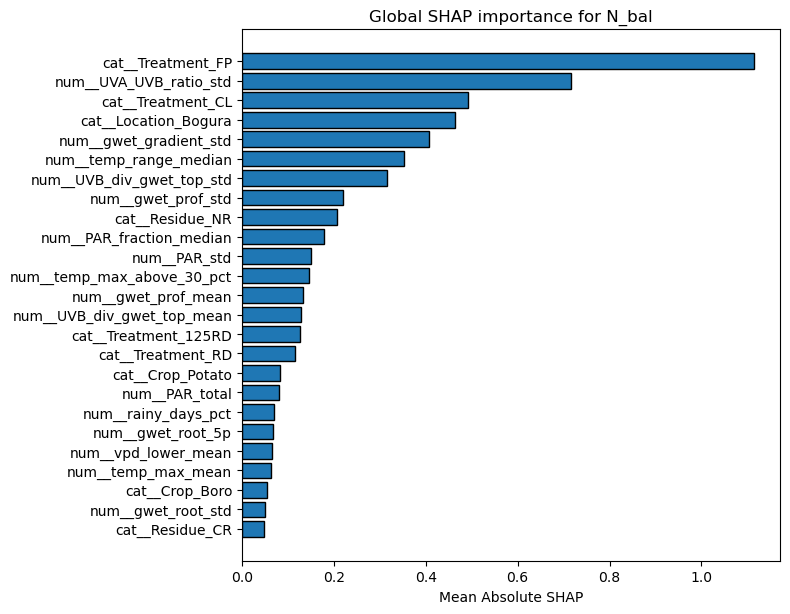

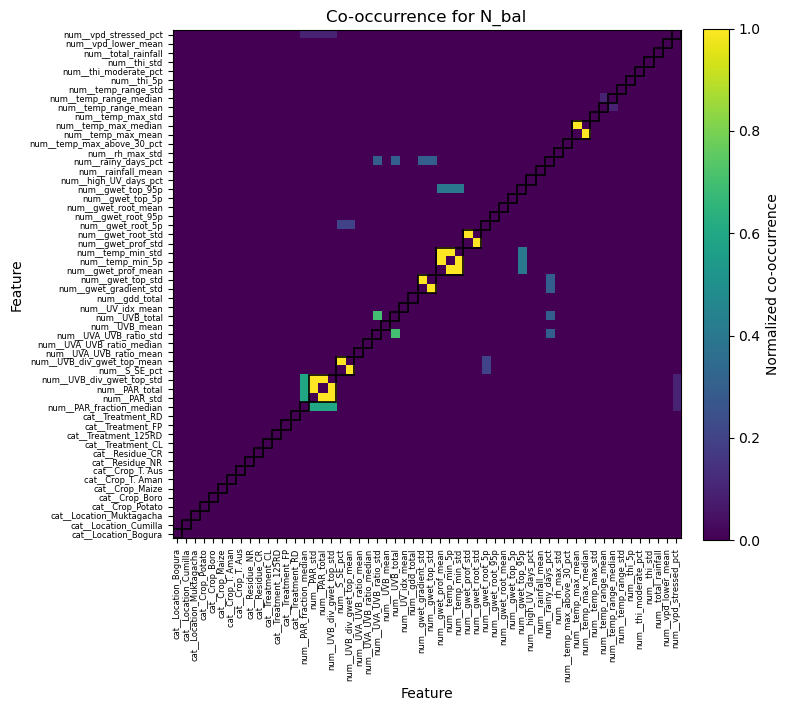

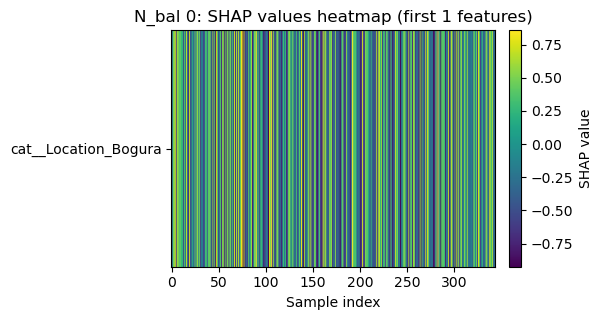

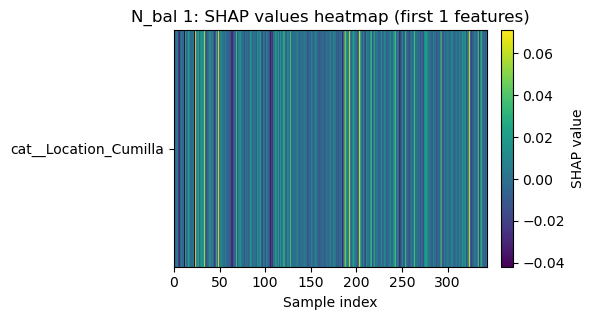

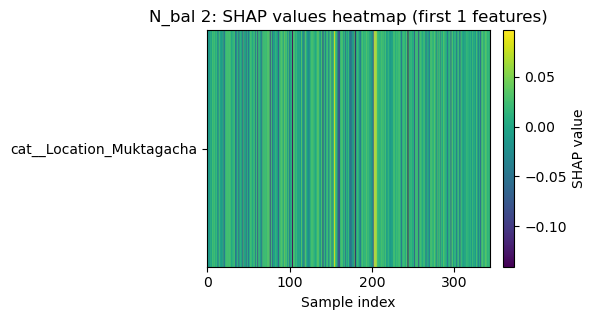

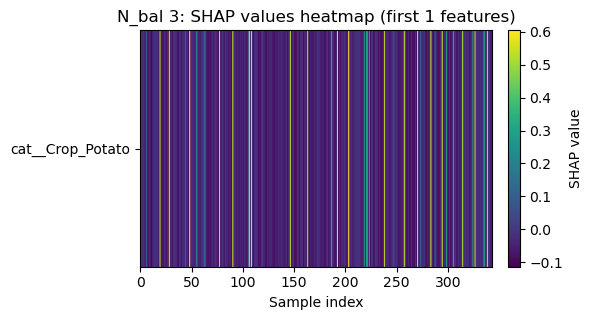

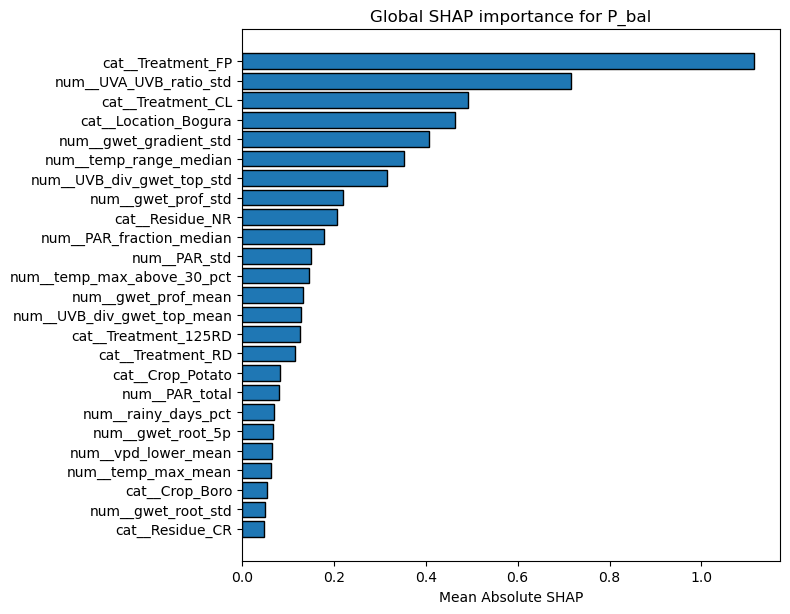

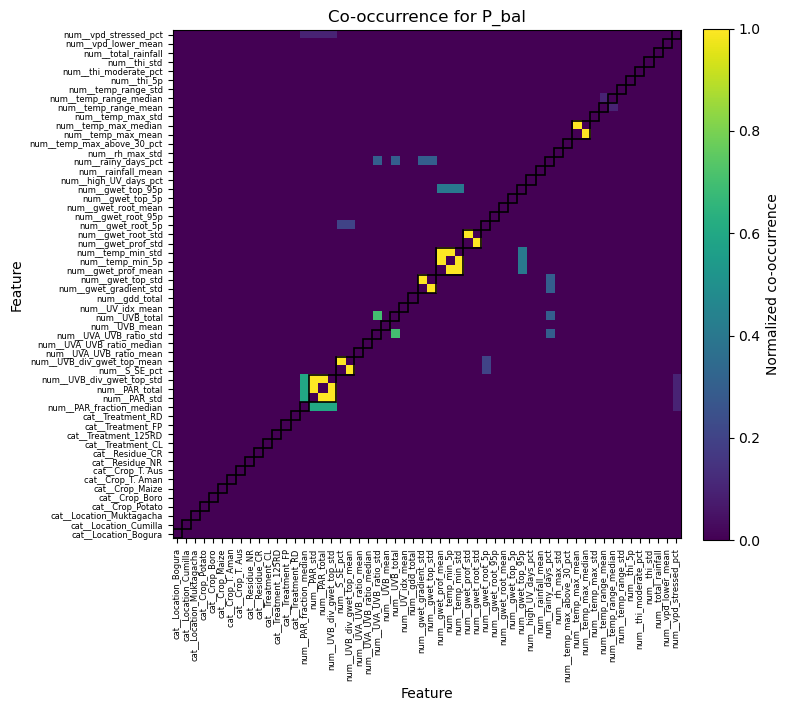

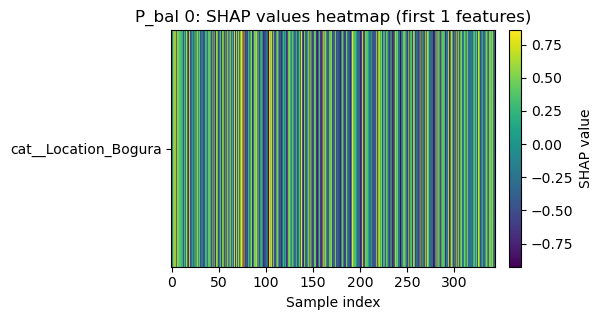

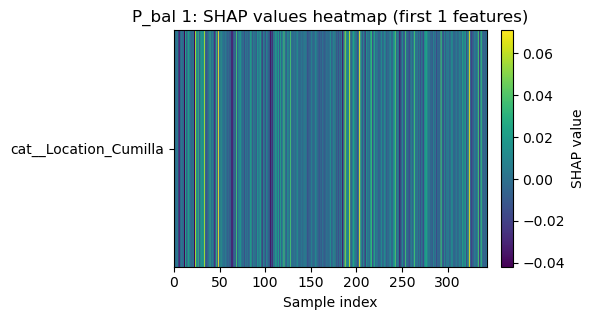

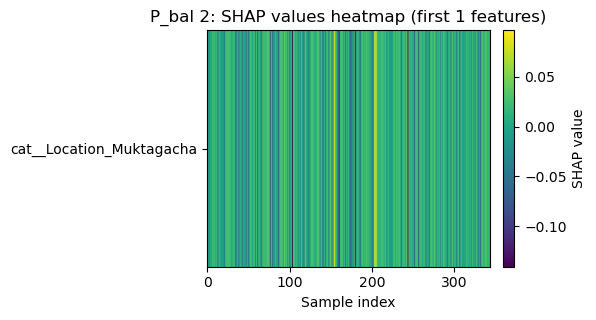

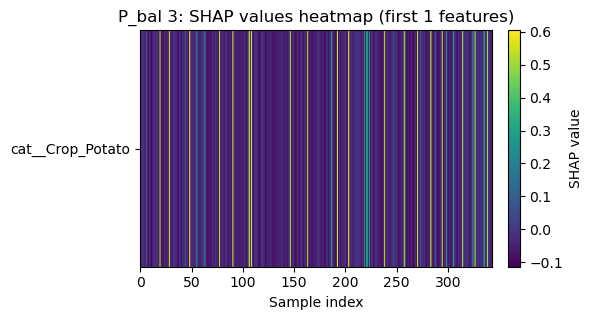

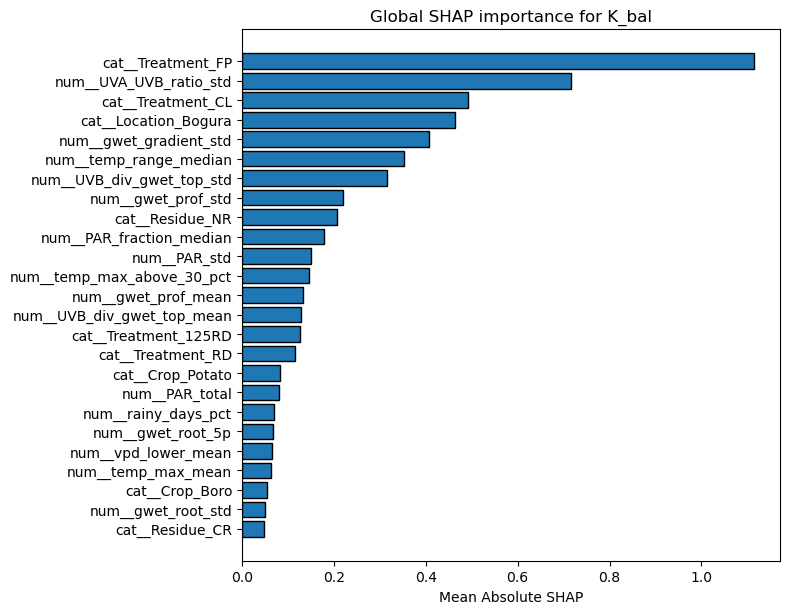

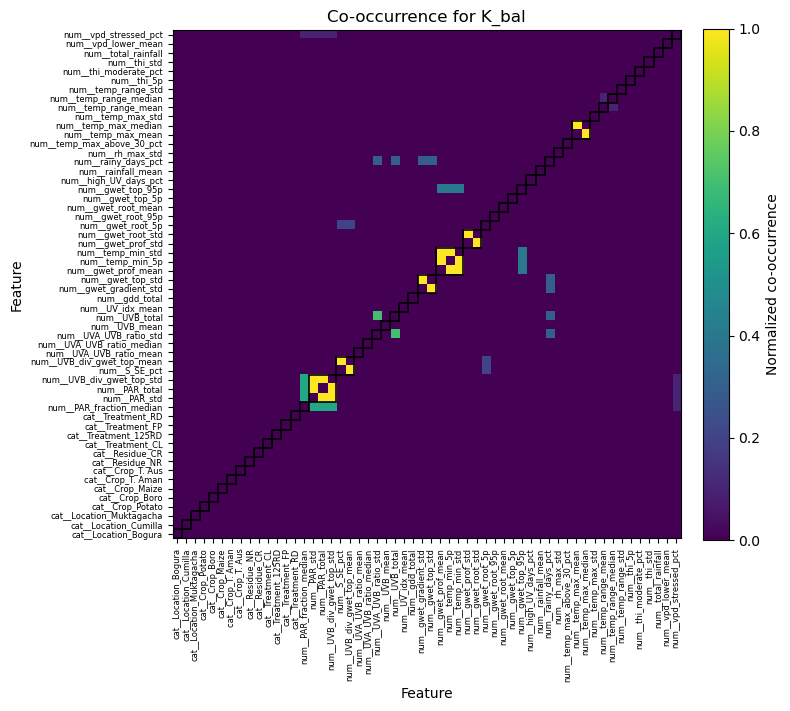

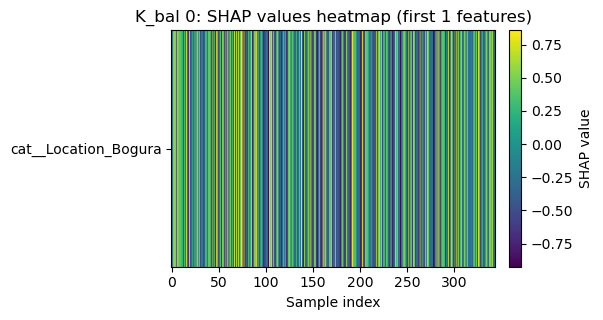

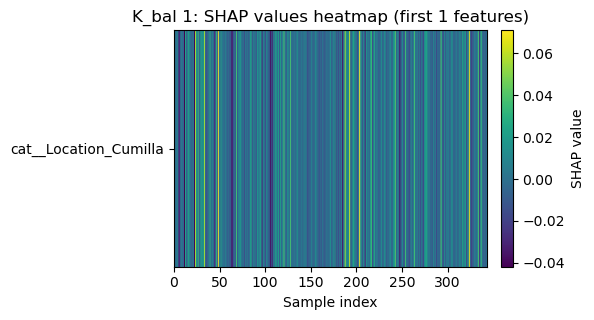

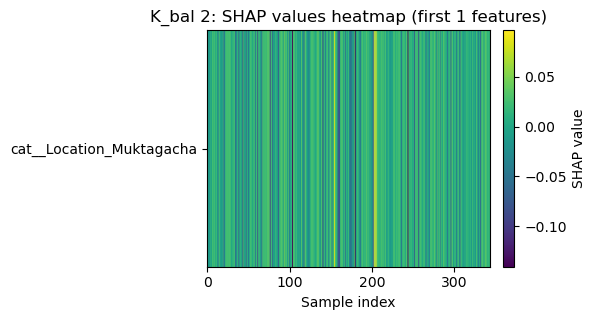

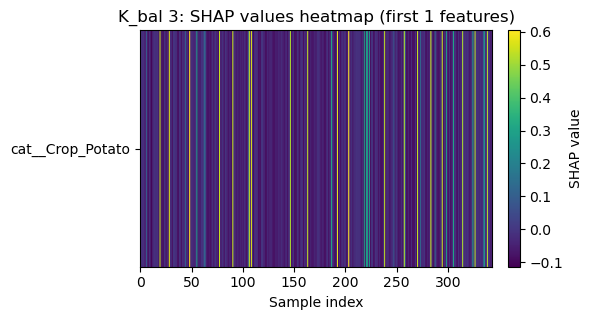

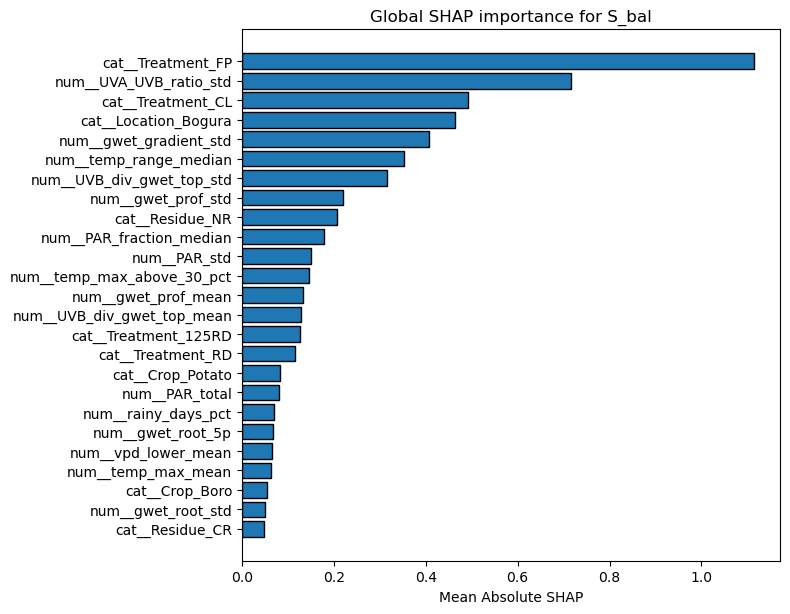

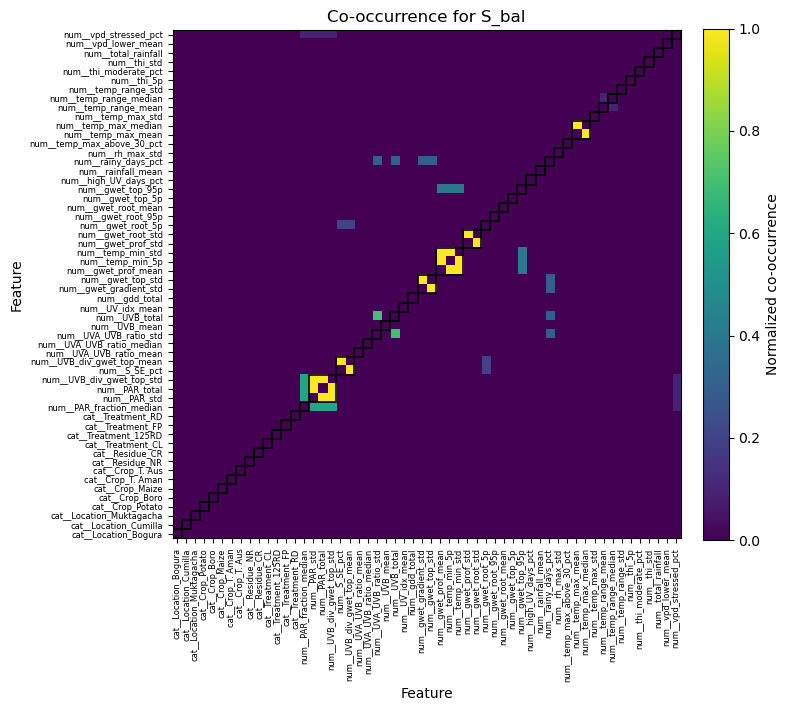

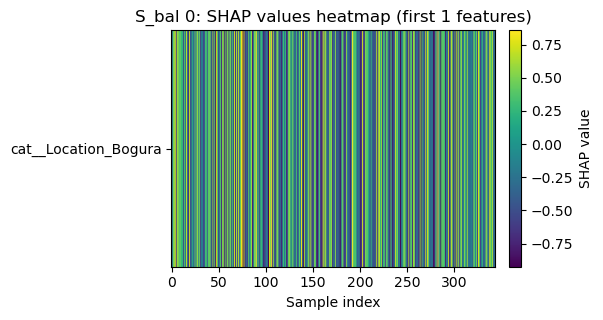

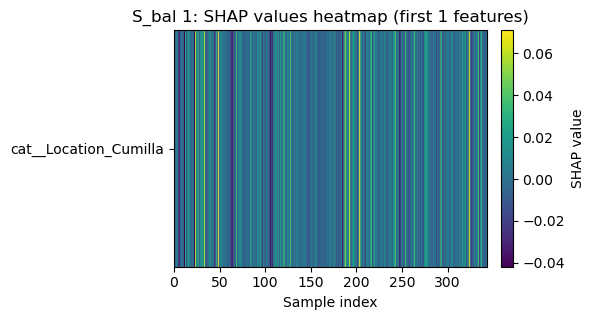

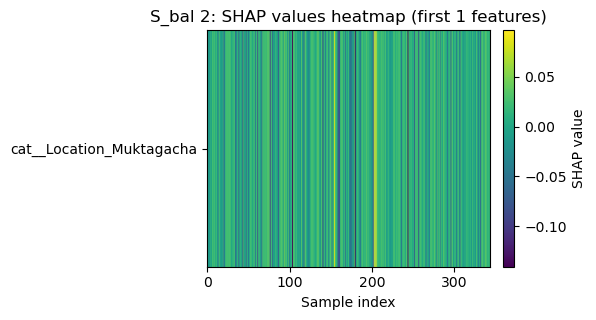

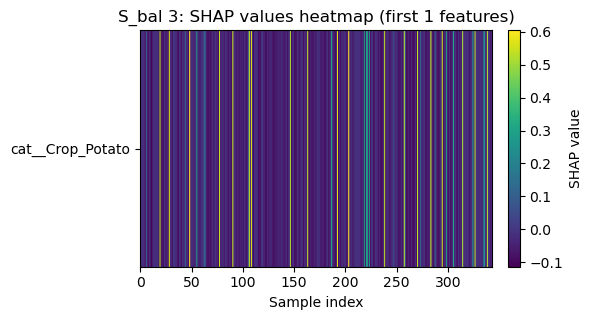

In [103]:
# Generate plots
for y in target_cols:
    plot_global_shap_importance(abs_shap_global, feat_names, top_n=25, title=f"Global SHAP importance for {y}")
    plot_cooccurrence_matrix(cooccur, clusters, feat_names, title=f"Co-occurrence for {y}")
    plot_cluster_shap_heatmaps(shap_vals, clusters, feat_names, max_clusters=4, max_members=4, title_prefix=f"{y}")

In [104]:
def summarize_clusters(clusters, abs_shap_global, cooccur, feat_names):
    """
    clusters: dict root -> list of feature names (as in your union-find output)
    abs_shap_global: array of mean abs SHAP per expanded feature
    cooccur: raw co-occurrence count matrix (shape n_feat x n_feat)
    feat_names: array-like of feature names in the same order as abs_shap_global and cooccur
    """
    feat_idx = {f: i for i, f in enumerate(feat_names)}
    rows = []
    for root, members in clusters.items():
        # Representative: highest global |SHAP|
        rep = max(members, key=lambda m: abs_shap_global[feat_idx[m]])
        # Cluster size
        size = len(members)
        # Compute internal stability: mean normalized co-occurrence among all pairs in cluster
        if size > 1:
            pair_vals = []
            for i, j in itertools.combinations(members, 2):
                ii, jj = feat_idx[i], feat_idx[j]
                # normalize by max possible (assuming cooccur was counts over N_BOOTSTRAPS)
                norm = cooccur[ii, jj] / N_BOOTSTRAPS
                pair_vals.append(norm)
            internal_stability = np.mean(pair_vals)
            min_stability = np.min(pair_vals)
        else:
            internal_stability = 1.0  # singleton is trivially stable with itself
            min_stability = 1.0

        rows.append({
            "cluster_root": root,
            "rep_feature": rep,
            "members": ", ".join(members),
            "size": size,
            "mean_cooccur": internal_stability,
            "min_cooccur": min_stability
        })
    return pd.DataFrame(rows).sort_values(by=["size", "mean_cooccur"], ascending=[False, False])


In [105]:
cluster_summary_df = summarize_clusters(
    clusters,
    abs_shap_global,
    cooccur,
    feat_names
)
print(f"Cluster summary for {'N_bal'}")
print(cluster_summary_df.to_string(index=False))

Cluster summary for N_bal
 cluster_root                rep_feature                                                  members  size  mean_cooccur  min_cooccur
           15  num__UVB_div_gwet_top_std  num__PAR_std, num__PAR_total, num__UVB_div_gwet_top_std     3           1.0          1.0
           28        num__gwet_prof_mean num__gwet_prof_mean, num__temp_min_5p, num__temp_min_std     3           1.0          1.0
           17 num__UVB_div_gwet_top_mean                num__S_SE_pct, num__UVB_div_gwet_top_mean     2           1.0          1.0
           27     num__gwet_gradient_std                num__gwet_gradient_std, num__gwet_top_std     2           1.0          1.0
           29         num__gwet_prof_std                   num__gwet_prof_std, num__gwet_root_std     2           1.0          1.0
           42         num__temp_max_mean                 num__temp_max_mean, num__temp_max_median     2           1.0          1.0
            0       cat__Location_Bogura                 

In [106]:
def get_intra_inter_cooccurrence(clusters, cooccur, feat_names, n_bootstraps):
    """
    Return two arrays: intra-cluster normalized co-occurrence vs inter-cluster.
    cooccur is raw counts (shape n_feat x n_feat), feat_names is list/array.
    """
    feat_idx = {f: i for i, f in enumerate(feat_names)}
    intra, inter = [], []
    # build a mapping from feature to its cluster root for fast lookup
    member_to_root = {}
    for root, members in clusters.items():
        for m in members:
            member_to_root[m] = root

    all_feats = list(feat_names)
    for a, b in combinations(all_feats, 2):
        ia, ib = feat_idx[a], feat_idx[b]
        norm_val = cooccur[ia, ib] / n_bootstraps  # in [0,1]
        if member_to_root.get(a, None) is not None and member_to_root.get(b, None) is not None \
           and member_to_root[a] == member_to_root[b]:
            intra.append(norm_val)
        else:
            inter.append(norm_val)
    return np.array(intra), np.array(inter)

def plot_intra_inter(intra, inter, title=None):
    """
    Box/violin comparison of intra vs inter co-occurrence.
    """
    fig, ax = plt.subplots(figsize=(5, 4))
    ax.boxplot([intra, inter], labels=["intra-cluster", "inter-cluster"], patch_artist=True)
    ax.set_ylabel("Normalized co-occurrence")
    ax.set_title(title or "Intra vs Inter co-occurrence")
    ax.grid(False)
    # annotate medians
    medians = [np.median(intra), np.median(inter)]
    for i, m in enumerate(medians, start=1):
        ax.text(i, m + 0.02, f"{m:.2f}", ha="center", va="bottom", fontsize=9)
    plt.tight_layout()
    plt.show()

[N_bal] intra mean=1.000, inter mean=0.004
[N_bal] intra median=1.000, inter median=0.000
[N_bal] Mann-Whitney U test (intra > inter): U=15300.0, p=3.033e-123


/var/folders/qx/5zbpywt5661d6xr06v91bdyr0000gn/T/ipykernel_5360/2496619947.py:35: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([intra, inter], labels=["intra-cluster", "inter-cluster"], patch_artist=True)


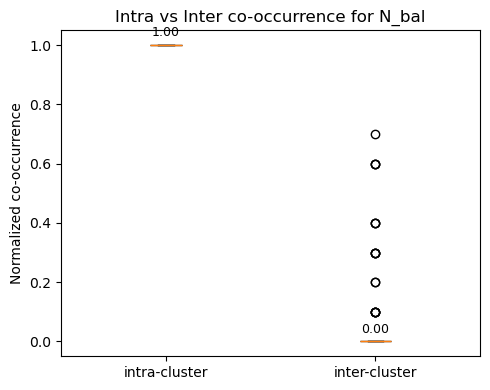

[P_bal] intra mean=1.000, inter mean=0.004
[P_bal] intra median=1.000, inter median=0.000
[P_bal] Mann-Whitney U test (intra > inter): U=15300.0, p=3.033e-123


/var/folders/qx/5zbpywt5661d6xr06v91bdyr0000gn/T/ipykernel_5360/2496619947.py:35: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([intra, inter], labels=["intra-cluster", "inter-cluster"], patch_artist=True)


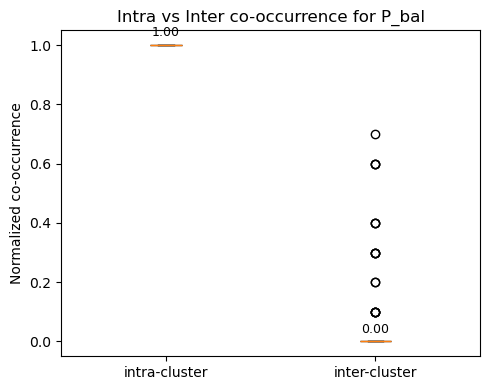

[K_bal] intra mean=1.000, inter mean=0.004
[K_bal] intra median=1.000, inter median=0.000
[K_bal] Mann-Whitney U test (intra > inter): U=15300.0, p=3.033e-123


/var/folders/qx/5zbpywt5661d6xr06v91bdyr0000gn/T/ipykernel_5360/2496619947.py:35: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([intra, inter], labels=["intra-cluster", "inter-cluster"], patch_artist=True)


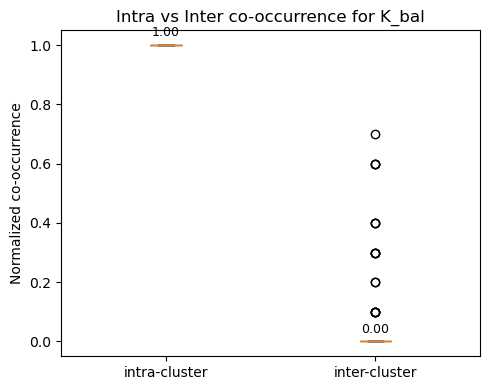

[S_bal] intra mean=1.000, inter mean=0.004
[S_bal] intra median=1.000, inter median=0.000
[S_bal] Mann-Whitney U test (intra > inter): U=15300.0, p=3.033e-123


/var/folders/qx/5zbpywt5661d6xr06v91bdyr0000gn/T/ipykernel_5360/2496619947.py:35: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([intra, inter], labels=["intra-cluster", "inter-cluster"], patch_artist=True)


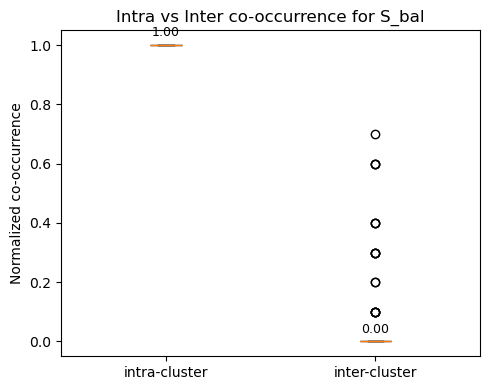

In [107]:
# === Example usage (inside target loop, after clusters & cooccur are available) ===
intra_vals, inter_vals = get_intra_inter_cooccurrence(
    clusters, cooccur, feat_names, N_BOOTSTRAPS
)

for y in target_cols:
    # Quick summary
    print(f"[{y}] intra mean={np.mean(intra_vals):.3f}, inter mean={np.mean(inter_vals):.3f}")
    print(f"[{y}] intra median={np.median(intra_vals):.3f}, inter median={np.median(inter_vals):.3f}")
    
    # Statistical test: are intra values significantly larger than inter?
    if len(intra_vals) > 0 and len(inter_vals) > 0:
        stat, pvalue = mannwhitneyu(intra_vals, inter_vals, alternative="greater")
        print(f"[{y}] Mann-Whitney U test (intra > inter): U={stat:.1f}, p={pvalue:.3e}")
    else:
        print(f"[{y}] Not enough pairs to compare intra vs inter.")
    
    # Plot distribution comparison
    plot_intra_inter(intra_vals, inter_vals, title=f"Intra vs Inter co-occurrence for {y}")


## 2-3 Compare filter results

In [109]:
methods = {
    "LinearRFE": HIER_RFE_features,
    "LassoRFE": HIER_RFE_LASSO_features,
    "RFRFE": HIER_RFE_RF_features,
    "SHAPCluster": cluster_kept_feats
}
metrics = {
    "LinearRFE": HIER_RFE_metrics,
    "LassoRFE": HIER_RFE_LASSO_metrics,
    "RFRFE": HIER_RFE_RF_metrics,
    "SHAPCluster": cluster_metrics
}

rows = []
for y in target_cols:
    for name in methods:
        feats = methods[name][y]
        m = metrics[name][y]
        rows.append({
            "target": y,
            "method": name,
            "val_R2": m["val_R2"],
            "train_R2": m["train_R2"],
            "n_features": len(feats),
            "features": ", ".join(sorted(feats))
        })
summary_df = pd.DataFrame(rows)
print(summary_df)


   target       method    val_R2  train_R2  n_features  \
0   N_bal    LinearRFE  0.660761  0.748140          36   
1   N_bal     LassoRFE  0.661086  0.748576           9   
2   N_bal        RFRFE  0.784416  0.945574          46   
3   N_bal  SHAPCluster  0.810926  0.944110          36   
4   P_bal    LinearRFE  0.688600  0.767672           1   
5   P_bal     LassoRFE  0.667333  0.767223           2   
6   P_bal        RFRFE  0.976829  0.994917          27   
7   P_bal  SHAPCluster  0.978769  0.994496          25   
8   K_bal    LinearRFE  0.687038  0.609286          32   
9   K_bal     LassoRFE  0.681328  0.607852          10   
10  K_bal        RFRFE  0.837041  0.929732          42   
11  K_bal  SHAPCluster  0.839001  0.925483          36   
12  S_bal    LinearRFE  0.697466  0.710471          11   
13  S_bal     LassoRFE  0.697230  0.710179          37   
14  S_bal        RFRFE  0.861880  0.947416           1   
15  S_bal  SHAPCluster  0.870505  0.944665          34   

             

In [110]:
from itertools import combinations

overlap_rows = []
for y in target_cols:
    for a, b in combinations(methods.keys(), 2):
        set_a = set(methods[a][y])
        set_b = set(methods[b][y])
        inter = len(set_a & set_b)
        union = len(set_a | set_b)
        ji = inter / union if union else 1.0
        overlap_rows.append({
            "target": y,
            "method_a": a,
            "method_b": b,
            "jaccard": ji
        })
overlap_df = pd.DataFrame(overlap_rows)
print(overlap_df)


   target   method_a     method_b   jaccard
0   N_bal  LinearRFE     LassoRFE  0.216216
1   N_bal  LinearRFE        RFRFE  0.708333
2   N_bal  LinearRFE  SHAPCluster  0.600000
3   N_bal   LassoRFE        RFRFE  0.170213
4   N_bal   LassoRFE  SHAPCluster  0.216216
5   N_bal      RFRFE  SHAPCluster  0.708333
6   P_bal  LinearRFE     LassoRFE  0.000000
7   P_bal  LinearRFE        RFRFE  0.037037
8   P_bal  LinearRFE  SHAPCluster  0.040000
9   P_bal   LassoRFE        RFRFE  0.074074
10  P_bal   LassoRFE  SHAPCluster  0.080000
11  P_bal      RFRFE  SHAPCluster  0.575758
12  K_bal  LinearRFE     LassoRFE  0.200000
13  K_bal  LinearRFE        RFRFE  0.608696
14  K_bal  LinearRFE  SHAPCluster  0.619048
15  K_bal   LassoRFE        RFRFE  0.238095
16  K_bal   LassoRFE  SHAPCluster  0.150000
17  K_bal      RFRFE  SHAPCluster  0.625000
18  S_bal  LinearRFE     LassoRFE  0.297297
19  S_bal  LinearRFE        RFRFE  0.090909
20  S_bal  LinearRFE  SHAPCluster  0.250000
21  S_bal   LassoRFE        RFRF

In [111]:
# Build feature groups per target according to the specified core / full sets logic.

# Assumed existing dictionaries from earlier steps:
# - HIER_RFE_features            : hierarchical RFE using plain LinearRegression
# - HIER_RFE_LASSO_features      : hierarchical RFE using Lasso
# - HIER_RFE_RF_features         : hierarchical RFE using RandomForest (RFRFE)
# - cluster_kept_feats          : SHAP-cluster retained env features (using XGBoost)
# Each is a dict mapping target name (e.g., "N_bal") to a list of selected env feature names.

# We'll normalize to sets for easy intersection/union.
linear_rfe_sets = {y: set(HIER_RFE_features[y]) for y in target_cols}          # LinearRFE
rf_rfe_sets     = {y: set(HIER_RFE_RF_features[y]) for y in target_cols}       # RFRFE
shap_sets       = {y: set(cluster_kept_feats[y]) for y in target_cols}         # SHAPClusterXGB

# Prepare container for the constructed groups
feature_groups = {}

for y in target_cols:
    groups = {}

    if y == "N_bal":
        # core: intersection of SHAPCluster and LinearRFE
        groups["core"] = shap_sets[y] & linear_rfe_sets[y]  # core supported by both SHAP cluster and linear RFE
        # full SHAP cluster set
        groups["full_SHAP"] = shap_sets[y]                  # all features selected by SHAP clustering
    elif y == "P_bal":
        # core: intersection of RFRFE and SHAPCluster
        groups["core"] = rf_rfe_sets[y] & shap_sets[y]      # core supported by RF RFE and SHAP cluster
        # full sets
        groups["full_SHAP"] = shap_sets[y]                  # all SHAP-cluster-selected features
        groups["full_RFRFE"] = rf_rfe_sets[y]               # all RF-RFE-selected features
    elif y == "K_bal":
        # core: intersection of RFRFE and SHAPCluster
        groups["core"] = rf_rfe_sets[y] & shap_sets[y]
        groups["full_SHAP"] = shap_sets[y]
        groups["full_RFRFE"] = rf_rfe_sets[y]
    elif y == "S_bal":
        # core: intersection of RFRFE and SHAPCluster (though only one feature)
        groups["core"] = rf_rfe_sets[y] & shap_sets[y]
        groups["full_SHAP"] = shap_sets[y]
    else:
        # fallback: empty
        groups["core"] = set()
        groups["full_SHAP"] = shap_sets.get(y, set())
        groups["full_RFRFE"] = rf_rfe_sets.get(y, set())

    feature_groups[y] = groups

# Create a summary DataFrame showing sizes and source info
rows = []
for y, grp in feature_groups.items():
    row = {"target": y}
    # core
    row["core_size"] = len(grp.get("core", []))
    row["core_features"] = ", ".join(sorted(grp.get("core", [])))
    # full SHAP
    row["full_SHAP_size"] = len(grp.get("full_SHAP", []))
    row["full_SHAP_features"] = ", ".join(sorted(grp.get("full_SHAP", [])))
    # full RFRFE if exists
    if "full_RFRFE" in grp:
        row["full_RFRFE_size"] = len(grp.get("full_RFRFE", []))
        row["full_RFRFE_features"] = ", ".join(sorted(grp.get("full_RFRFE", [])))
    rows.append(row)

feature_group_summary = pd.DataFrame(rows)
print("Constructed feature groups per target (core / full_SHAP / full_RFRFE where applicable):")
feature_group_summary


Constructed feature groups per target (core / full_SHAP / full_RFRFE where applicable):


,target,core_size,core_features,full_SHAP_size,full_SHAP_features,full_RFRFE_size,full_RFRFE_features
0,N_bal,27,"C4_PAR_active_days_pct, N_NE_pct, N_NW_pct, S_SE_pct, UVB_div_gwet_top_std, UVB_total, UV_idx_mean, W_NW_pct, gdd_total, gwet_prof_mean, gwet_root_95p, gwet_top_5p, gwet_top_std, high_humidity_pct, rain_intensity_index, rainfall_mean, rh_max_std, rh_min_std, rh_range_mean, temp_max_95p, temp_min_below_10_pct, temp_min_below_5_pct, temp_range_above_10_pct, temp_range_above_15_pct, thi_mean, vpd_middle_mean, vpd_stressed_pct",36,"C4_PAR_active_days_pct, N_NE_pct, N_NW_pct, PAR_fraction_median, PAR_std, S_SE_pct, UVA_UVB_ratio_median, UVB_div_gwet_top_std, UVB_total, UV_idx_mean, W_NW_pct, gdd_total, gwet_prof_mean, gwet_prof_std, gwet_root_95p, gwet_root_median, gwet_top_5p, gwet_top_std, high_humidity_pct, rain_intensity_index, rainfall_mean, rainy_days_pct, rh_max_std, rh_min_std, rh_range_mean, temp_max_95p, temp_max_std, temp_min_below_10_pct, temp_min_below_5_pct, temp_range_above_10_pct, temp_range_above_15_pct, temp_range_median, thi_5p, thi_mean, vpd_middle_mean, vpd_stressed_pct",NaN,NaN
1,P_bal,19,"C3_PAR_active_days_pct, gdd_total, gwet_gradient_std, gwet_prof_std, gwet_top_median, heavy_rain_days_pct, rainfall_mean, rh_max_std, temp_max_95p, temp_max_median, temp_max_std, temp_min_std, temp_range_above_10_pct, temp_range_median, thi_5p, thi_95p, vpd_lower_mean, vpd_middle_mean, wind_speed_mean",25,"C3_PAR_active_days_pct, N_NE_pct, S_SE_pct, W_NW_pct, gdd_total, gwet_gradient_std, gwet_prof_std, gwet_root_std, gwet_top_median, heavy_rain_days_pct, max_consecutive_dry_days, rain_intensity_index, rainfall_mean, rh_max_std, temp_max_95p, temp_max_median, temp_max_std, temp_min_std, temp_range_above_10_pct, temp_range_median, thi_5p, thi_95p, vpd_lower_mean, vpd_middle_mean, wind_speed_mean",27.0,"C3_PAR_active_days_pct, C4_PAR_active_days_pct, PAR_fraction_std, PAR_x_gwet_root_std, UVB_div_gwet_top_std, gdd_total, gwet_gradient_std, gwet_prof_std, gwet_root_median, gwet_top_median, gwet_top_std, heavy_rain_days_pct, rainfall_mean, rh_max_std, temp_max_95p, temp_max_median, temp_max_std, temp_min_below_10_pct, temp_min_std, temp_range_above_10_pct, temp_range_median, thi_5p, thi_95p, thi_mild_pct, vpd_lower_mean, vpd_middle_mean, wind_speed_mean"
2,K_bal,30,"C4_PAR_active_days_pct, N_NE_pct, PAR_fraction_median, UVB_mean, UVB_std, UVB_total, UV_idx_mean, calm_days_pct, gdd_mean_daily, gwet_prof_5p, gwet_prof_mean, gwet_prof_std, gwet_root_5p, gwet_root_95p, gwet_top_5p, gwet_top_median, high_humidity_pct, rain_intensity_index, rainy_days_pct, rh_min_std, temp_max_above_30_pct, temp_max_mean, temp_max_std, temp_min_median, temp_range_above_10_pct, temp_range_median, thi_mean, thi_moderate_pct, vpd_stressed_pct, wind_speed_mean",36,"C4_PAR_active_days_pct, N_NE_pct, PAR_fraction_median, UVB_mean, UVB_std, UVB_total, UV_idx_mean, calm_days_pct, gdd_mean_daily, gwet_prof_5p, gwet_prof_95p, gwet_prof_mean, gwet_prof_std, gwet_root_5p, gwet_root_95p, gwet_top_5p, gwet_top_median, high_humidity_pct, rain_intensity_index, rainy_days_pct, rh_min_std, rh_range_mean, temp_max_above_30_pct, temp_max_mean, temp_max_std, temp_min_5p, temp_min_median, temp_range_above_10_pct, temp_range_mean, temp_range_median, thi_5p, thi_mean, thi_moderate_pct, vpd_stressed_pct, vpd_upper_mean, wind_speed_mean",42.0,"C4_PAR_active_days_pct, N_NE_pct, PAR_fraction_median, PAR_std, S_SE_pct, UVA_UVB_ratio_mean, UVA_UVB_ratio_median, UVA_UVB_ratio_std, UVB_div_gwet_top_mean, UVB_div_gwet_top_std, UVB_mean, UVB_std, UVB_total, UV_idx_mean, calm_days_pct, gdd_mean_daily, gwet_prof_5p, gwet_prof_mean, gwet_prof_std, gwet_root_5p, gwet_root_95p, gwet_root_median, gwet_root_std, gwet_top_5p, gwet_top_median, high_humidity_pct, rain_intensity_index, rainfall_mean, rainy_days_pct, rh_max_std, rh_min_std, temp_max_above_30_pct, temp_max_mean, temp_max_std, temp_min_median, temp_min_std, temp_range_above_10_pct, temp_range_median, thi_mean, thi_moder

# 3. Final models

## 3-1 XGBoost

In [114]:
# Helper to build X and y for a given target and feature subset
def build_feature_matrix(df, target, extra_env_feats):
    """
    df: DataFrame containing control_cols, env features, target
    extra_env_feats: set/list of environmental features to include (does not include control)
    returns X_df (with control + those env), y_series
    """
    use_feats = control_cols + list(extra_env_feats)
    X = df[use_feats].copy()
    y = df[target].copy()
    return X, y

# Preprocessor: one-hot encode control categorical columns; environmental features are assumed numeric already
def make_preprocessor_for_env(control_cols, env_feats):
    transformers = []
    # one-hot control columns (use sparse_output=False to get dense)
    transformers.append((
        "cat_ctrl",
        OneHotEncoder(handle_unknown="ignore", sparse_output=False),
        control_cols
    ))
    # pass through env features if any
    if env_feats:
        transformers.append((
            "env",
            "passthrough",
            env_feats
        ))
    return ColumnTransformer(transformers, remainder="drop")

# Parameter distributions for random search
param_dist = {
    "xgb__n_estimators": randint(100, 501),          # 100 to 500
    "xgb__max_depth": randint(3, 8),                 # 3 to 7
    "xgb__learning_rate": loguniform(0.01, 0.3),      # 0.01 to 0.3
    "xgb__subsample": uniform(0.6, 0.4),             # 0.6 to 1.0
    "xgb__colsample_bytree": uniform(0.6, 0.4),      # 0.6 to 1.0
    "xgb__gamma": uniform(0, 1),                     # regularization
    "xgb__reg_alpha": loguniform(1e-3, 10),
    "xgb__reg_lambda": loguniform(1e-3, 10),
}

# Storage for summary
summary_rows = []

# For each target, build three predictor sets and run tuning
for y in target_cols:
    # Prepare feature sets
    core_feats = feature_groups[y]["core"]
    full_shap_feats = feature_groups[y]["full_SHAP"]
    # Baseline: only control
    sets_to_try = {
        "control_only": set(),  # no extra env
        "control_plus_core": core_feats,
        "control_plus_full_SHAP": full_shap_feats
    }

    for set_name, extra_feats in sets_to_try.items():
        # skip if core is empty (e.g., possible) or full_SHAP missing
        if set_name == "control_plus_core" and not extra_feats:
            continue
        if set_name == "control_plus_full_SHAP" and not extra_feats:
            continue

        # Build training and validation matrices
        X_train_raw, y_train = build_feature_matrix(train_df, y, extra_feats)
        X_val_raw, y_val = build_feature_matrix(val_df, y, extra_feats)

        # Preprocess: encode controls and pass through env
        preproc = make_preprocessor_for_env(control_cols, list(extra_feats))
        pipe = Pipeline([
            ("prep", preproc),
            ("xgb", XGBRegressor(
                objective="reg:squarederror",
                tree_method="auto",
                random_state=114,
                n_jobs=-1,
                # will be overridden by RandomizedSearchCV
            ))
        ])

        # Randomized search with 5-fold CV on training set
        search = RandomizedSearchCV(
            estimator=pipe,
            param_distributions=param_dist,
            n_iter=60,  # budget, adjust if too slow
            scoring="r2",
            cv=KFold(n_splits=5, shuffle=True, random_state=114),
            verbose=1,
            random_state=114,
            n_jobs=-1,
            refit=True
        )
        search.fit(X_train_raw, y_train)

        best_pipe = search.best_estimator_

        # Predictions
        train_pred = best_pipe.predict(X_train_raw)
        val_pred = best_pipe.predict(X_val_raw)

        train_r2 = r2_score(y_train, train_pred)
        val_r2 = r2_score(y_val, val_pred)

        # Complexity: number of original X predictors used (control + env)
        n_control = len(control_cols)
        n_env = len(extra_feats)
        total_features = n_control + n_env

        # Record which features (original) are used
        if set_name == "control_only":
            used_features = control_cols.copy()
        else:
            used_features = control_cols + sorted(extra_feats)

        summary_rows.append({
            "target": y,
            "predictor_set": set_name,
            "train_R2": train_r2,
            "val_R2": val_r2,
            "#original_features": total_features,
            "used_features": ", ".join(used_features),
            "best_params": search.best_params_,
        })

# Compile summary DataFrame
xgb_summary = pd.DataFrame(summary_rows)

# Sort for readability
xgb_summary = xgb_summary.sort_values(["target", "predictor_set"])

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Fitting 5 folds for each of 60 candidates, totalling 300 fits


In [115]:
# Print comparison
print("XGBoost comparison (control, core, full_SHAP) per target:")
print(xgb_summary[[
    "target", "predictor_set", "train_R2", "val_R2", "#original_features"
]].to_string(index=False))

XGBoost comparison (control, core, full_SHAP) per target:
target          predictor_set  train_R2   val_R2  #original_features
 K_bal           control_only  0.708042 0.427894                   4
 K_bal      control_plus_core  0.916232 0.851601                  34
 K_bal control_plus_full_SHAP  0.915179 0.843057                  40
 N_bal           control_only  0.803062 0.618842                   4
 N_bal      control_plus_core  0.936285 0.824353                  31
 N_bal control_plus_full_SHAP  0.936591 0.818228                  40
 P_bal           control_only  0.975309 0.946857                   4
 P_bal      control_plus_core  0.993345 0.977382                  23
 P_bal control_plus_full_SHAP  0.993731 0.978093                  29
 S_bal           control_only  0.743151 0.606455                   4
 S_bal      control_plus_core  0.936272 0.890928                   5
 S_bal control_plus_full_SHAP  0.940961 0.867510                  38


In [116]:
# === Extract & retrain the chosen best XGBoost pipelines (control_plus_core per target) ===
best_xgb_models = {}   # will hold final fitted pipelines per target
best_model_info = []   # summary info

for y in target_cols:
    # filter summary for the chosen predictor_set
    row = xgb_summary[
        (xgb_summary["target"] == y) &
        (xgb_summary["predictor_set"] == "control_plus_core")
    ]
    if row.empty:
        continue  # skip if missing

    row = row.iloc[0]  # single
    extra_feats = feature_groups[y]["core"]  # core set as per logic
    X_train_raw, y_train = build_feature_matrix(train_df, y, extra_feats)
    X_val_raw, y_val = build_feature_matrix(val_df, y, extra_feats)

    # rebuild preprocessor & pipeline with best params
    preproc = make_preprocessor_for_env(control_cols, list(extra_feats))
    # prepare param dict for XGBRegressor: strip "xgb__" prefix if present
    raw_best = row["best_params"]
    xgb_params = {}
    for k, v in raw_best.items():
        if k.startswith("xgb__"):
            xgb_params[k.replace("xgb__", "")] = v
        else:
            xgb_params[k] = v

    # ensure objective and randomness consistent
    xgb_params.setdefault("objective", "reg:squarederror")
    xgb_params.setdefault("random_state", 114)
    xgb_params.setdefault("n_jobs", -1)

    # build final pipeline
    final_pipe = Pipeline([
        ("prep", preproc),
        ("xgb", XGBRegressor(**xgb_params))
    ])
    final_pipe.fit(X_train_raw, y_train)

    # evaluate
    train_pred = final_pipe.predict(X_train_raw)
    val_pred = final_pipe.predict(X_val_raw)
    train_r2 = r2_score(y_train, train_pred)
    val_r2 = r2_score(y_val, val_pred)
    n_features = len(control_cols) + len(extra_feats)

    best_xgb_models[y] = final_pipe
    best_model_info.append({
        "target": y,
        "predictor_set": "control_plus_core",
        "train_R2": train_r2,
        "val_R2": val_r2,
        "#original_features": n_features,
        "core_size": len(extra_feats),
        "used_features": ", ".join(sorted(list(control_cols) + list(extra_feats))),
        "xgb_params": xgb_params
    })

# summary dataframe
best_xgb_summary = pd.DataFrame(best_model_info)
print("Final selected XGBoost models (control_plus_core) performance:")
print(best_xgb_summary[["target", "train_R2", "val_R2", "#original_features", "core_size"]].to_string(index=False))


Final selected XGBoost models (control_plus_core) performance:
target  train_R2   val_R2  #original_features  core_size
 N_bal  0.936285 0.824353                  31         27
 P_bal  0.993345 0.977382                  23         19
 K_bal  0.916232 0.851601                  34         30
 S_bal  0.936272 0.890928                   5          1


## 3-2 Random Forest

In [118]:
# Helper to build X and y
def build_feature_matrix(df, target, extra_env_feats):
    use_feats = control_cols + list(extra_env_feats)
    X = df[use_feats].copy()
    y = df[target].copy()
    return X, y

# Preprocessor: one-hot encode control columns; pass through env features
def make_preprocessor_for_env(control_cols, env_feats):
    transformers = []
    transformers.append((
        "cat_ctrl",
        OneHotEncoder(handle_unknown="ignore", sparse_output=False),
        control_cols
    ))
    if env_feats:
        transformers.append((
            "env",
            "passthrough",
            env_feats
        ))
    return ColumnTransformer(transformers, remainder="drop")

# Random forest hyperparameter search space
rf_param_dist = {
    "rf__n_estimators": randint(100, 501),         # trees
    "rf__max_depth": randint(3, 13),               # depth
    "rf__min_samples_split": randint(2, 11),       # split
    "rf__min_samples_leaf": randint(1, 6),         # leaf
    "rf__max_features": ["sqrt", "log2", 0.5, 0.75, 1.0],  # feature subsampling
}

# Storage
rf_summary_rows = []

for y in target_cols:
    core_feats = feature_groups[y].get("core", set())
    full_rfrfe_feats = feature_groups[y].get("full_RFRFE", set())
    # Define predictor sets based on availability
    sets_to_try = {
        "control_only": set(),
        "control_plus_core": core_feats,
    }
    if full_rfrfe_feats:
        sets_to_try["control_plus_full_RFRFE"] = full_rfrfe_feats

    for set_name, extra_feats in sets_to_try.items():
        if set_name != "control_only" and not extra_feats:
            continue  # skip empty core/full if missing

        # Build data matrices
        X_train_raw, y_train = build_feature_matrix(train_df, y, extra_feats)
        X_val_raw, y_val = build_feature_matrix(val_df, y, extra_feats)

        preproc = make_preprocessor_for_env(control_cols, list(extra_feats))
        pipe = Pipeline([
            ("prep", preproc),
            ("rf", RandomForestRegressor(random_state=114, n_jobs=-1))
        ])

        search = RandomizedSearchCV(
            estimator=pipe,
            param_distributions=rf_param_dist,
            n_iter=60,
            scoring="r2",
            cv=KFold(n_splits=5, shuffle=True, random_state=114),
            verbose=1,
            random_state=114,
            n_jobs=-1,
            refit=True
        )
        search.fit(X_train_raw, y_train)

        best_pipe = search.best_estimator_
        train_pred = best_pipe.predict(X_train_raw)
        val_pred = best_pipe.predict(X_val_raw)
        train_r2 = r2_score(y_train, train_pred)
        val_r2 = r2_score(y_val, val_pred)

        n_control = len(control_cols)
        n_env = len(extra_feats)
        total_features = n_control + n_env

        if set_name == "control_only":
            used_features = control_cols.copy()
        else:
            used_features = control_cols + sorted(extra_feats)

        rf_summary_rows.append({
            "target": y,
            "predictor_set": set_name,
            "train_R2": train_r2,
            "val_R2": val_r2,
            "#original_features": total_features,
            "used_features": ", ".join(used_features),
            "best_params": search.best_params_,
        })

# Compile summary
rf_summary = pd.DataFrame(rf_summary_rows)
rf_summary = rf_summary.sort_values(["target", "predictor_set"])
print("Random Forest comparison (control, core, full_RFRFE) per target:")
print(rf_summary[["target", "predictor_set", "train_R2", "val_R2", "#original_features"]].to_string(index=False))


Fitting 5 folds for each of 60 candidates, totalling 300 fits
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Random Forest comparison (control, core, full_RFRFE) per target:
target           predictor_set  train_R2   val_R2  #original_features
 K_bal            control_only  0.719280 0.395489                   4
 K_bal       control_plus_core  0.928946 0.833339                  34
 K_bal control_plus_full_RFRFE  0.928542 0.831377                  46
 N_bal            control_only  0.8

In [119]:
# === Extract & retrain the chosen best Random Forest pipelines (control_plus_core per target) ===

best_rf_models = {}
best_rf_model_info = []

for y in target_cols:
    # pick the control_plus_core row for this target
    row = rf_summary[
        (rf_summary["target"] == y) &
        (rf_summary["predictor_set"] == "control_plus_core")
    ]
    if row.empty:
        continue
    row = row.iloc[0]
    extra_feats = feature_groups[y]["core"]  # core set used

    # Build feature matrices
    X_train_raw, y_train = build_feature_matrix(train_df, y, extra_feats)
    X_val_raw, y_val = build_feature_matrix(val_df, y, extra_feats)

    # Rebuild preprocessor and pipeline with best params
    preproc = make_preprocessor_for_env(control_cols, list(extra_feats))
    raw_best = row["best_params"]
    rf_params = {}
    for k, v in raw_best.items():
        if k.startswith("rf__"):
            rf_params[k.replace("rf__", "")] = v
        else:
            rf_params[k] = v

    # enforce randomness / threading
    rf_params.setdefault("random_state", 114)
    rf_params.setdefault("n_jobs", -1)

    final_pipe = Pipeline([
        ("prep", preproc),
        ("rf", RandomForestRegressor(**rf_params))
    ])
    final_pipe.fit(X_train_raw, y_train)

    # evaluate
    train_pred = final_pipe.predict(X_train_raw)
    val_pred = final_pipe.predict(X_val_raw)
    train_r2 = r2_score(y_train, train_pred)
    val_r2 = r2_score(y_val, val_pred)
    n_features = len(control_cols) + len(extra_feats)

    best_rf_models[y] = final_pipe
    best_rf_model_info.append({
        "target": y,
        "predictor_set": "control_plus_core",
        "train_R2": train_r2,
        "val_R2": val_r2,
        "#original_features": n_features,
        "core_size": len(extra_feats),
        "used_features": ", ".join(sorted(list(control_cols) + list(extra_feats))),
        "rf_params": rf_params
    })

best_rf_summary = pd.DataFrame(best_rf_model_info)
print("Final selected Random Forest models (control_plus_core) performance:")
print(best_rf_summary[["target", "train_R2", "val_R2", "#original_features", "core_size"]].to_string(index=False))


Final selected Random Forest models (control_plus_core) performance:
target  train_R2   val_R2  #original_features  core_size
 N_bal  0.936047 0.796464                  31         27
 P_bal  0.993814 0.974854                  23         19
 K_bal  0.928946 0.833339                  34         30
 S_bal  0.934533 0.864847                   5          1


## 3-3 Linear model ElasticNet

In [121]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [122]:
# === suppress ConvergenceWarning globally for ElasticNet fits inside contexts ===
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# === Silent ElasticNet subclass that ensures internal suppression too ===
class SilentElasticNet(ElasticNet):
    def fit(self, *args, **kwargs):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=ConvergenceWarning)
            return super().fit(*args, **kwargs)

# Helper to build X and y
def build_feature_matrix(df, target, extra_env_feats):
    use_feats = control_cols + list(extra_env_feats)
    X = df[use_feats].copy()
    y = df[target].copy()
    return X, y

# Preprocessor for ElasticNet: one-hot encode controls, standardize env features
def make_preprocessor_elasticnet(control_cols, env_feats):
    transformers = []
    transformers.append((
        "cat_ctrl",
        OneHotEncoder(handle_unknown="ignore", sparse_output=False),
        control_cols
    ))
    if env_feats:
        transformers.append((
            "num_env",
            Pipeline([("scaler", StandardScaler())]),
            env_feats
        ))
    return ColumnTransformer(transformers, remainder="drop")

# ElasticNet hyperparameter distributions
en_param_dist = {
    "en__alpha": loguniform(1e-4, 1.0),      # regularization strength
    "en__l1_ratio": uniform(0, 1),           # mix between L1 and L2
}

# Storage
en_summary_rows = []

for y in target_cols:
    core_feats = feature_groups[y].get("core", set())
    full_shap_feats = feature_groups[y].get("full_SHAP", set())

    sets_to_try = {
        "control_only": set(),
        "control_plus_core": core_feats,
        "control_plus_full_SHAP": full_shap_feats
    }

    for set_name, extra_feats in sets_to_try.items():
        if set_name != "control_only" and not extra_feats:
            continue  # skip if no env for that set

        X_train_raw, y_train = build_feature_matrix(train_df, y, extra_feats)
        X_val_raw, y_val = build_feature_matrix(val_df, y, extra_feats)

        preproc = make_preprocessor_elasticnet(control_cols, list(extra_feats))
        pipe = Pipeline([
            ("prep", preproc),
            ("en", SilentElasticNet(random_state=114, max_iter=20000))
        ])

        search = RandomizedSearchCV(
            estimator=pipe,
            param_distributions=en_param_dist,
            n_iter=60,
            scoring="r2",
            cv=KFold(n_splits=5, shuffle=True, random_state=114),
            verbose=1,
            random_state=114,
            n_jobs=-1,
            refit=True
        )

        # suppress any residual convergence warnings during fitting
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=ConvergenceWarning)
            search.fit(X_train_raw, y_train)

        best_pipe = search.best_estimator_
        train_pred = best_pipe.predict(X_train_raw)
        val_pred = best_pipe.predict(X_val_raw)
        train_r2 = r2_score(y_train, train_pred)
        val_r2 = r2_score(y_val, val_pred)

        n_control = len(control_cols)
        n_env = len(extra_feats)
        total_features = n_control + n_env

        if set_name == "control_only":
            used_features = control_cols.copy()
        else:
            used_features = control_cols + sorted(extra_feats)

        en_summary_rows.append({
            "target": y,
            "predictor_set": set_name,
            "train_R2": train_r2,
            "val_R2": val_r2,
            "#original_features": total_features,
            "used_features": ", ".join(used_features),
            "best_params": search.best_params_,
        })

# Compile summary
en_summary = pd.DataFrame(en_summary_rows)
en_summary = en_summary.sort_values(["target", "predictor_set"])
print("ElasticNet comparison (control, core, full_SHAP) per target:")
print(en_summary[["target", "predictor_set", "train_R2", "val_R2", "#original_features"]].to_string(index=False))


Fitting 5 folds for each of 60 candidates, totalling 300 fits
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Fitting 5 folds for each of 60 candidates, totalling 300 fits
ElasticNet comparison (control, core, full_SHAP) per target:
target          predictor_set  train_R2   val_R2  #original_features
 K_bal           control_only  0.377718 0.389826                   4
 K_bal      control_plus_core  0.610357 0.679975         

In [123]:
# === Extract & retrain the chosen best ElasticNet pipelines for each target ===

best_en_models = {}
best_en_model_info = []

# Mapping of target to chosen predictor_set based on highest val_R2 and fewest features
chosen_sets = {
    "N_bal": "control_plus_core",
    "P_bal": "control_only",
    "K_bal": "control_plus_core",
    "S_bal": "control_plus_full_SHAP",
}

for y in target_cols:
    set_name = chosen_sets[y]
    # select the corresponding row from en_summary
    row = en_summary[
        (en_summary["target"] == y) &
        (en_summary["predictor_set"] == set_name)
    ].iloc[0]

    # retrieve the feature group
    if set_name == "control_only":
        extra_feats = set()
    else:
        if set_name == "control_plus_core":
            extra_feats = feature_groups[y]["core"]           # core features
        else:  # control_plus_full_SHAP
            extra_feats = feature_groups[y]["full_SHAP"]      # full SHAP cluster

    # build training and validation matrices
    X_train_raw, y_train = build_feature_matrix(train_df, y, extra_feats)
    X_val_raw, y_val     = build_feature_matrix(val_df,   y, extra_feats)

    # rebuild preprocessor and pipeline with best params
    preproc = make_preprocessor_elasticnet(control_cols, list(extra_feats))
    raw_best = row["best_params"]
    en_params = {}
    for k, v in raw_best.items():
        if k.startswith("en__"):
            en_params[k.replace("en__", "")] = v
    en_params.setdefault("random_state", 114)
    en_params.setdefault("max_iter", 100000)

    final_pipe = Pipeline([
        ("prep", preproc),
        ("en", SilentElasticNet(**en_params))
    ])
    final_pipe.fit(X_train_raw, y_train)

    # evaluate
    train_pred = final_pipe.predict(X_train_raw)
    val_pred   = final_pipe.predict(X_val_raw)
    train_r2 = r2_score(y_train, train_pred)
    val_r2   = r2_score(y_val,   val_pred)
    n_features = len(control_cols) + (0 if set_name=="control_only" else len(extra_feats))

    best_en_models[y] = final_pipe
    best_en_model_info.append({
        "target": y,
        "predictor_set": set_name,
        "train_R2": train_r2,
        "val_R2": val_r2,
        "#original_features": n_features,
        "used_features": ", ".join(sorted(control_cols + list(extra_feats))),
        "en_params": en_params
    })

# summary dataframe
best_en_summary = pd.DataFrame(best_en_model_info)
print("Final selected ElasticNet models performance:")
print(best_en_summary[["target", "predictor_set", "train_R2", "val_R2", "#original_features"]].to_string(index=False))


Final selected ElasticNet models performance:
target          predictor_set  train_R2   val_R2  #original_features
 N_bal      control_plus_core  0.748318 0.661563                  31
 P_bal           control_only  0.762516 0.684396                   4
 K_bal      control_plus_core  0.610330 0.679929                  34
 S_bal control_plus_full_SHAP  0.710381 0.697269                  38


## 3-4 Neural Networks

In [125]:
# suppress warnings from convergence / max_iter for MLP
warnings.filterwarnings("ignore")

# Helper to build X and y
def build_feature_matrix(df, target, extra_env_feats):
    use_feats = control_cols + list(extra_env_feats)
    X = df[use_feats].copy()
    y = df[target].copy()
    return X, y

# Preprocessor for MLP: one-hot encode control, standardize env features
def make_preprocessor_mlp(control_cols, env_feats):
    transformers = []
    transformers.append((
        "cat_ctrl",
        OneHotEncoder(handle_unknown="ignore", sparse_output=False),
        control_cols
    ))
    if env_feats:
        transformers.append((
            "num_env",
            StandardScaler(),
            env_feats
        ))
    return ColumnTransformer(transformers, remainder="drop")

# MLP hyperparameter distributions / choices
param_dist = {
    "mlp__hidden_layer_sizes": [(32,), (64,), (32,16), (64,32), (128,64)],
    "mlp__alpha": loguniform(1e-5, 1e-2),           # L2 penalty
    "mlp__learning_rate_init": loguniform(1e-3, 1e-1),
    "mlp__activation": ["relu", "tanh"],
}

# Storage
mlp_summary_rows = []

for y in target_cols:
    core_feats = feature_groups[y].get("core", set())
    full_shap_feats = feature_groups[y].get("full_SHAP", set())

    sets_to_try = {
        "control_only": set(),
        "control_plus_core": core_feats,
        "control_plus_full_SHAP": full_shap_feats
    }

    for set_name, extra_feats in sets_to_try.items():
        if set_name != "control_only" and not extra_feats:
            continue  # skip empty
        # Build data
        X_train_raw, y_train = build_feature_matrix(train_df, y, extra_feats)
        X_val_raw, y_val = build_feature_matrix(val_df, y, extra_feats)

        preproc = make_preprocessor_mlp(control_cols, list(extra_feats))
        pipe = Pipeline([
            ("prep", preproc),
            ("mlp", MLPRegressor(
                random_state=114,
                max_iter=1000,
                early_stopping=True,
                learning_rate="adaptive",
                tol=1e-4,
                verbose=False
            ))
        ])

        search = RandomizedSearchCV(
            estimator=pipe,
            param_distributions=param_dist,
            n_iter=40,
            scoring="r2",
            cv=KFold(n_splits=5, shuffle=True, random_state=114),
            verbose=1,
            random_state=114,
            n_jobs=-1,
            refit=True
        )

        search.fit(X_train_raw, y_train)

        best_pipe = search.best_estimator_
        train_pred = best_pipe.predict(X_train_raw)
        val_pred = best_pipe.predict(X_val_raw)
        train_r2 = r2_score(y_train, train_pred)
        val_r2 = r2_score(y_val, val_pred)

        n_control = len(control_cols)
        n_env = len(extra_feats)
        total_features = n_control + n_env

        if set_name == "control_only":
            used_features = control_cols.copy()
        else:
            used_features = control_cols + sorted(extra_feats)

        mlp_summary_rows.append({
            "target": y,
            "predictor_set": set_name,
            "train_R2": train_r2,
            "val_R2": val_r2,
            "#original_features": total_features,
            "used_features": ", ".join(used_features),
            "best_params": search.best_params_,
        })

# Compile summary
mlp_summary = pd.DataFrame(mlp_summary_rows)
mlp_summary = mlp_summary.sort_values(["target", "predictor_set"])
print("MLP (NN) comparison (control, core, full_SHAP) per target:")
print(mlp_summary[["target", "predictor_set", "train_R2", "val_R2", "#original_features"]].to_string(index=False))


Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Fitting 5 folds for each of 40 candidates, totalling 200 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Fitting 5 folds for each of 40 candidates, totalling 200 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
MLP (NN) comparison (control, core, full_SHAP) per target:
target          predictor_set  train_R2   val_R2  #original_features
 K_bal           control_only  0.686616 0.458229                   4
 K_bal      control_plus_core  0.890969 0.843750                  34
 K_bal control_plus_full_SHAP  0.763882 0.757376                  40
 N_bal           control_only  0.804027 0.556602                   4
 N_bal      control_plus_core  0.935255 0.745079                  31
 N_bal control_plus_full_SHAP  0.916085 0.803626                  40
 P_bal           control_only  0.973054 0.945157                   4
 P_bal      contr

In [126]:
# suppress non-critical warnings
warnings.filterwarnings("ignore")

# === Only focus on N_bal, adjusted MLP to reduce overfit ===
target = "N_bal"
# feature groups for N_bal
core_feats = feature_groups[target].get("core", set())
full_shap_feats = feature_groups[target].get("full_SHAP", set())

# Predictor sets to try (same as before)
sets_to_try = {
    "control_only": set(),
    "control_plus_core": core_feats,
    "control_plus_full_SHAP": full_shap_feats
}

# Helper to build X and y for this target
def build_feature_matrix(df, target, extra_env_feats):
    use_feats = control_cols + list(extra_env_feats)
    X = df[use_feats].copy()
    y = df[target].copy()
    return X, y

# Preprocessor: one-hot encode controls; standardize env features
def make_preprocessor_mlp(control_cols, env_feats):
    transformers = []
    transformers.append((
        "cat_ctrl",
        OneHotEncoder(handle_unknown="ignore", sparse_output=False),
        control_cols
    ))
    if env_feats:
        transformers.append((
            "num_env",
            StandardScaler(),
            env_feats
        ))
    return ColumnTransformer(transformers, remainder="drop")

# Adjusted hyperparameter distributions to reduce overfitting:
# smaller networks, stronger early stopping
param_dist = {
    "mlp__hidden_layer_sizes": [(8,), (16,), (32,), (16, 8)],  # reduced capacity
    "mlp__alpha": loguniform(1e-4, 1e-1),               # stronger regularization
    "mlp__learning_rate_init": loguniform(1e-3, 1e-2),  # conservative learning rate
    "mlp__activation": ["relu"],                        # simplify
}

# Storage for N_bal results
nbal_rows = []

for set_name, extra_feats in sets_to_try.items():
    if set_name != "control_only" and not extra_feats:
        continue  # skip if missing env subset

    X_train_raw, y_train = build_feature_matrix(train_df, target, extra_feats)
    X_val_raw, y_val = build_feature_matrix(val_df, target, extra_feats)

    preproc = make_preprocessor_mlp(control_cols, list(extra_feats))
    # MLP with stricter early stopping: larger validation fraction, smaller patience
    mlp = MLPRegressor(
        random_state=114,
        max_iter=1000,
        early_stopping=True,
        validation_fraction=0.2,  # stricter internal early stopping
        n_iter_no_change=5,        # stop after 5 no-improvement rounds
        learning_rate="adaptive",
        tol=1e-4,
        verbose=False
    )

    pipe = Pipeline([
        ("prep", preproc),
        ("mlp", mlp)
    ])

    search = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=param_dist,
        n_iter=40,
        scoring="r2",
        cv=KFold(n_splits=5, shuffle=True, random_state=114),
        verbose=1,
        random_state=114,
        n_jobs=-1,
        refit=True
    )
    search.fit(X_train_raw, y_train)

    best_pipe = search.best_estimator_
    train_pred = best_pipe.predict(X_train_raw)
    val_pred = best_pipe.predict(X_val_raw)
    train_r2 = r2_score(y_train, train_pred)
    val_r2 = r2_score(y_val, val_pred)
    n_control = len(control_cols)
    n_env = len(extra_feats)
    total_features = n_control + n_env

    used_features = control_cols if set_name == "control_only" else control_cols + sorted(extra_feats)

    nbal_rows.append({
        "target": target,
        "predictor_set": set_name,
        "train_R2": train_r2,
        "val_R2": val_r2,
        "#original_features": total_features,
        "used_features": ", ".join(used_features),
        "best_params": search.best_params_,
    })

# Summary for N_bal only
nbal_mlp_tuned = pd.DataFrame(nbal_rows).sort_values("predictor_set")
print(f"Adjusted MLP results for {target} (smaller network + stricter early stopping):")
print(nbal_mlp_tuned[["target", "predictor_set", "train_R2", "val_R2", "#original_features"]].to_string(index=False))


Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Adjusted MLP results for N_bal (smaller network + stricter early stopping):
target          predictor_set  train_R2   val_R2  #original_features
 N_bal           control_only  0.791856 0.572099                   4
 N_bal      control_plus_core  0.827395 0.646689                  31
 N_bal control_plus_full_SHAP  0.850015 0.654566                  40


In [127]:
# Finalize and store the chosen best MLP models per target

# Define which predictor_set to use per target (the original best as specified)
chosen_mlp_sets = {
    "N_bal": "control_plus_core",
    "P_bal": "control_plus_core",
    "K_bal": "control_plus_core",
    "S_bal": "control_plus_full_SHAP",
}

best_mlp_models = {}
best_mlp_info = []

for y in target_cols:
    set_name = chosen_mlp_sets[y]
    row = mlp_summary[
        (mlp_summary["target"] == y) &
        (mlp_summary["predictor_set"] == set_name)
    ]
    if row.empty:
        continue
    row = row.iloc[0]
    # Determine feature set
    if set_name == "control_only":
        extra_feats = set()
    elif set_name == "control_plus_core":
        extra_feats = feature_groups[y]["core"]
    elif set_name == "control_plus_full_SHAP":
        extra_feats = feature_groups[y]["full_SHAP"]
    else:
        extra_feats = set()

    # Build data
    X_train_raw, y_train = build_feature_matrix(train_df, y, extra_feats)
    X_val_raw, y_val = build_feature_matrix(val_df, y, extra_feats)

    # Reconstruct preprocessor & pipeline with stored best params
    preproc = make_preprocessor_mlp(control_cols, list(extra_feats))

    # Extract the best hyperparameters for MLP (they are keyed as "mlp__..." in RandomizedSearchCV)
    raw_best = row["best_params"]
    mlp_kwargs = {}
    for k, v in raw_best.items():
        if k.startswith("mlp__"):
            mlp_kwargs[k.replace("mlp__", "")] = v

    # Keep consistency with original training: early stopping, adaptive LR, tol, max_iter
    mlp_kwargs.setdefault("random_state", 114)
    mlp_kwargs.setdefault("early_stopping", True)
    mlp_kwargs.setdefault("learning_rate", "adaptive")
    mlp_kwargs.setdefault("tol", 1e-4)
    mlp_kwargs.setdefault("max_iter", 1000)
    mlp_kwargs.setdefault("validation_fraction", 0.1)  # default used earlier unless overridden

    from sklearn.neural_network import MLPRegressor
    final_pipe = Pipeline([
        ("prep", preproc),
        ("mlp", MLPRegressor(**mlp_kwargs))
    ])

    final_pipe.fit(X_train_raw, y_train)

    train_pred = final_pipe.predict(X_train_raw)
    val_pred = final_pipe.predict(X_val_raw)
    train_r2 = r2_score(y_train, train_pred)
    val_r2 = r2_score(y_val, val_pred)

    n_features = len(control_cols) + (0 if set_name == "control_only" else len(extra_feats))
    used_features = control_cols if set_name == "control_only" else control_cols + sorted(extra_feats)

    best_mlp_models[y] = final_pipe
    best_mlp_info.append({
        "target": y,
        "predictor_set": set_name,
        "train_R2": train_r2,
        "val_R2": val_r2,
        "#original_features": n_features,
        "used_features": ", ".join(used_features),
        "mlp_params": mlp_kwargs
    })

best_mlp_summary = pd.DataFrame(best_mlp_info)
print("Final selected MLP models performance:")
print(best_mlp_summary[["target", "predictor_set", "train_R2", "val_R2", "#original_features"]].to_string(index=False))


Final selected MLP models performance:
target          predictor_set  train_R2   val_R2  #original_features
 N_bal      control_plus_core  0.935255 0.745079                  31
 P_bal      control_plus_core  0.991882 0.978646                  23
 K_bal      control_plus_core  0.890969 0.843750                  34
 S_bal control_plus_full_SHAP  0.920402 0.862725                  38


## 3-5 Compare

In [129]:
# === Combine best-model summaries across model types into one comparison table per target ===

# Assumes these summary DataFrames exist from earlier steps:
# - best_xgb_summary  (XGBoost, control_plus_core selections)
# - best_rf_summary   (Random Forest, control_plus_core selections)
# - best_en_summary   (ElasticNet chosen sets)
# - best_mlp_summary  (MLP chosen sets)

# Normalize and tag model type
def tag_and_select(df, model_name):
    df = df.copy()
    df["model_type"] = model_name
    # Ensure consistent column names: predictor_set, train_R2, val_R2, #original_features
    return df[["target", "model_type", "predictor_set", "train_R2", "val_R2", "#original_features"]]

xgb_tbl = tag_and_select(best_xgb_summary, "XGBoost")
rf_tbl  = tag_and_select(best_rf_summary, "RandomForest")
en_tbl  = tag_and_select(best_en_summary, "ElasticNet")
mlp_tbl = tag_and_select(best_mlp_summary, "MLP")

# Combine
comparison = pd.concat([xgb_tbl, rf_tbl, en_tbl, mlp_tbl], ignore_index=True)

# Order for readability
comparison = comparison.sort_values(["target", "model_type"], ascending=[True, True])

# Optional: compute val-train gap
comparison["gap_R2"] = comparison["train_R2"] - comparison["val_R2"]

# Print nicely
print("Summary of selected best models per target:") 
print(comparison.to_string(index=False))


Summary of selected best models per target:
target   model_type          predictor_set  train_R2   val_R2  #original_features    gap_R2
 K_bal   ElasticNet      control_plus_core  0.610330 0.679929                  34 -0.069599
 K_bal          MLP      control_plus_core  0.890969 0.843750                  34  0.047219
 K_bal RandomForest      control_plus_core  0.928946 0.833339                  34  0.095607
 K_bal      XGBoost      control_plus_core  0.916232 0.851601                  34  0.064631
 N_bal   ElasticNet      control_plus_core  0.748318 0.661563                  31  0.086755
 N_bal          MLP      control_plus_core  0.935255 0.745079                  31  0.190177
 N_bal RandomForest      control_plus_core  0.936047 0.796464                  31  0.139583
 N_bal      XGBoost      control_plus_core  0.936285 0.824353                  31  0.111932
 P_bal   ElasticNet           control_only  0.762516 0.684396                   4  0.078120
 P_bal          MLP      control_plu

# 4. Model ensemble & deployment

In [243]:
# Helper to fetch metrics
def fetch_metrics(summary_df, target, model_type):
    row = summary_df[(summary_df["target"] == target) & (summary_df["model_type"] == model_type)]
    if row.empty:
        return None
    row = row.iloc[0]
    return {"val_R2": row["val_R2"], "train_R2": row["train_R2"], "gap": row["gap_R2"]}

# For XGBoost and RF table, they used "control_plus_core" except S_bal uses control_plus_core for RF/XGB.
# For MLP, S_bal uses full_SHAP; others use control_plus_core per earlier selection.
# Build mapping from target->base model->(model, feature_set_name)
ensemble_config = {}

for y in target_cols:
    config = {}
    # P_bal: all three, predictor set is control_plus_core for each (MLP/RF/XGB)
    if y == "P_bal":
        config["XGBoost"] = (best_xgb_models[y], "control_plus_core")
        config["RandomForest"] = (best_rf_models[y], "control_plus_core")
        config["MLP"] = (best_mlp_models[y], "control_plus_core")
    elif y == "S_bal":
        # RF and XGB control_plus_core; ignore MLP even if exists
        config["RandomForest"] = (best_rf_models[y], "control_plus_core")
        config["XGBoost"] = (best_xgb_models[y], "control_plus_core")
    elif y in ["K_bal", "N_bal"]:
        # all three, use control_plus_core
        config["XGBoost"] = (best_xgb_models[y], "control_plus_core")
        config["RandomForest"] = (best_rf_models[y], "control_plus_core")
        config["MLP"] = (best_mlp_models[y], "control_plus_core")
    else:
        continue
    ensemble_config[y] = config

# Function to build X subset given target and predictor_set name
def get_input_matrix(df, target, predictor_set):
    if predictor_set == "control_only":
        extra = set()
    elif predictor_set == "control_plus_core":
        extra = feature_groups[target]["core"]
    elif predictor_set == "control_plus_full_SHAP" or predictor_set == "full_SHAP":
        extra = feature_groups[target]["full_SHAP"]
    elif predictor_set == "control_plus_full_RFRFE" or predictor_set == "full_RFRFE":
        extra = feature_groups[target].get("full_RFRFE", set())
    else:
        # fallback: core
        extra = feature_groups[target]["core"]
    X, _ = build_feature_matrix(df, target, extra)
    return X

# Build ensemble predictions and evaluate
ensemble_rows = []

for y, base_dict in ensemble_config.items():
    # Prepare metrics per base for weight calculation
    # Gather val_R2 and gap from comparison tables (we can reuse earlier combined 'comparison' if present)
    # We'll assemble per-model predictions separately on train/val
    # Train inputs and validation inputs as needed per model
    # Collect base predictions
    preds_train = {}
    preds_val = {}
    metrics = {}

    for model_name, (model_obj, predictor_set) in base_dict.items():
        X_train_in = get_input_matrix(train_df, y, predictor_set)
        X_val_in = get_input_matrix(val_df, y, predictor_set)
        y_train = train_df[y]
        y_val = val_df[y]

        # Predict
        preds_train[model_name] = model_obj.predict(X_train_in)
        preds_val[model_name] = model_obj.predict(X_val_in)

        # Fetch stats from the combined summary if exists; unify naming
        if model_name == "RandomForest":
            row = best_rf_summary[(best_rf_summary["target"] == y) & (best_rf_summary["predictor_set"] == predictor_set)]
        elif model_name == "XGBoost":
            row = best_xgb_summary[(best_xgb_summary["target"] == y) & (best_xgb_summary["predictor_set"] == predictor_set)]
        elif model_name == "MLP":
            row = best_mlp_summary[(best_mlp_summary["target"] == y) & (best_mlp_summary["predictor_set"] == predictor_set)]
        else:
            row = pd.DataFrame()

        if row.empty:
            # fallback compute val_R2/gap directly
            train_r2 = r2_score(y_train, preds_train[model_name])
            val_r2 = r2_score(y_val, preds_val[model_name])
            gap = train_r2 - val_r2
        else:
            row = row.iloc[0]
            train_r2 = row["train_R2"]
            val_r2 = row["val_R2"]
            gap = row["train_R2"] - row["val_R2"]
        metrics[model_name] = {"val_R2": val_r2, "gap": gap}

    # Compute ensemble weights
    weights = {}
    if y == "P_bal":
        # val_R2 normalized
        total = sum(metrics[m]["val_R2"] for m in metrics)
        for m in metrics:
            weights[m] = metrics[m]["val_R2"] / total if total > 0 else 1 / len(metrics)
        # ensemble
        ens_train_pred = sum(weights[m] * preds_train[m] for m in weights)
        ens_val_pred = sum(weights[m] * preds_val[m] for m in weights)
    elif y == "S_bal":
        # simple average of RF and XGB
        available = list(metrics.keys())
        weights = {m: 1 / len(available) for m in available}
        ens_train_pred = np.mean([preds_train[m] for m in available], axis=0)
        ens_val_pred = np.mean([preds_val[m] for m in available], axis=0)
    elif y in ["K_bal", "N_bal"]:
        # reliability weighting: val_R2 / (1 + gap)
        scores = {}
        for m in metrics:
            scores[m] = metrics[m]["val_R2"] / (1 + metrics[m]["gap"])
        total = sum(scores.values())
        for m in scores:
            weights[m] = scores[m] / total if total > 0 else 1 / len(scores)
        ens_train_pred = sum(weights[m] * preds_train[m] for m in weights)
        ens_val_pred = sum(weights[m] * preds_val[m] for m in weights)
    else:
        continue

    # Evaluate ensemble
    y_train = train_df[y]
    y_val = val_df[y]
    train_r2_ens = r2_score(y_train, ens_train_pred)
    val_r2_ens = r2_score(y_val, ens_val_pred)

    # record
    # Determine original feature count used (for these targets, ensemble uses core for most except S_bal uses core)
    if y in ["P_bal", "K_bal", "N_bal"]:
        original_features = len(control_cols) + len(feature_groups[y]["core"])
    elif y == "S_bal":
        original_features = len(control_cols) + len(feature_groups[y]["core"])
    else:
        original_features = len(control_cols)

    ensemble_rows.append({
        "target": y,
        "train_R2": train_r2_ens,
        "val_R2": val_R2_ens if (val_R2_ens := val_r2_ens) else None,
        "#original_features": original_features,
        "base_models": list(weights.keys()),
        "weights": {k: round(v, 3) for k, v in weights.items()},
    })

# Summary
ensemble_summary = pd.DataFrame(ensemble_rows)
print("Final ensemble performance per target:")
print(ensemble_summary[["target", "train_R2", "val_R2", "#original_features", "base_models", "weights"]].to_string(index=False))

Final ensemble performance per target:
target  train_R2   val_R2  #original_features                  base_models                                                 weights
 N_bal  0.939296 0.800063                  31 [XGBoost, RandomForest, MLP] {'XGBoost': 0.359, 'RandomForest': 0.338, 'MLP': 0.303}
 P_bal  0.993567 0.977784                  23 [XGBoost, RandomForest, MLP] {'XGBoost': 0.333, 'RandomForest': 0.333, 'MLP': 0.334}
 K_bal  0.919115 0.859025                  34 [XGBoost, RandomForest, MLP] {'XGBoost': 0.338, 'RandomForest': 0.321, 'MLP': 0.341}
 S_bal  0.937201 0.881037                   5      [RandomForest, XGBoost]                   {'RandomForest': 0.5, 'XGBoost': 0.5}


In [259]:
class EnsembleModel:
    def __init__(self, models, weights):
        self.models = models
        self.weights = weights
    def predict(self, X):
        # 加权预测
        pred = sum(self.weights[m] * mdl.predict(X)
                   for m, mdl in self.models.items())
        return pred

for bal in ["K_bal","S_bal"]:
    row = ensemble_summary[ensemble_summary["target"] == bal].iloc[0]
    weights = row["weights"]           # dict of str→float
    base_models = row["base_models"]   # list of model names

    # 从 ensemble_config 中取出实际 pipeline 对象
    models_dict = {
        m: ensemble_config[bal][m][0]
        for m in base_models
    }

    em = EnsembleModel(models_dict, weights)
    joblib.dump(em, f"{bal}_direct_model.pkl")
    print(f"Exported {bal} direct ensemble model with bases={base_models}")


Exported K_bal direct ensemble model with bases=['XGBoost', 'RandomForest', 'MLP']
Exported S_bal direct ensemble model with bases=['RandomForest', 'XGBoost']


In [261]:
# direct_export.py
class EnsembleModel:
    """General weighted‐average ensemble (weights already baked into model)"""
    def __init__(self, models, weights):
        self.models = models   # dict name→pipeline
        self.weights = weights # dict name→float
    def predict(self, X):
        return sum(self.weights[m] * mdl.predict(X)
                   for m, mdl in self.models.items())

for bal in ["K_bal", "S_bal"]:
    row = ensemble_summary[ensemble_summary["target"] == bal].iloc[0]
    base_names = row["base_models"]   # e.g. ["XGBoost","RandomForest",...]
    weights    = row["weights"]       # e.g. {"XGBoost":0.34,...}

    # pick actual pipeline objects from ensemble_config
    models_dict = {name: ensemble_config[bal][name][0] for name in base_names}
    em = EnsembleModel(models_dict, weights)
    fname = f"{bal}_direct_model.pkl"
    joblib.dump(em, fname)
    print(f"Exported direct ensemble model for {bal} → {fname}")


Exported direct ensemble model for K_bal → K_bal_direct_model.pkl
Exported direct ensemble model for S_bal → S_bal_direct_model.pkl
